In [32]:
import torch
from torch import nn
from torch import Tensor
from torch.nn import Module
import torch.nn.functional as F
from torch.nn.modules.transformer import _get_clones

from torchbeast.torchbeast.core import environment
from torchbeast.torchbeast import atari_wrappers
from torchbeast.torchbeast.atari_wrappers import *

import gym
import gym_sokoban
from gym.wrappers import TimeLimit

from matplotlib import pyplot as plt
from typing import Optional, Any, Union, Callable, Tuple
import numpy as np
import math
import argparse

def add_hw(x, h, w):
    return x.unsqueeze(-1).unsqueeze(-1).broadcast_to(x.shape + (h,w))

def avg_last_ch(x):    
    last_mean = torch.mean(x[:, [-1]], dim=(-1, -2))
    last_mean = add_hw(last_mean, x.shape[-2], x.shape[-1])
    return torch.cat([x[:, :-1], last_mean], dim=1)    

class DepthSepConv(Module):
                   
    def __init__(self, h, w, in_channels, out_channels, kernel_size, device=None, dtype=None):
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(DepthSepConv, self).__init__()
        
        self.depth_conv = nn.Conv2d(in_channels=in_channels, 
                                    out_channels=in_channels, 
                                    kernel_size=kernel_size, 
                                    groups=in_channels, 
                                    padding='same', 
                                    **factory_kwargs)
        #self.bn = nn.BatchNorm2d(in_channels, **factory_kwargs)           
        self.bn = nn.LayerNorm2d([in_channels, h, w], **factory_kwargs)           
        self.point_conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, **factory_kwargs)
        self.out = torch.nn.Sequential(self.depth_conv, self.bn, self.point_conv)
                   
    def forward(self, x):
        return self.out(x)
        

class ConvTransformerEncoderLayer(Module):   

    def __init__(self, h, w, d_in, d_model=32, num_heads=8, dim_feedforward=32, mem_n=8, norm_first=False,
                 rpos=True, conv=True, device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}        
        super(ConvTransformerEncoderLayer, self).__init__()
        
        self.embed_dim = d_model
        self.num_heads = num_heads
        self.mem_n = mem_n        
        self.head_dim = self.embed_dim // num_heads
        self.norm_first = norm_first
        
        if not conv:
            self.h, self.w = 1, 1
            kernel_size = 1
        else:
            self.h, self.w = h, w
            kernel_size = 3
        
        assert self.head_dim * num_heads == self.embed_dim, "embed_dim must be divisible by num_heads"
        
        #self.proj = DepthSepConv(in_channels=self.embed_dim, out_channels=self.embed_dim*3, kernel_size=3, **factory_kwargs)
        self.proj = torch.nn.Conv2d(in_channels=d_in, out_channels=self.embed_dim*3, kernel_size=kernel_size, padding='same')        
        self.out = torch.nn.Conv2d(in_channels=self.embed_dim, out_channels=self.embed_dim, kernel_size=kernel_size, padding='same') 
                
        self.linear1 = torch.nn.Conv2d(in_channels=self.embed_dim, out_channels=dim_feedforward, kernel_size=kernel_size, padding='same') 
        self.linear2 = torch.nn.Conv2d(in_channels=dim_feedforward, out_channels=self.embed_dim, kernel_size=kernel_size, padding='same') 
        
        norm1_d = d_in + self.embed_dim if self.norm_first else self.embed_dim
        self.norm1 = nn.modules.normalization.LayerNorm((norm1_d, h, w), eps=1e-5, **factory_kwargs)        
        self.norm2 = nn.modules.normalization.LayerNorm((self.embed_dim, h, w), eps=1e-5, **factory_kwargs)         
        #self.norm2 = nn.BatchNorm2d(self.embed_dim)
        
        self.rpos = rpos
        if self.rpos:
            self.pos_w = torch.nn.Parameter(torch.zeros(self.mem_n, self.h*self.w*d_model))
            self.pos_b = torch.nn.Parameter(torch.zeros(self.mem_n, self.num_heads))
            torch.nn.init.xavier_uniform_(self.pos_w)
            torch.nn.init.uniform_(self.pos_b, -0.1, 0.1)                            
            
    def forward(self, input, attn_mask, concat_k, concat_v) -> Tuple[Tensor, Optional[Tensor]]:
        # input: Tensor of shape (1, B, C, H, W)
        # attn_mask: Tensor of shape (B*num_head, mem_n)
        # concat_k: Tensor of shape (B, mem_n, num_head, total_dim)
        # concat_v: Tensor of shape (B, mem_n, num_head, total_dim)
        T, B, C, H, W = input.shape
        tot_head_dim = H * W * self.embed_dim // self.num_heads
        
        self.tran_in = input        
        input = torch.flatten(input, 0, 1)  
        kqv = self.proj(input)       
        k, q, v = kqv[:, :self.embed_dim], kqv[:, self.embed_dim:2*self.embed_dim], kqv[:, -self.embed_dim:]
        self.k, self.q, self.v = k, q, v
        in_v = v     
        k, q, v = [x.contiguous().view(T, B * self.num_heads, self.head_dim, H, W).transpose(0, 1) for x in [k, q, v]]     
        k, q, v = [torch.flatten(x, start_dim=2) for x in [k, q, v]]   
        q_scaled = q / math.sqrt(q.shape[2])
        
        k_pre = concat_k[:, 1:].transpose(0, 1).contiguous().view(-1, B * self.num_heads, k.shape[2]).transpose(0, 1)
        k = torch.cat([k_pre, k], axis=1)
        
        if self.rpos:
            pos_w = (self.pos_w.unsqueeze(1).broadcast_to(self.mem_n, B, -1).contiguous().view(
                self.mem_n, B * self.num_heads, -1).transpose(0, 1))
            pos_b = (self.pos_b.unsqueeze(1).broadcast_to(self.mem_n, B, -1).contiguous().view(
                self.mem_n, B * self.num_heads).transpose(0, 1))
            k = k + pos_w
        
        v_pre = concat_v[:, 1:].transpose(0, 1).contiguous().view(-1, B * self.num_heads, v.shape[2]).transpose(0, 1)
        v = torch.cat([v_pre, v], axis=1)
        
        if attn_mask is not None:
            new_attn_mask = torch.zeros_like(attn_mask, dtype=q.dtype)
            new_attn_mask.masked_fill_(attn_mask, float("-inf"))
            attn_mask = new_attn_mask            
            attn_mask[:, :, -1] = +5
            self.attn_mask = attn_mask
            attn_output_weights = torch.baddbmm(attn_mask, q_scaled, k.transpose(-2, -1))            
        else:
            attn_output_weights = torch.bmm(q_scaled, k.transpose(-2, -1))        
        
        if self.rpos:
            attn_output_weights = attn_output_weights + pos_b.unsqueeze(1)
        
        attn_output_weights = torch.softmax(attn_output_weights, dim=-1)          
        self.attn_output_weights = attn_output_weights
        
        attn_output = torch.bmm(attn_output_weights, v)      
        
        attn_output = attn_output.transpose(0,1).contiguous().view(B, self.embed_dim, H, W)       
        
        #self.v = attn_output
        
        out = self.out(attn_output)        
        ret_k = k.transpose(0, 1).view(self.mem_n, B, self.num_heads, tot_head_dim).transpose(0, 1)
        ret_v = v.transpose(0, 1).view(self.mem_n, B, self.num_heads, tot_head_dim).transpose(0, 1)                       
        
        if self.norm_first:
            out = input[:, :self.embed_dim] + F.relu(out)
            out = out + F.relu(self.linear1(self.norm2(out)))
        else:
            out = out + input[:, :self.embed_dim]
            out = self.norm1(out)        
            out = self.norm2(out + self.linear2(F.relu(self.linear1(out))))        
        out = out.unsqueeze(0)
        return out, ret_k, ret_v
        

class ConvTransformerRNN(Module):
    def __init__(self,  d_in, h, w, d_model=32, num_heads=8, 
                 dim_feedforward=32, mem_n=8, num_layers=2, norm_first=False, 
                 rpos=True, conv=True, device=None, dtype=None):
        
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(ConvTransformerRNN, self).__init__()
        encoder_layer = ConvTransformerEncoderLayer(h=h, w=w, d_in=d_in, d_model=d_model, num_heads=num_heads, 
                                                    dim_feedforward=dim_feedforward, mem_n=mem_n, norm_first=norm_first,
                                                    rpos=rpos, conv=conv, **factory_kwargs)        
        self.layers = _get_clones(encoder_layer, num_layers)        
        self.norm =  nn.modules.normalization.LayerNorm((d_model,h,w), eps=1e-5, **factory_kwargs)
        #self.norm =  nn.BatchNorm2d(d_model)
        
        self.d_in = d_in
        self.h = h
        self.w = w
        self.d_model = d_model
        self.num_heads=num_heads
        self.dim_feedforward = dim_feedforward
        self.mem_n = mem_n
        self.num_layers = num_layers
        self.norm_first = norm_first
        
        self.head_dim = d_model // num_heads
        self.tot_head_dim = h * w * d_model // self.num_heads
        self._reset_parameters()            
        
    def _reset_parameters(self):
        r"""Initiate parameters in the transformer model."""
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    
    def forward(self, src: Tensor, core_state, notdone) -> Tensor:
        # src: (batch_size, d_in, h, w)
        # Core state stored in the form of mask, (k_0, k_1, ...), (v_0, v_1, ...)
        # mask shape: (batch_size, mem_n)
        # key k and value v shape: (batch_size, mem_n, num_head, tot_head_dim)
        
        bsz = src.shape[0]
        input = src.unsqueeze(0)
        
        ks, vs = [], []            
        out = core_state[3] * notdone.float().view(1, bsz, 1, 1, 1)

        src_mask = core_state[0][0]
        src_mask[~(notdone.bool()), :] = True
        src_mask[:, :-1] = src_mask[:, 1:].clone().detach()
        src_mask[:, -1] = False                        
        src_mask_ = src_mask.view(bsz, 1, 1, -1).broadcast_to(bsz, self.num_heads, 1, -1).contiguous().view(bsz * self.num_heads, 1, -1)               
        new_core_state = [src_mask.unsqueeze(0)]     

        for n, mod in enumerate(self.layers):
            mod_in = torch.cat([input, out], dim=2)
            out, new_k, new_v = mod(mod_in, attn_mask=src_mask_.detach(), concat_k=core_state[1][n], concat_v=core_state[2][n])            
            ks.append(new_k.unsqueeze(0))
            vs.append(new_v.unsqueeze(0))

        new_core_state.append(torch.cat(ks, dim=0))
        new_core_state.append(torch.cat(vs, dim=0))
        new_core_state.append(out)

        core_state = new_core_state            
        out = self.norm(out[0]).unsqueeze(0)
        return out, new_core_state
    
    def init_state(self, bsz):
        core_state = (torch.ones(1, bsz, self.mem_n).bool(),
                      torch.zeros(self.num_layers, bsz, self.mem_n, self.num_heads, self.tot_head_dim),
                      torch.zeros(self.num_layers, bsz, self.mem_n, self.num_heads, self.tot_head_dim),
                      torch.zeros(1, bsz, self.d_model, self.h, self.w))
        return core_state    
    
class ConvPositionalEncoding(nn.Module):

    def __init__(self, d_model: int, max_len: int = 120, concat: bool = False):
        super().__init__()

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.concat = concat
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor, step: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim, h, w]
            step: int Tensor, shape [seq_len, batch_size]
        """
        if not self.concat:
            x = x + self.pe[step, :].unsqueeze(-1).unsqueeze(-1)
        else:
            x = torch.concat([x, add_hw(self.pe[step, :], x.shape[-2], x.shape[-1])], dim=-3)
        return x

#n(torch.zeros(3,1,4,7,7), torch.Tensor([[3],[4],[5]]).long())

In [33]:
class ConvAttnLSTMCell(nn.Module):

    def __init__(self, input_dims, embed_dim, kernel_size=3, num_heads=8, mem_n=8, attn=True):

        super(ConvAttnLSTMCell, self).__init__()
        c, h, w = input_dims

        self.input_dims = input_dims
        self.embed_dim = embed_dim
        self.kernel_size = kernel_size
        self.padding = kernel_size // 2

        self.conv = nn.Conv2d(in_channels= c + self.embed_dim,
                              out_channels= 5 * self.embed_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,)
        
        
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.mem_n = mem_n
        self.head_dim = embed_dim // num_heads
        self.attn = attn
        
        if self.attn:

            self.proj = torch.nn.Conv2d(in_channels=c, out_channels=self.embed_dim*3, kernel_size=kernel_size, padding='same')        
            self.out = torch.nn.Conv2d(in_channels=self.embed_dim, out_channels=self.embed_dim, kernel_size=kernel_size, padding='same') 
            self.norm = nn.modules.normalization.LayerNorm((embed_dim, h, w), eps=1e-5)        
            self.pos_w = torch.nn.Parameter(torch.zeros(self.mem_n, h*w*embed_dim))
            self.pos_b = torch.nn.Parameter(torch.zeros(self.mem_n, self.num_heads))        
            torch.nn.init.xavier_uniform_(self.pos_w)
            torch.nn.init.uniform_(self.pos_b, -0.1, 0.1)            

    def forward(self, input, h_cur, c_cur, concat_k, concat_v, attn_mask):
        # input: Tensor of shape (B, C, H, W)        
        # h_cur: B, embed_dim, H, W
        # c_ur:  B, embed_dim, H, W
        # concat_k: Tensor of shape (B, mem_n, num_head, total_dim)
        # concat_v: Tensor of shape (B, mem_n, num_head, total_dim)
        # attn_mask: Tensor of shape (B * num_head, 1, mem_n)

        combined = torch.cat([input, h_cur], dim=1)  # concatenate along channel axis
        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g, cc_a = torch.split(combined_conv, self.embed_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)        
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g 
        if self.attn:
            a = torch.sigmoid(cc_a)
            attn_out, concat_k, concat_v = self.attn_output(input, attn_mask, concat_k, concat_v)
            c_next = c_next + a * torch.tanh(attn_out)
        else:
            concat_k, concat_v = None, None

        h_next = o * torch.tanh(c_next)
        return h_next, c_next, concat_k, concat_v
    
    def attn_output(self, input, attn_mask, concat_k, concat_v):
        
        B, C, H, W = input.shape
        tot_head_dim = H * W * self.embed_dim // self.num_heads
        
        kqv = self.proj(input)       
        k, q, v = torch.split(kqv, self.embed_dim, dim=1) 
        k, q, v = [x.unsqueeze(0).contiguous().view(1, B * self.num_heads, self.head_dim, H, W).transpose(0, 1) for x in [k, q, v]]     
        k, q, v = [torch.flatten(x, start_dim=2) for x in [k, q, v]]   
        q_scaled = q / math.sqrt(q.shape[2])
        
        k_pre = concat_k[:, 1:].transpose(0, 1).contiguous().view(-1, B * self.num_heads, k.shape[2]).transpose(0, 1)
        k = torch.cat([k_pre, k], axis=1)
        
        
        pos_w = (self.pos_w.unsqueeze(1).broadcast_to(self.mem_n, B, -1).contiguous().view(
            self.mem_n, B * self.num_heads, -1).transpose(0, 1))
        pos_b = (self.pos_b.unsqueeze(1).broadcast_to(self.mem_n, B, -1).contiguous().view(
            self.mem_n, B * self.num_heads).transpose(0, 1))
        
        k = k + pos_w
        
        v_pre = concat_v[:, 1:].transpose(0, 1).contiguous().view(-1, B * self.num_heads, v.shape[2]).transpose(0, 1)
        v = torch.cat([v_pre, v], axis=1)
        
        new_attn_mask = torch.zeros_like(attn_mask, dtype=q.dtype)
        new_attn_mask.masked_fill_(attn_mask, float("-inf"))
        attn_mask = new_attn_mask            
        attn_mask[:, :, -1] = +5
        self.attn_mask = attn_mask
        attn_output_weights = torch.baddbmm(attn_mask, q_scaled, k.transpose(-2, -1))         
        attn_output_weights = attn_output_weights + pos_b.unsqueeze(1)        
        attn_output_weights = torch.softmax(attn_output_weights, dim=-1)                  
        self.attn_output_weights = attn_output_weights
        
        attn_output = torch.bmm(attn_output_weights, v)              
        attn_output = attn_output.transpose(0,1).contiguous().view(B, self.embed_dim, H, W) 
        
        out = self.out(attn_output)        
        out = out + input[:, :self.embed_dim]
        out = self.norm(out)
        
        ret_k = k.transpose(0, 1).view(self.mem_n, B, self.num_heads, tot_head_dim).transpose(0, 1)
        ret_v = v.transpose(0, 1).view(self.mem_n, B, self.num_heads, tot_head_dim).transpose(0, 1)  
        
        return out, ret_k, ret_v
    
    def attn_output(self, input, attn_mask, concat_k, concat_v):
        
        B, C, H, W = input.shape
        tot_head_dim = H * W * self.embed_dim // self.num_heads
        
        kqv = self.proj(input)       
        k, q, v = torch.split(kqv, self.embed_dim, dim=1) 
        k, q, v = [x.unsqueeze(0).contiguous().view(1, B * self.num_heads, self.head_dim, H, W).transpose(0, 1) for x in [k, q, v]]     
        k, q, v = [torch.flatten(x, start_dim=2) for x in [k, q, v]]   
        q_scaled = q / math.sqrt(q.shape[2])
        
        k_pre = concat_k[:, 1:].transpose(0, 1).contiguous().view(-1, B * self.num_heads, k.shape[2]).transpose(0, 1)
        k = torch.cat([k_pre, k], axis=1)
        
        
        pos_w = (self.pos_w.unsqueeze(1).broadcast_to(self.mem_n, B, -1).contiguous().view(
            self.mem_n, B * self.num_heads, -1).transpose(0, 1))
        pos_b = (self.pos_b.unsqueeze(1).broadcast_to(self.mem_n, B, -1).contiguous().view(
            self.mem_n, B * self.num_heads).transpose(0, 1))
        
        k = k + pos_w
        
        v_pre = concat_v[:, 1:].transpose(0, 1).contiguous().view(-1, B * self.num_heads, v.shape[2]).transpose(0, 1)
        v = torch.cat([v_pre, v], axis=1)
        
        new_attn_mask = torch.zeros_like(attn_mask, dtype=q.dtype)
        new_attn_mask.masked_fill_(attn_mask, float("-inf"))
        attn_mask = new_attn_mask            
        attn_mask[:, :, -1] = +5
        self.attn_mask = attn_mask
        attn_output_weights = torch.baddbmm(attn_mask, q_scaled, k.transpose(-2, -1))         
        attn_output_weights = attn_output_weights + pos_b.unsqueeze(1)        
        attn_output_weights = torch.softmax(attn_output_weights, dim=-1)                  
        self.attn_output_weights = attn_output_weights
        
        attn_output = torch.bmm(attn_output_weights, v)              
        attn_output = attn_output.transpose(0,1).contiguous().view(B, self.embed_dim, H, W) 
        
        out = self.out(attn_output)        
        out = out + input[:, :self.embed_dim]
        out = self.norm(out)
        
        ret_k = k.transpose(0, 1).view(self.mem_n, B, self.num_heads, tot_head_dim).transpose(0, 1)
        ret_v = v.transpose(0, 1).view(self.mem_n, B, self.num_heads, tot_head_dim).transpose(0, 1)  
        
        return out, ret_k, ret_v
    
C, H, W = (32, 7, 7)
embed_dim = 32
B = 8

cell = ConvAttnLSTMCell((C, H, W), embed_dim)
h_cur = torch.zeros(B, embed_dim, H, W)
c_cur = torch.zeros(B, embed_dim, H, W)
concat_k = torch.zeros(B, 8, 8, C*H*W//8)
concat_v = torch.zeros(B, 8, 8, C*H*W//8)
attn_mask = torch.zeros(B * 8, 1, 8).bool()
input = torch.rand(B, C, H, W)
cell(input, h_cur, c_cur, concat_k, concat_v, attn_mask)

(tensor([[[[ 7.3567e-02,  2.1093e-02,  1.1244e-01,  ...,  9.2771e-02,
            -6.3694e-02,  1.5636e-01],
           [-1.3953e-01,  1.0849e-01,  1.2352e-01,  ...,  1.5479e-01,
             1.3008e-01, -1.0430e-01],
           [ 7.3311e-02,  1.0514e-01,  8.0670e-02,  ...,  1.7560e-01,
             2.1286e-01,  1.5601e-01],
           ...,
           [-7.4813e-02, -1.5146e-01,  3.0801e-02,  ...,  3.0077e-02,
            -2.9211e-02,  1.3967e-01],
           [-9.7524e-02,  5.1662e-02,  1.5905e-01,  ...,  1.3562e-01,
             8.7130e-02, -1.4883e-02],
           [ 1.9570e-01,  8.2769e-02,  1.2624e-01,  ...,  1.7941e-01,
             1.7491e-01,  1.6153e-01]],
 
          [[-1.5121e-01,  2.0867e-01, -1.9451e-01,  ...,  2.6924e-01,
            -1.8563e-01, -1.4774e-01],
           [-1.9868e-01,  8.2823e-02,  4.4974e-02,  ...,  2.4953e-01,
             2.4242e-01,  2.6810e-01],
           [ 2.5452e-01, -8.1969e-02,  5.0539e-02,  ..., -8.5291e-02,
             2.0596e-01, -7.3030e-02],


In [19]:
class ConvAttnLSTM(nn.Module):

    def __init__(self, h, w, input_dim, hidden_dim, kernel_size, num_layers, num_heads, mem_n, attn):
        super(ConvAttnLSTM, self).__init__()
        
        self.h = h
        self.w = w
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.mem_n = mem_n
        self.attn = attn
        self.tot_head_dim = h * w * hidden_dim // num_heads

        layers = []
        proj_list = []
        
        for i in range(0, self.num_layers):
            layers.append(ConvAttnLSTMCell(input_dims=(input_dim+hidden_dim*2, self.h, self.w),
                                           embed_dim=self.hidden_dim,
                                           kernel_size=self.kernel_size,
                                           num_heads=num_heads,
                                           mem_n=mem_n,
                                           attn=attn))
            proj_list.append(torch.nn.Conv2d(hidden_dim, hidden_dim, (2,1), groups=hidden_dim))

        self.layers = nn.ModuleList(layers)
        self.proj_list = nn.ModuleList(proj_list)
    
    def init_state(self, bsz):        
        core_state = (torch.zeros(self.num_layers, bsz, self.hidden_dim, self.h, self.w),
                      torch.zeros(self.num_layers, bsz, self.hidden_dim, self.h, self.w),)
        if self.attn:
            core_state = core_state + (torch.zeros(self.num_layers, bsz, self.mem_n, self.num_heads, self.tot_head_dim),
                      torch.zeros(self.num_layers, bsz, self.mem_n, self.num_heads, self.tot_head_dim),
                      torch.ones(1, bsz, self.mem_n).bool())
        return core_state
    
    def forward(self, x, core_state, notdone, notdone_attn=None):        
        b, c, h, w = x.shape        
        out = core_state[0][-1] * notdone.float().view(b, 1, 1, 1)  
        
        if notdone_attn is None: notdone_attn = notdone        
        if self.attn:  
            src_mask = core_state[4][0]
            src_mask[~(notdone_attn.bool()), :] = True
            src_mask[:, :-1] = src_mask[:, 1:].clone().detach()
            src_mask[:, -1] = False                        
            new_src_mask = src_mask.unsqueeze(0)
            src_mask_reshape = src_mask.view(b, 1, 1, -1).broadcast_to(b, self.num_heads, 1, -1).contiguous().view(b * self.num_heads, 1, -1)               
        else:
            src_mask_reshape = None
                
        core_out = []
        new_core_state = ([], [], [], []) if self.attn else ([], [])
        for n, (cell, proj) in enumerate(zip(self.layers, self.proj_list)):
            cell_input = torch.concat([x, out, self.proj_max_mean(out, proj)], dim=1)
            h_cur = core_state[0][n] * notdone.float().view(b, 1, 1, 1)   
            c_cur = core_state[1][n] * notdone.float().view(b, 1, 1, 1)    
            concat_k_cur = core_state[2][n] if self.attn else None
            concat_v_cur = core_state[3][n] if self.attn else None

            h_next, c_next, concat_k, concat_v = cell(cell_input, h_cur, c_cur, 
                                                      concat_k_cur, concat_v_cur, src_mask_reshape)
            new_core_state[0].append(h_next)
            new_core_state[1].append(c_next)     
            if self.attn:
                new_core_state[2].append(concat_k)                
                new_core_state[3].append(concat_v)
            out = h_next
        
        core_state = tuple(torch.cat([u.unsqueeze(0) for u in v]) for v in new_core_state)
        if self.attn:
            core_state = core_state + (new_src_mask,)
        
        core_out = out.unsqueeze(0)
        return core_out, core_state

    def proj_max_mean(self, out, linear_proj):
        out_mean = torch.mean(out, dim=(-1,-2), keepdim=True)
        out_max = torch.max(torch.max(out, dim=-1, keepdim=True)[0], dim=-2, keepdim=True)[0]
        proj_in = torch.cat([out_mean, out_max], dim=-2)
        out_sum = linear_proj(proj_in).broadcast_to(out.shape)
        return out_sum

input_dim=70
hidden_dim=64
model = ConvAttnLSTM(h=7, w=7, input_dim=input_dim, hidden_dim=hidden_dim, kernel_size=3, num_layers=3, num_heads=8, mem_n=16, attn=True)   
core_state = model.init_state(3)
for i in range(3):
    out, core_state = model.forward(torch.rand(3,input_dim,7,7), core_state, torch.ones(3).bool())
print("tot params: ", sum(p.numel() for p in model.parameters()))    

tot params:  3572736


In [20]:
embed_dim = 32
h = 1
w = 1
bsz = 12
mem_n = 8
num_heads = 8
dim_feedforward = 32
num_layers = 2

f = ConvTransformerEncoderLayer(h=h, w=w,  d_in=embed_dim, d_model=embed_dim, 
                         num_heads=num_heads, dim_feedforward=dim_feedforward, 
                         mem_n=mem_n, conv=True, rpos=True)    
concat_k = torch.zeros(bsz, f.mem_n, f.num_heads, h*w*embed_dim//num_heads)
concat_v = torch.zeros(bsz, f.mem_n, f.num_heads, h*w*embed_dim//num_heads)

attn_mask = torch.ones(bsz * f.num_heads, 1, mem_n)
attn_mask[:, :, -1] = 0.
attn_mask = attn_mask.bool()
f(torch.rand(1,bsz,embed_dim,h,w), attn_mask, concat_k, concat_v)

print("tot params: ", sum(p.numel() for p in f.parameters()))

model = ConvTransformerRNN(h=h, w=w, d_in=embed_dim*2, d_model=embed_dim, 
                         num_heads=num_heads, dim_feedforward=dim_feedforward, 
                         mem_n=mem_n, num_layers=num_layers, rpos=True, conv=True)
core_state = model.init_state(bsz)

notdone = torch.ones(bsz).bool()

input = torch.rand(10, bsz, embed_dim, h, w)
x = []
for i in range(10):
    input_i = input[i]
    x_i, core_state = model(input_i, core_state, notdone)    
    #print(core_state[2][1,0,:,0,10:15])
    x.append(x_i)
    
model_out = torch.concat(x, axis=0)

print("tot params: ", sum(p.numel() for p in model.parameters()))

tot params:  55936
tot params:  167232


In [90]:
class AtariNet(nn.Module):
    def __init__(self, observation_shape, num_actions, flags):

        super(AtariNet, self).__init__()
        self.observation_shape = observation_shape
        self.num_actions = num_actions  
        self.tran_t = flags.tran_t
        self.tran_skip = flags.tran_skip
        self.tran_erasep = flags.tran_erasep
        self.baseline = flags.baseline
        
        self.conv = flags.tran_conv
        self.conv_out = flags.tran_dim
        self.conv_out_hw = 8 if self.conv else 1
        self.d_model = flags.tran_dim
        self.model = flags.use_model
        self.pos_n = 32         
        self.rpos = flags.tran_rpos
        
        self.conv1 = nn.Conv2d(in_channels=self.observation_shape[0], out_channels=32, kernel_size=8, stride=4)        
        self.conv2 = nn.Conv2d(32, self.conv_out, kernel_size=4, stride=2)    
    
        if not self.conv:
            self.conv3 = nn.Conv2d(self.conv_out, self.conv_out, kernel_size=8, stride=1)
            self.frame_conv = torch.nn.Sequential(self.conv1, nn.ReLU(), self.conv2, nn.ReLU(), self.conv3)
        else:        
            self.frame_conv = torch.nn.Sequential(self.conv1, nn.ReLU(), self.conv2, nn.ReLU())
        self.env_input_size = self.conv_out + num_actions + 1   
    
        d_in = (self.env_input_size * 2 + self.d_model if self.model else 
            self.env_input_size + self.d_model)
        if not self.rpos: d_in += self.pos_n
        
        if flags.tran_lstm:
            self.core = ConvAttnLSTM(h=self.conv_out_hw, w=self.conv_out_hw,
                                 input_dim=d_in-self.d_model, hidden_dim=self.d_model,
                                 kernel_size=3, num_layers=flags.tran_layer_n,
                                 num_heads=8, mem_n=flags.tran_mem_n, attn=not flags.tran_lstm_no_attn)
        else:            
            self.core = ConvTransformerRNN(d_in=d_in,
                                       h=self.conv_out_hw, w=self.conv_out_hw, d_model=self.d_model, 
                                       num_heads=8, dim_feedforward=flags.tran_ff_n, 
                                       mem_n=flags.tran_mem_n, norm_first=flags.tran_norm_first,
                                       num_layers=flags.tran_layer_n, rpos=self.rpos, conv=self.conv)   
            
        if not self.rpos:
            self.pos = ConvPositionalEncoding(self.pos_n, max_len=5000, concat=True)
        
        if self.model:
            self.model_fc1 = torch.nn.Conv2d(in_channels=self.conv_out+num_actions, out_channels=128, kernel_size=3, padding="same")
            self.model_fc2 = torch.nn.Conv2d(in_channels=128, out_channels=self.conv_out+1, kernel_size=3, padding="same")        
            self.model = torch.nn.Sequential(self.model_fc1, nn.ReLU(), self.model_fc2, nn.ReLU())        
        
        if self.tran_skip:
            rnn_out_size = self.conv_out_hw * self.conv_out_hw * (self.d_model + self.env_input_size)
        else:
            rnn_out_size = self.conv_out_hw * self.conv_out_hw * self.d_model
                
        self.fc = nn.Linear(rnn_out_size, 256)        
        self.im_policy = nn.Linear(256, self.num_actions)          
        self.policy = nn.Linear(256, self.num_actions)        
        self.baseline = nn.Linear(256, 1)

        self.reward_clipping = flags.reward_clipping
        
        print("model size: ", sum(p.numel() for p in self.parameters()))

    def initial_state(self, batch_size):

        state = self.core.init_state(batch_size) + (torch.zeros(1, batch_size, 
               self.env_input_size, self.conv_out_hw, self.conv_out_hw),)
        if self.model:
             state = state + (torch.zeros(1, batch_size, self.conv_out + self.num_actions + 1, 
                                          self.conv_out_hw, self.conv_out_hw),)
        return state

    def forward(self, inputs, core_state=(), debug=False):

        x = inputs["frame"]  # [T, B, C, H, W].
        T, B, *_ = x.shape
        x = torch.flatten(x, 0, 1)  # Merge time and batch.
        x = x.float() / 255.0        
        
        x = self.frame_conv(x)        
        one_hot_last_action = F.one_hot(
            inputs["last_action"].view(T * B), self.num_actions
        ).float()
        clipped_reward = torch.clamp(inputs["reward"], -self.reward_clipping, self.reward_clipping).view(T * B, 1)
        
        one_hot_last_action = add_hw(one_hot_last_action, self.conv_out_hw, self.conv_out_hw)
        clipped_reward = add_hw(clipped_reward, self.conv_out_hw, self.conv_out_hw)        
        
        env_input = torch.concat([x, one_hot_last_action, clipped_reward], axis=1)
        
        core_input = env_input.view(T, B, -1, self.conv_out_hw, self.conv_out_hw)
        core_output_list = []
        notdone = ~(inputs["done"].bool())
      
        if self.model:
            im_z = core_state[-1][0] # im_z shape: B, self.conv_out + self.num_actions + 1, H, W        
            model_loss_list = []
            model_reg_loss_list = []
            
        for n, (input, nd, ep_step, last_act) in enumerate(zip(core_input.unbind(), notdone.unbind(), 
                                                       inputs["episode_step"], inputs["last_action"])):                
            # Input shape: B, self.conv_out + self.num_actions + 1, H, W
            if self.model: model_loss_list.append(torch.zeros(B).to(x.device))
            for t in range(self.tran_t):
                # compute model loss if n > 0
                if self.model and n > 0 and t == 0:
                    model_input = last_input[:,:-1].detach()
                    model_output = avg_last_ch(self.model(model_input))
                    target_output = torch.concat([input[:, :self.conv_out], 
                        input[:, [self.conv_out+self.num_actions]]], dim=1)
                    diff = torch.sum((target_output - model_output) ** 2, dim=(1,2,3))
                    mask = torch.logical_or(ep_step == 0, last_act == 0)
                    mask_diff = torch.where(mask, torch.zeros(B).to(x.device), diff)
                    model_loss_list.append(mask_diff)

                    # re-set im_z to real_z if real aciton is taken
                if self.model:
                    if t == 0:
                        reset = torch.logical_or(ep_step == 0, last_act != 0)
                        reset_z = input
                        im_z = torch.where(reset.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1), reset_z, im_z)
                    input_p = torch.cat([input, im_z], axis=1)
                else:
                    input_p = input
                    
                if not self.rpos:
                    input_p = self.pos(input_p, (ep_step.long()*self.tran_t + t) % 500)          
                    
                if t > 0: nd = torch.ones(B).to(x.device).bool()
                nd = nd.view(-1)    
                
                if self.tran_erasep and t == 0:
                    nd_attn = torch.logical_and(last_act == 0, nd)
                else:
                    nd_attn = nd
                
                output, core_state = self.core(input_p, core_state, nd, nd_attn) # output shape: 1, B, core_output_size                
                
                if t == 0 and debug:
                    aw = []
                    for awn, awl in enumerate(self.core.layers):
                        aw.append(awl.attn_output_weights.unsqueeze(0))
                    else:
                        aw[awn] = torch.cat([aw[awn], awl.attn_output_weights.unsqueeze(0)], dim=0)
                
                if self.model:
                    if self.tran_skip: output = torch.concat([output[0], input], dim=-3)
                    output = F.relu(self.fc(torch.flatten(output, start_dim=1)))                                  
                    # recompute next im_z
                    im_policy_logits = self.im_policy(output)
                    soft_im_action = add_hw(F.softmax(im_policy_logits, dim=1), self.conv_out_hw, self.conv_out_hw)
                    model_input = torch.cat([im_z[:, :self.conv_out], soft_im_action], axis=1)
                    model_output = avg_last_ch(self.model(model_input))
                    model_reg_loss = torch.sum(torch.square(model_output), dim=(-3,-2,-1)).unsqueeze(0)
                    if t == 0:
                        model_reg_loss_list.append(model_reg_loss)
                    else:
                        model_reg_loss_list[-1] += model_reg_loss
                    im_z = torch.cat([model_output[:, :-1], soft_im_action, model_output[:, [-1]]], axis=1)
                    output = output.unsqueeze(0) 

            last_input = input   
            core_output_list.append(output)
        
        if self.model:
            core_state.append(im_z.unsqueeze(0))
            model_loss = torch.cat(model_loss_list)    
        else:
            model_loss = torch.zeros(T, B).to(x.device)            
                
        core_output = torch.cat(core_output_list)  
        if not self.model and self.tran_skip: core_output = torch.concat([core_output, core_input], dim=-3)
        core_output = torch.flatten(core_output, 0, 1)        

        if not self.model:
            core_output = F.relu(self.fc(torch.flatten(core_output, start_dim=1)))   
        
        policy_logits = self.policy(core_output)
        baseline = self.baseline(core_output)
        
        action = torch.multinomial(F.softmax(policy_logits, dim=1), num_samples=1)
        
        reg_loss = (1e-3 * torch.sum(policy_logits**2, dim=-1) / 2 + 
                    1e-5 * torch.sum(core_output**2, dim=-1) / 2)
        reg_loss = reg_loss.view(T, B)

        if self.model:
            reg_loss = reg_loss + torch.cat(model_reg_loss_list)        

        policy_logits = policy_logits.view(T, B, self.num_actions)
        baseline = baseline.view(T, B)
        action = action.view(T, B)        
        
        ret_dict = dict(policy_logits=policy_logits, baseline=baseline, 
                         action=action, reg_loss=reg_loss, model_loss=model_loss)
        if debug: 
            debug_dict = dict(env_input=env_input, 
                              core_output=output, 
                              last_layer=core_output.view(T, B, -1))
            ret_dict.update(debug_dict)
            for n, i in enumerate(aw):
                ret_dict["attn_%d"%n] = i

        return (ret_dict, core_state)  


parser = argparse.ArgumentParser(description="PyTorch Scalable Agent")
flags = parser.parse_args([])            
flags.env = "Sokoban-v0"
flags.tran_t = 1
flags.tran_layer_n = 3
flags.tran_ff_n = 32
flags.tran_mem_n = 16
flags.tran_norm_first = False
flags.tran_dim = 32
flags.use_model = False
flags.tran_skip = True
flags.tran_conv = True
flags.tran_rpos = True
flags.tran_lstm = True
flags.tran_erasep = False
flags.baseline = False
flags.tran_lstm_no_attn = False
flags.reward_clipping = 10
flags.env_disable_noop = False

net = AtariNet(observation_shape=(3,80,80), num_actions=5, flags=flags)  
device = torch.device("cuda")
net = net.to(device)
checkpoint = torch.load("final_logs/lstm_3_1_mem_n_16/model.tar", map_location="cpu")
net.load_state_dict(checkpoint["model_state_dict"])    

model size:  2155595


<All keys matched successfully>

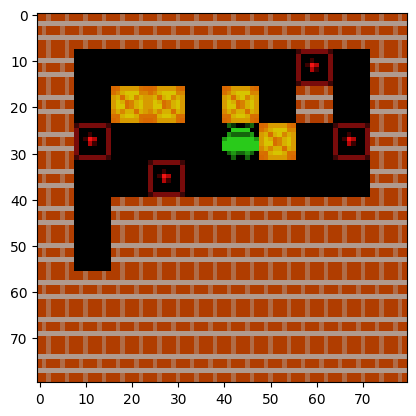

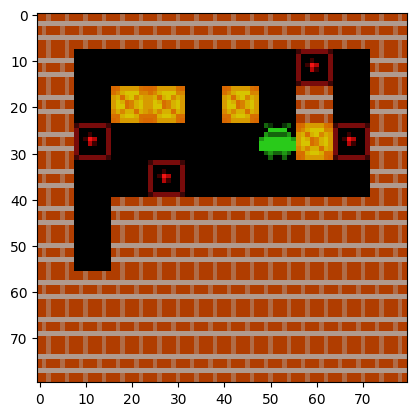

tensor([4], device='cuda:0') p:  [[4.8584794e-03 6.3467691e-05 5.4139580e-04 5.0365698e-02 9.4417101e-01]]


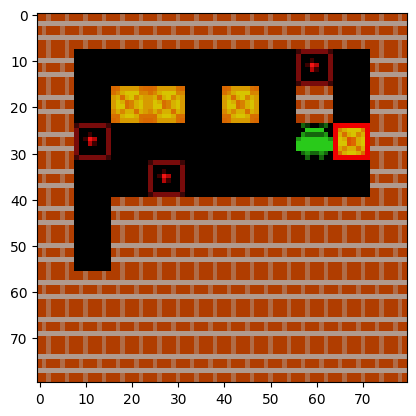

tensor([4], device='cuda:0') p:  [[3.9606994e-06 1.9476012e-07 5.1648540e-06 3.7803443e-07 9.9999034e-01]]


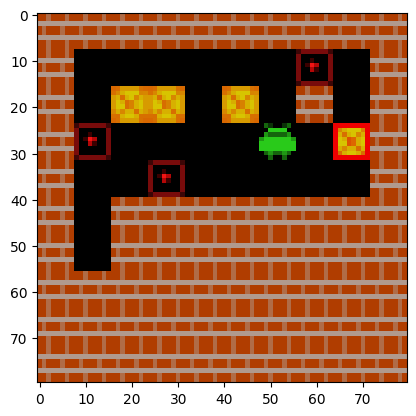

tensor([3], device='cuda:0') p:  [[5.9056614e-04 1.1802192e-03 4.2737694e-04 9.9735022e-01 4.5158542e-04]]


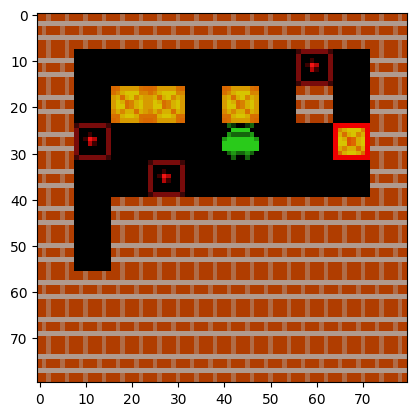

tensor([3], device='cuda:0') p:  [[5.7122705e-04 3.8102530e-03 6.2670582e-04 9.9481696e-01 1.7487725e-04]]


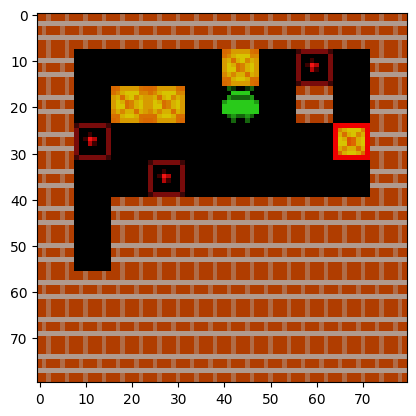

tensor([1], device='cuda:0') p:  [[8.5039734e-05 9.9972409e-01 2.6263390e-06 1.8759436e-04 6.2918508e-07]]


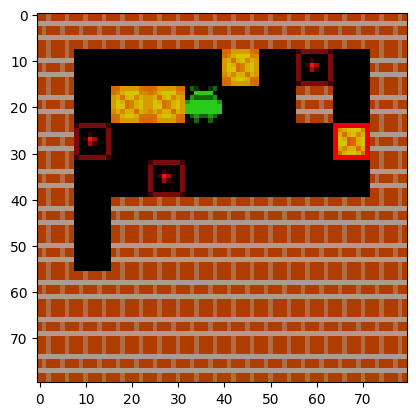

tensor([3], device='cuda:0') p:  [[1.1489611e-04 6.7202463e-06 1.8341418e-05 9.9982303e-01 3.7053684e-05]]


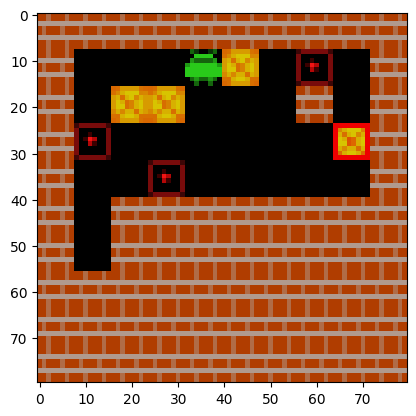

tensor([1], device='cuda:0') p:  [[3.5197211e-06 9.9998868e-01 9.4753244e-07 1.8893425e-07 6.5908293e-06]]


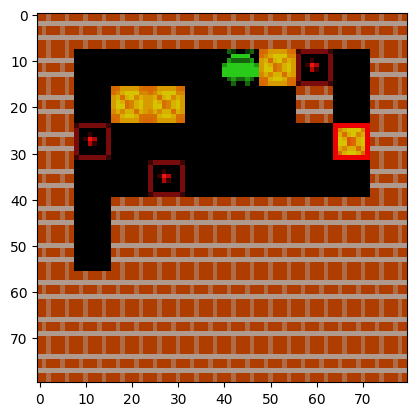

tensor([4], device='cuda:0') p:  [[9.81198740e-04 1.21982084e-04 3.91110807e-05 1.36433989e-02
  9.85214412e-01]]


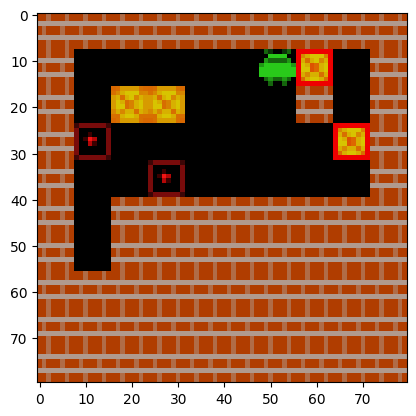

tensor([4], device='cuda:0') p:  [[5.0619734e-04 5.1595771e-04 6.4949959e-06 4.9935834e-04 9.9847192e-01]]


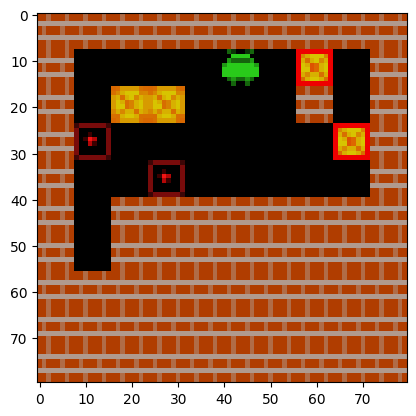

tensor([3], device='cuda:0') p:  [[3.71960457e-03 1.03331525e-02 7.43670575e-03 9.78402078e-01
  1.08547174e-04]]


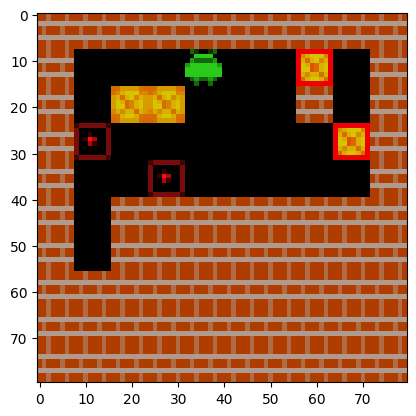

tensor([3], device='cuda:0') p:  [[1.8964437e-03 2.7749965e-03 3.4769757e-03 9.9167645e-01 1.7511100e-04]]


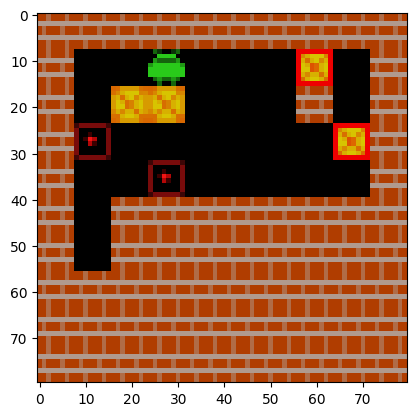

tensor([3], device='cuda:0') p:  [[3.7716373e-04 8.9898378e-05 5.3626049e-04 9.9896860e-01 2.8025996e-05]]


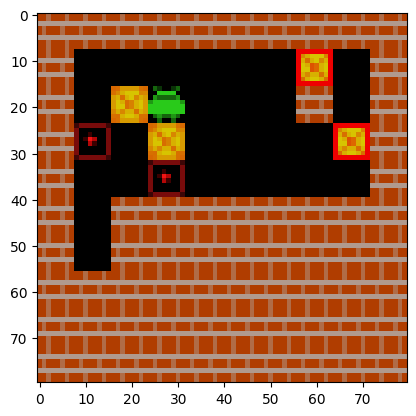

tensor([2], device='cuda:0') p:  [[1.8478924e-04 3.2928256e-05 9.9952602e-01 2.2775923e-04 2.8538421e-05]]


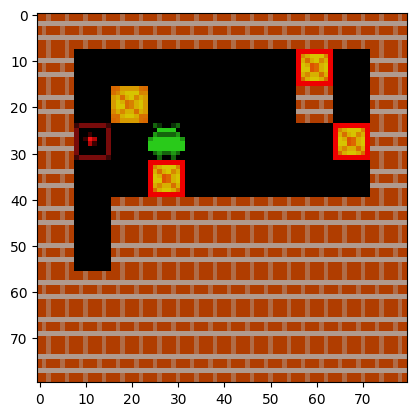

tensor([2], device='cuda:0') p:  [[9.3446206e-03 3.6744101e-04 2.8709236e-01 7.0292670e-01 2.6880123e-04]]


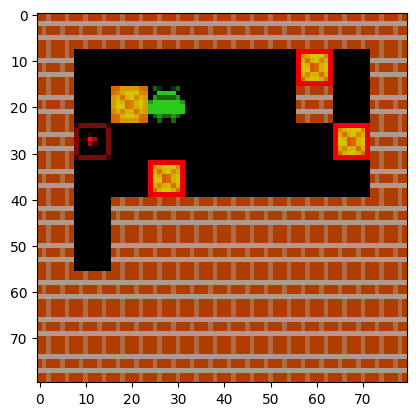

tensor([1], device='cuda:0') p:  [[0.01142882 0.91301435 0.00411242 0.01222511 0.05921926]]


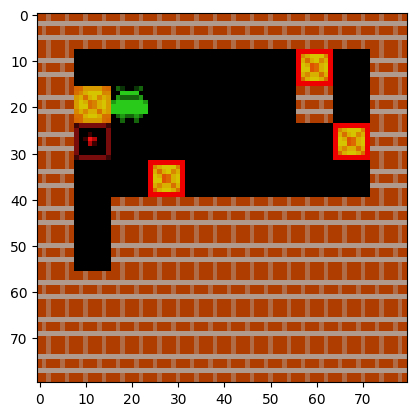

tensor([3], device='cuda:0') p:  [[4.4375058e-04 2.6309938e-04 4.6939207e-05 9.9923384e-01 1.2338011e-05]]


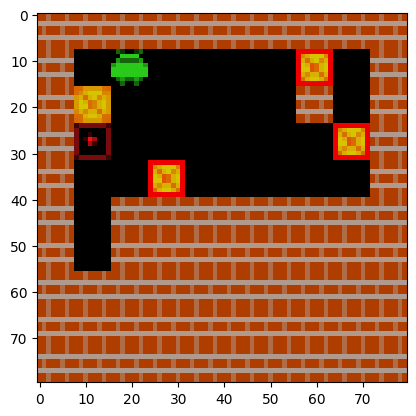

tensor([1], device='cuda:0') p:  [[8.2642457e-04 9.9664491e-01 1.4339715e-03 6.1828014e-04 4.7637676e-04]]


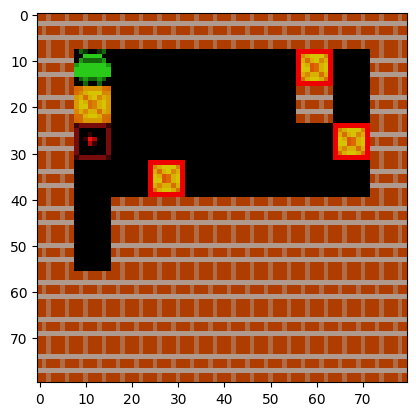

tensor([3], device='cuda:0') p:  [[1.5103152e-03 6.0409523e-04 5.1062927e-04 9.9717087e-01 2.0405937e-04]]


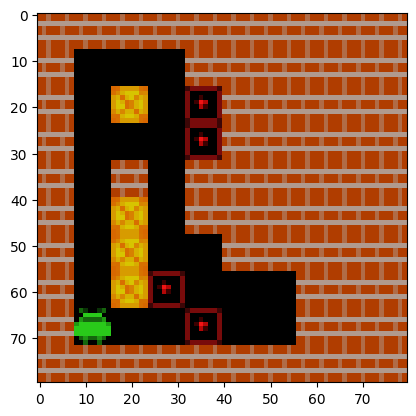

tensor([2], device='cuda:0') p:  [[6.4582156e-04 5.2270613e-04 9.9726832e-01 1.2405571e-03 3.2265668e-04]]


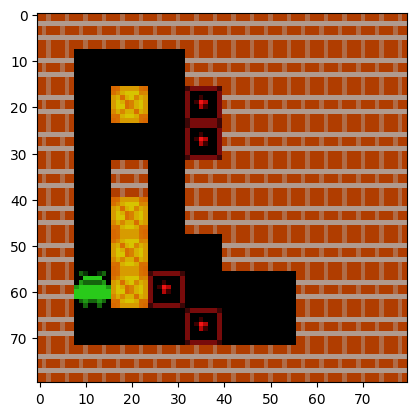

tensor([1], device='cuda:0') p:  [[0.01222564 0.5646321  0.00483205 0.21828307 0.20002718]]


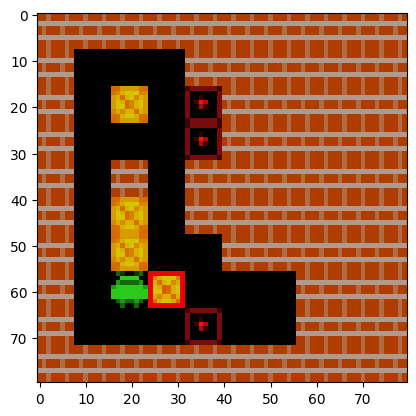

tensor([4], device='cuda:0') p:  [[1.7481104e-04 3.2084394e-04 2.1985159e-04 5.9470673e-05 9.9922490e-01]]


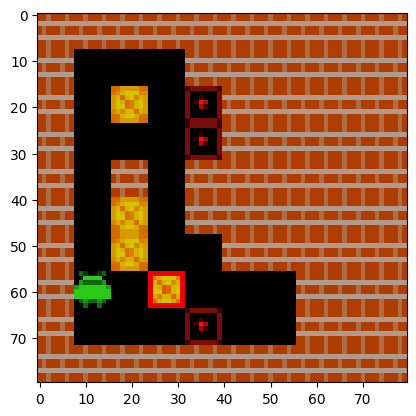

tensor([3], device='cuda:0') p:  [[4.4924225e-05 1.9806623e-06 1.9435314e-04 9.9957937e-01 1.7930761e-04]]


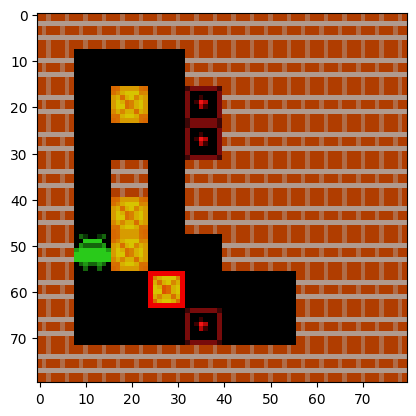

tensor([1], device='cuda:0') p:  [[9.7336226e-05 9.9969745e-01 9.6890748e-05 7.3991963e-05 3.4369252e-05]]


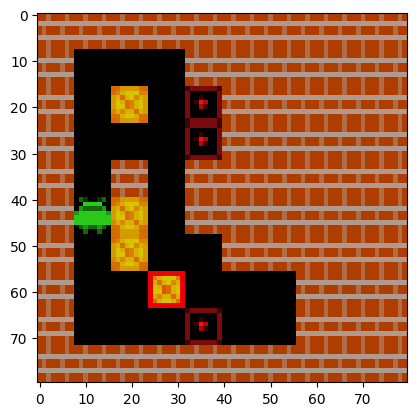

tensor([1], device='cuda:0') p:  [[1.2097097e-03 9.8018324e-01 1.2453706e-03 2.1871312e-04 1.7142924e-02]]


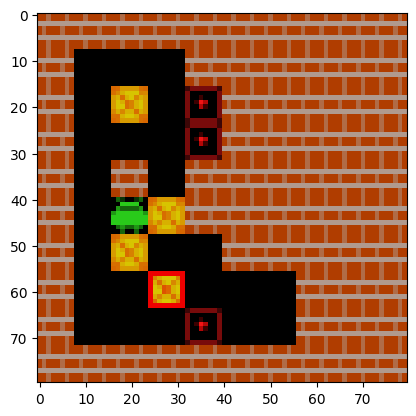

tensor([4], device='cuda:0') p:  [[1.4783107e-04 7.5296266e-05 4.5557874e-05 1.2173961e-05 9.9971920e-01]]


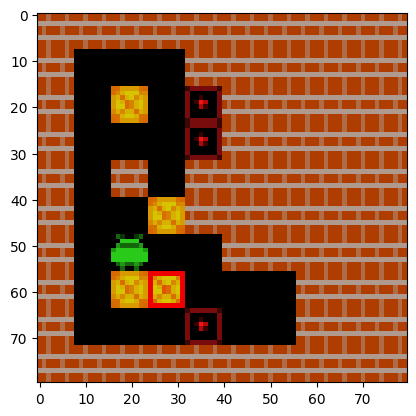

tensor([2], device='cuda:0') p:  [[6.0218836e-06 5.2330580e-07 9.9999297e-01 2.7514832e-07 1.9034228e-07]]


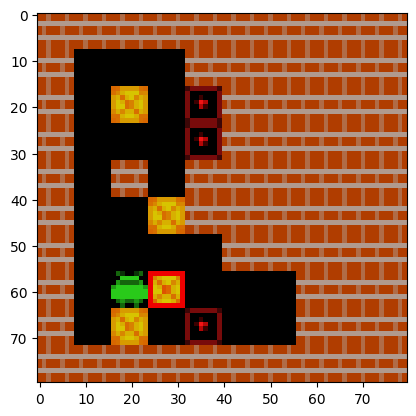

tensor([2], device='cuda:0') p:  [[2.9711686e-05 4.6079879e-07 9.9973208e-01 2.0387110e-07 2.3742535e-04]]


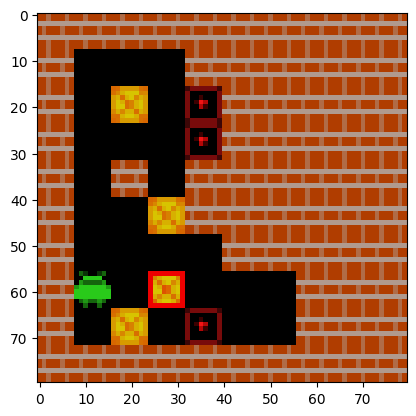

tensor([3], device='cuda:0') p:  [[1.5302196e-04 5.4135974e-03 1.7166656e-05 9.9413705e-01 2.7925009e-04]]


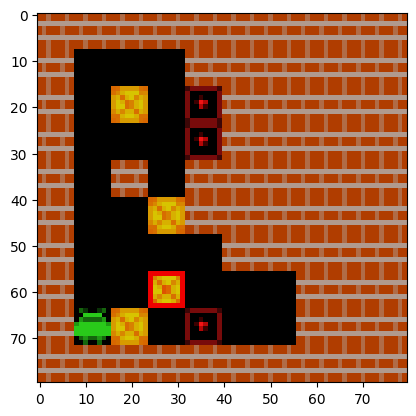

tensor([2], device='cuda:0') p:  [[5.1000650e-05 1.5511878e-05 9.9985456e-01 4.4594267e-06 7.4390082e-05]]


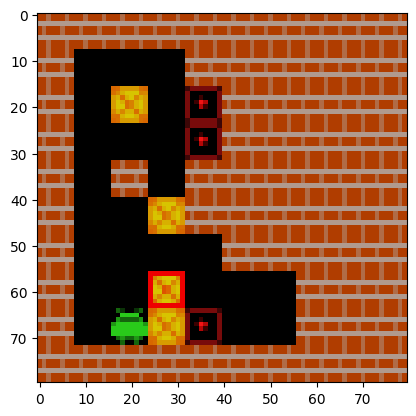

tensor([4], device='cuda:0') p:  [[2.8533866e-05 2.9624667e-05 7.7196719e-06 4.4787356e-07 9.9993372e-01]]


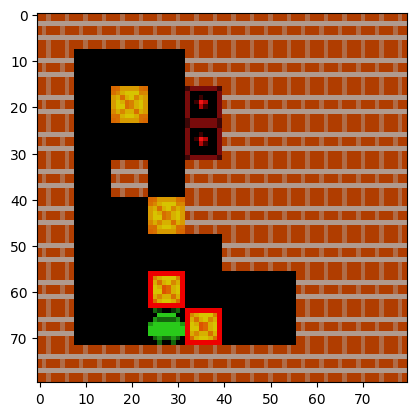

tensor([4], device='cuda:0') p:  [[6.4614942e-06 7.7724490e-06 3.0218866e-06 2.4338931e-07 9.9998260e-01]]


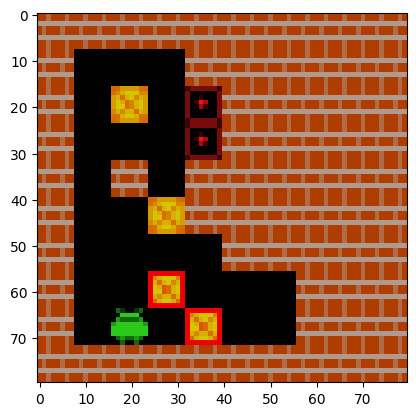

tensor([3], device='cuda:0') p:  [[2.4308023e-04 1.7193413e-03 2.9902084e-04 9.9769920e-01 3.9349339e-05]]


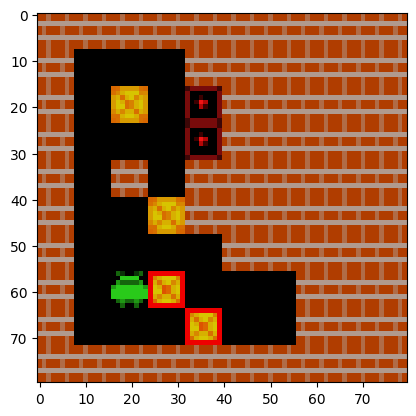

tensor([1], device='cuda:0') p:  [[4.4836317e-05 9.9964345e-01 2.9865632e-05 2.0698656e-04 7.4851334e-05]]


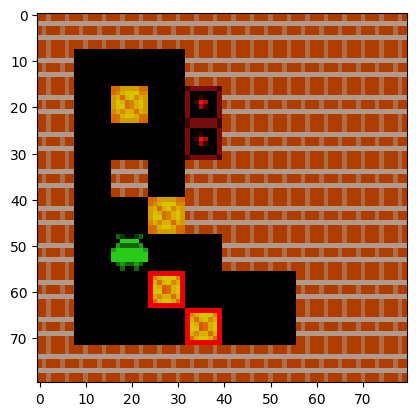

tensor([1], device='cuda:0') p:  [[5.9315647e-05 9.9957377e-01 5.5645480e-05 2.9293631e-04 1.8385103e-05]]


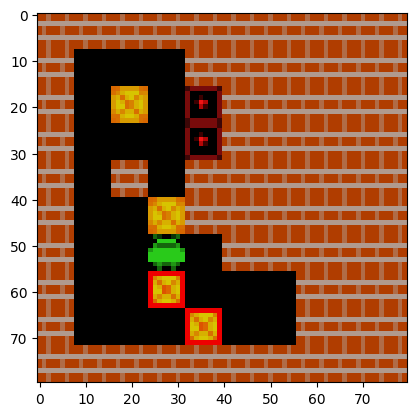

tensor([4], device='cuda:0') p:  [[1.2756084e-03 1.1498024e-01 3.6851771e-04 2.2682293e-04 8.8314885e-01]]


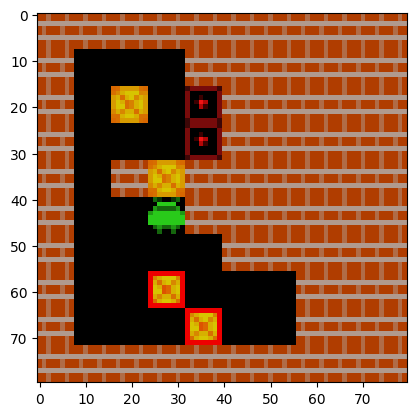

tensor([1], device='cuda:0') p:  [[3.6186655e-05 9.9983585e-01 1.8680798e-06 6.3915992e-05 6.2153369e-05]]


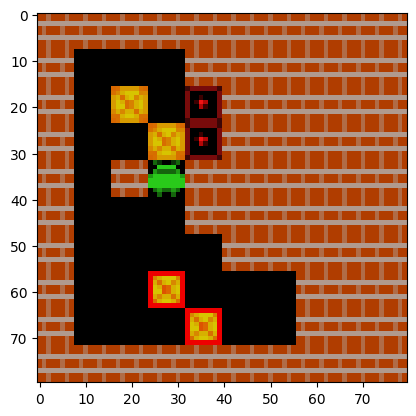

tensor([1], device='cuda:0') p:  [[1.2889024e-04 9.9969709e-01 5.5309902e-05 9.3196490e-05 2.5487714e-05]]


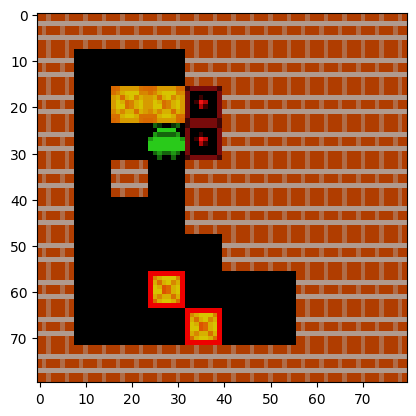

tensor([1], device='cuda:0') p:  [[0.00465591 0.97169894 0.00642814 0.00808061 0.00913649]]


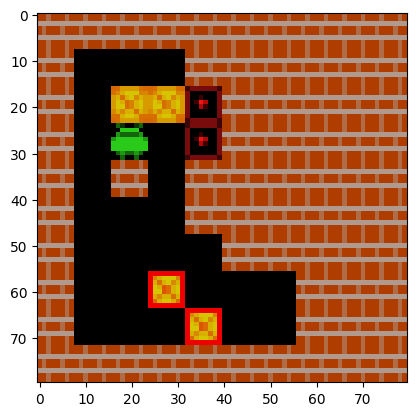

tensor([3], device='cuda:0') p:  [[3.5660928e-08 1.2969530e-14 3.3310407e-08 9.9999976e-01 1.9911097e-07]]


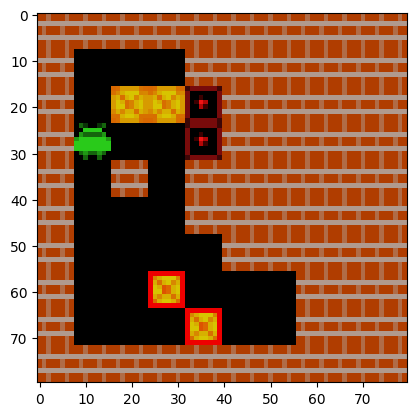

tensor([3], device='cuda:0') p:  [[3.38276768e-05 9.78749540e-07 1.08386521e-05 9.99941111e-01
  1.32755395e-05]]


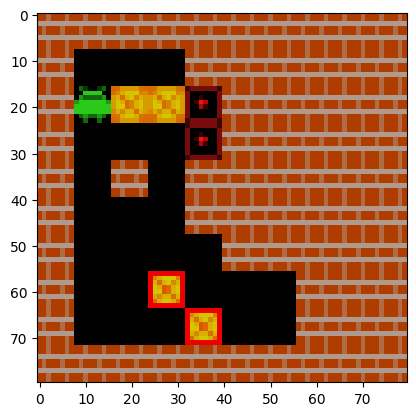

tensor([1], device='cuda:0') p:  [[3.6828022e-04 9.9840659e-01 3.5256281e-04 3.8183763e-04 4.9078889e-04]]


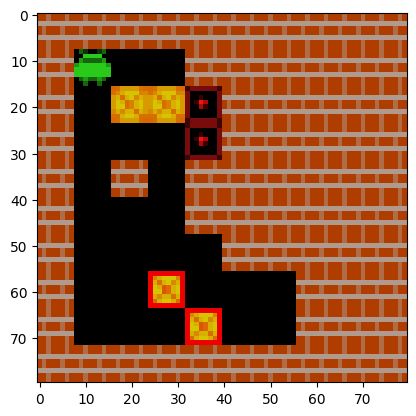

tensor([1], device='cuda:0') p:  [[0.00302569 0.9674251  0.01844527 0.00848975 0.00261423]]


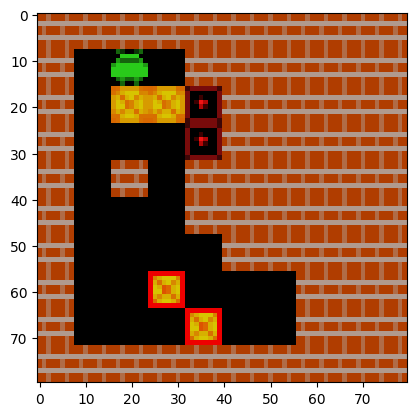

tensor([4], device='cuda:0') p:  [[4.4404998e-04 8.4447805e-05 1.8015223e-04 1.2412455e-04 9.9916732e-01]]


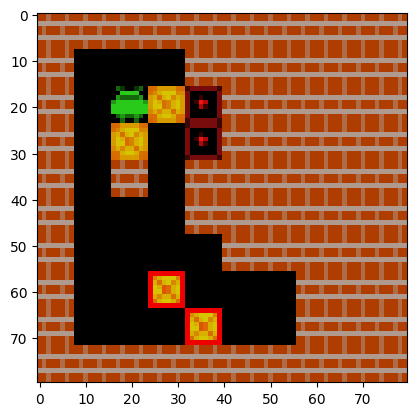

tensor([2], device='cuda:0') p:  [[3.5512776e-04 4.2694103e-04 9.9855739e-01 9.5078765e-05 5.6549895e-04]]


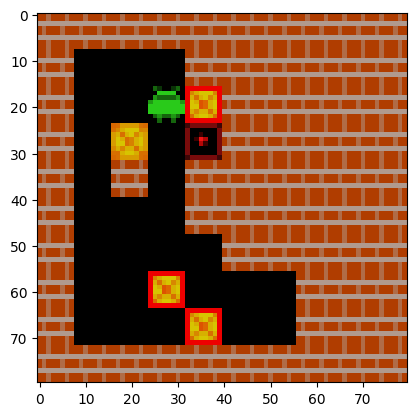

tensor([4], device='cuda:0') p:  [[2.5640754e-04 1.8375325e-05 8.6324837e-07 2.4128284e-02 9.7559607e-01]]


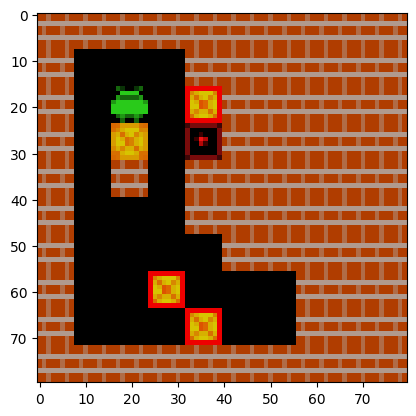

tensor([3], device='cuda:0') p:  [[8.4234768e-04 7.4538719e-03 1.0660115e-03 9.9057746e-01 6.0385653e-05]]


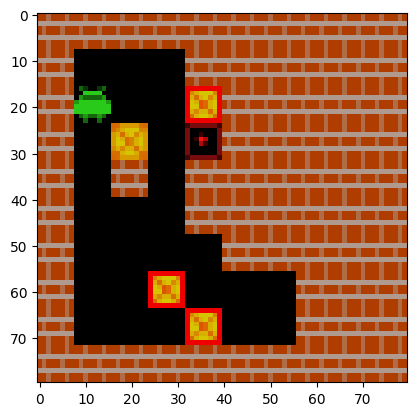

tensor([3], device='cuda:0') p:  [[1.0040189e-05 6.4971387e-06 1.4222264e-06 9.9997938e-01 2.6322612e-06]]


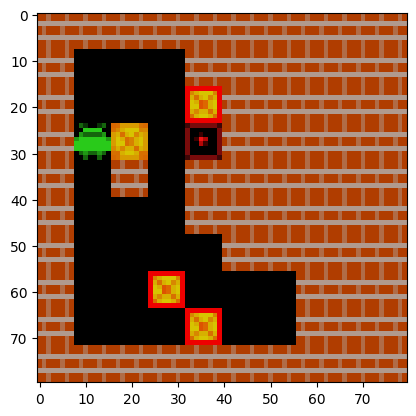

tensor([2], device='cuda:0') p:  [[4.7233925e-04 4.8683197e-04 9.9845338e-01 3.9614161e-04 1.9138325e-04]]


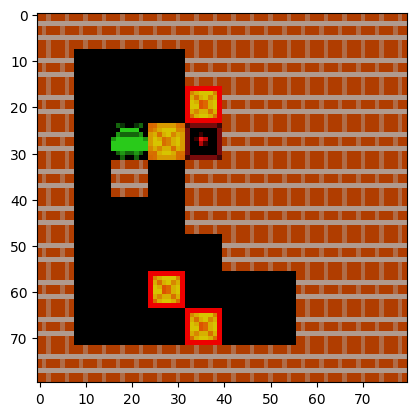

tensor([4], device='cuda:0') p:  [[3.9962557e-04 1.6050928e-04 1.2198322e-04 1.4236904e-04 9.9917549e-01]]


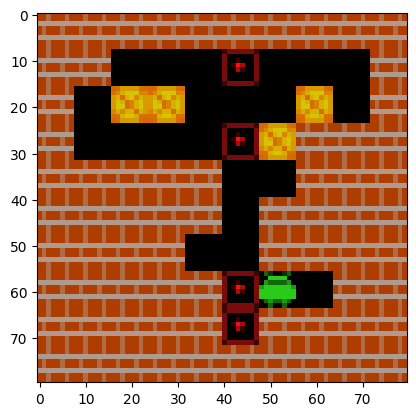

tensor([4], device='cuda:0') p:  [[7.4918069e-05 2.5572788e-05 1.9884822e-06 3.7545299e-06 9.9989367e-01]]


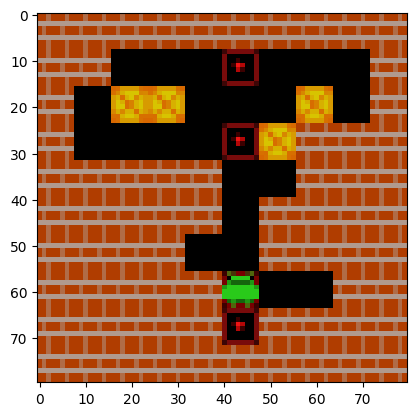

tensor([3], device='cuda:0') p:  [[0.00820888 0.00709974 0.00399065 0.7419929  0.23870786]]


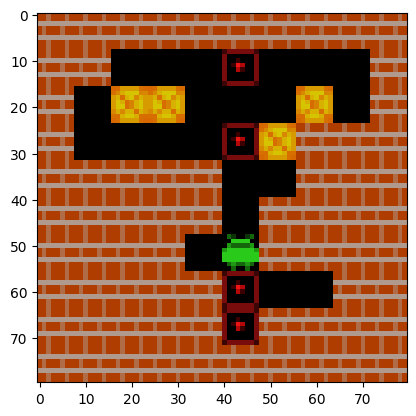

tensor([1], device='cuda:0') p:  [[4.7663358e-04 9.8931724e-01 3.9060658e-03 3.1451229e-04 5.9855068e-03]]


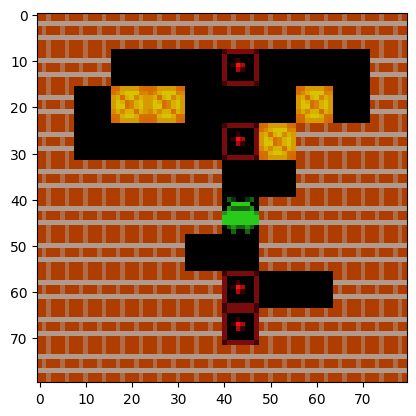

tensor([1], device='cuda:0') p:  [[0.00182395 0.93192685 0.0054312  0.00754449 0.05327351]]


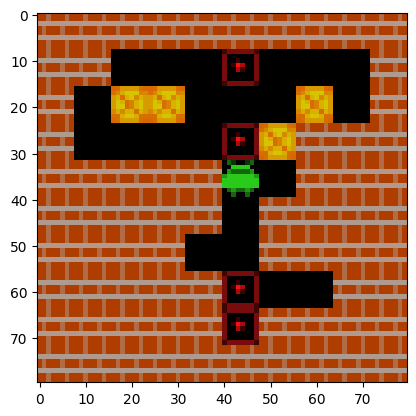

tensor([1], device='cuda:0') p:  [[5.6674337e-04 9.5795238e-01 2.6081619e-03 1.0256820e-03 3.7847016e-02]]


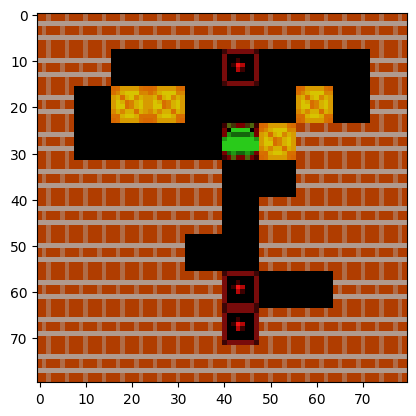

tensor([1], device='cuda:0') p:  [[4.8745389e-04 5.8279842e-01 1.5964177e-04 1.3830977e-04 4.1641614e-01]]


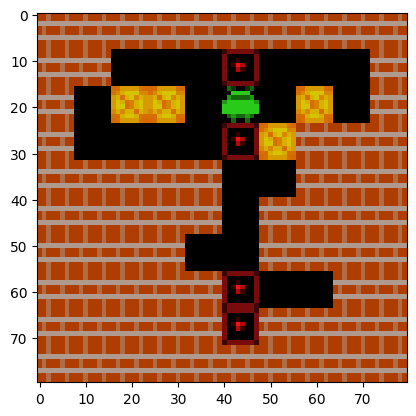

tensor([1], device='cuda:0') p:  [[1.3552456e-03 7.9196447e-01 1.8939211e-03 2.0469262e-01 9.3814648e-05]]


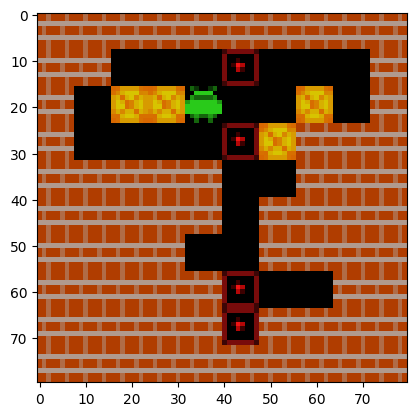

tensor([3], device='cuda:0') p:  [[2.2030335e-03 8.5801474e-04 5.2629918e-04 6.7129135e-01 3.2512131e-01]]


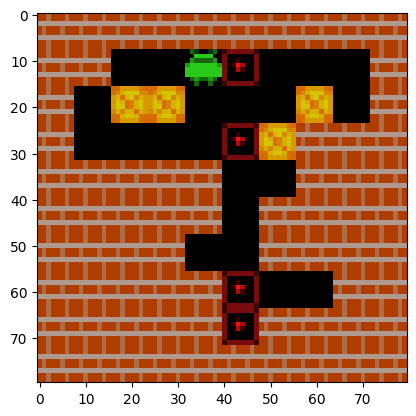

tensor([1], device='cuda:0') p:  [[9.6297479e-04 8.6833036e-01 1.0768853e-01 6.2137660e-05 2.2956021e-02]]


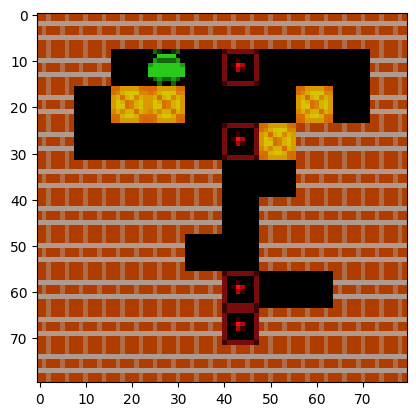

tensor([3], device='cuda:0') p:  [[1.1544561e-03 3.1211870e-04 5.9658323e-05 8.6783075e-01 1.3064300e-01]]


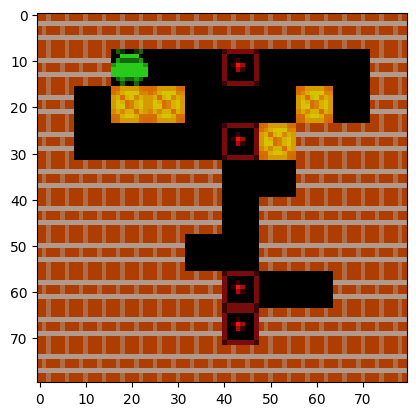

tensor([3], device='cuda:0') p:  [[4.4132376e-04 4.8624290e-05 3.9086290e-04 9.9459344e-01 4.5257751e-03]]


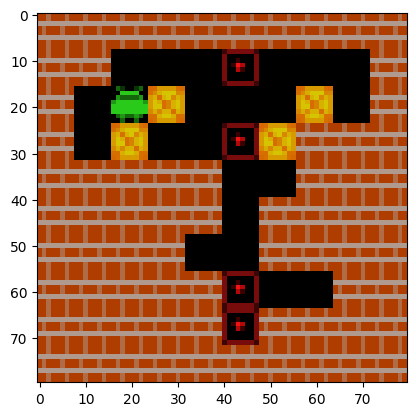

tensor([2], device='cuda:0') p:  [[1.0632886e-05 8.9499412e-07 9.9979037e-01 1.0977500e-06 1.9700325e-04]]


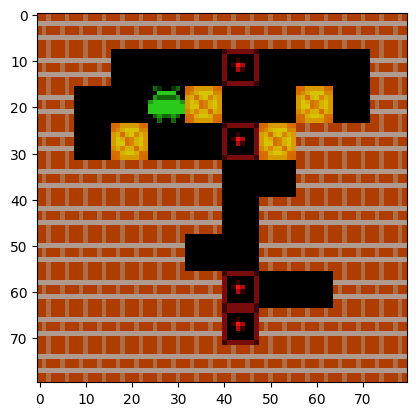

tensor([4], device='cuda:0') p:  [[6.5988873e-04 2.5623941e-03 1.5589996e-05 6.0973275e-02 9.3578887e-01]]


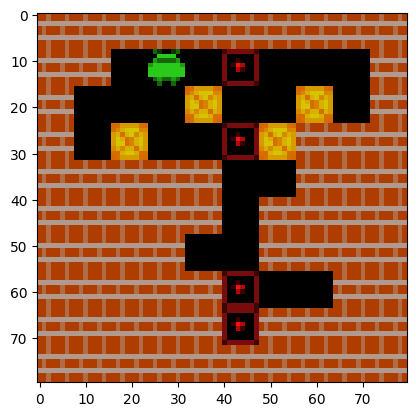

tensor([1], device='cuda:0') p:  [[0.00192037 0.8833799  0.07958521 0.02462124 0.01049336]]


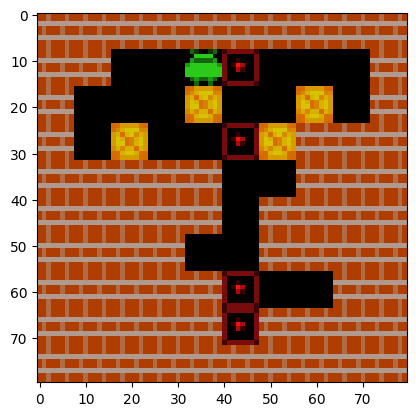

tensor([4], device='cuda:0') p:  [[4.1689244e-05 3.0408328e-06 2.3936224e-04 2.8020480e-05 9.9968779e-01]]


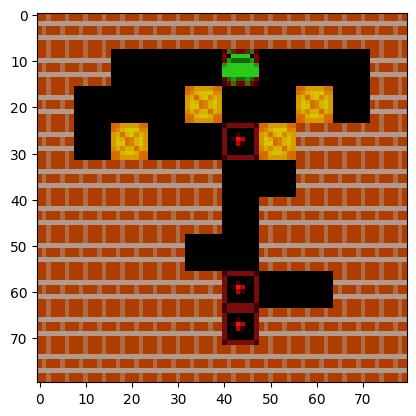

tensor([4], device='cuda:0') p:  [[9.0112031e-04 7.2592935e-05 4.4198800e-02 2.9462383e-03 9.5188129e-01]]


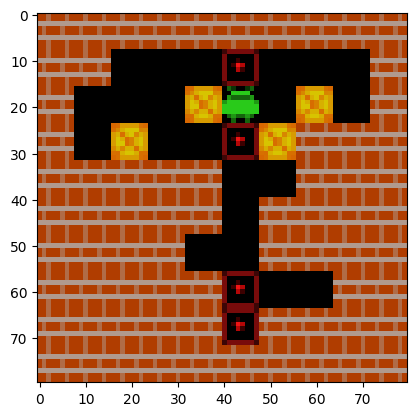

tensor([2], device='cuda:0') p:  [[1.0487088e-03 6.1212348e-05 9.6236825e-01 1.1985345e-02 2.4536563e-02]]


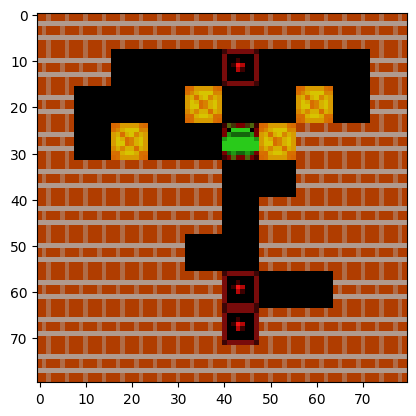

tensor([2], device='cuda:0') p:  [[0.0100511  0.03611566 0.9221561  0.01214002 0.01953715]]


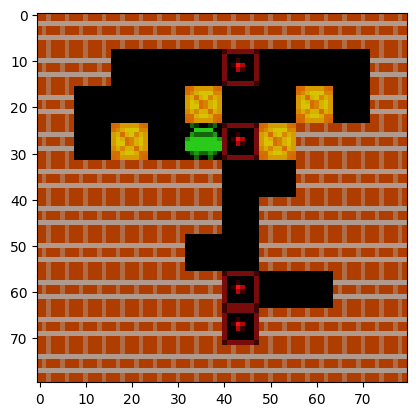

tensor([3], device='cuda:0') p:  [[1.1385017e-02 2.6284764e-02 3.9868560e-01 5.6343448e-01 2.1013155e-04]]


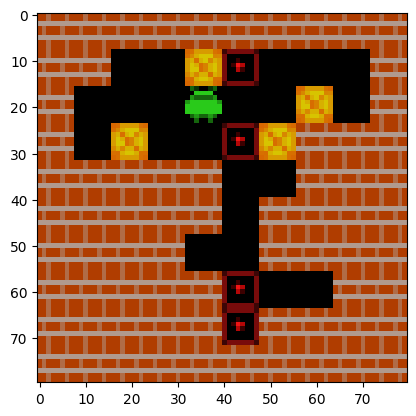

tensor([1], device='cuda:0') p:  [[3.4803178e-04 9.8748952e-01 9.2372400e-05 8.9581907e-03 3.1118894e-03]]


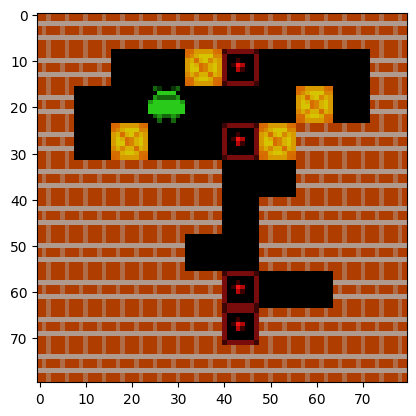

tensor([3], device='cuda:0') p:  [[1.21910365e-04 3.05274648e-06 2.29192688e-06 9.97146547e-01
  2.72611063e-03]]


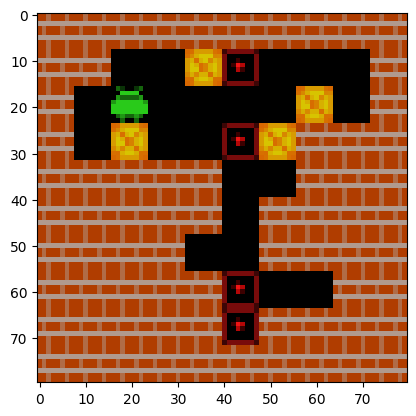

tensor([3], device='cuda:0') p:  [[3.6951870e-04 1.3251311e-01 2.0026548e-05 8.6690903e-01 1.8832093e-04]]


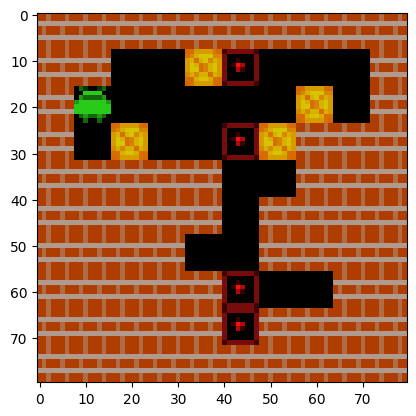

tensor([3], device='cuda:0') p:  [[1.18257492e-04 4.00433812e-04 1.44200585e-05 9.98864174e-01
  6.02696673e-04]]


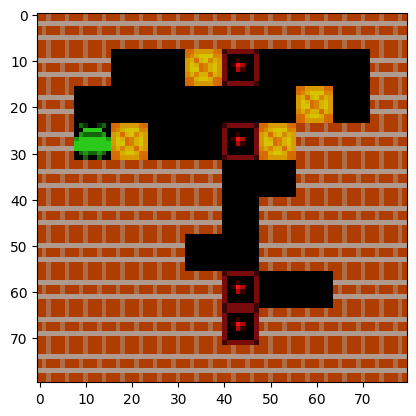

tensor([2], device='cuda:0') p:  [[7.8194907e-06 2.4709749e-07 9.9997807e-01 1.7496765e-06 1.2103052e-05]]


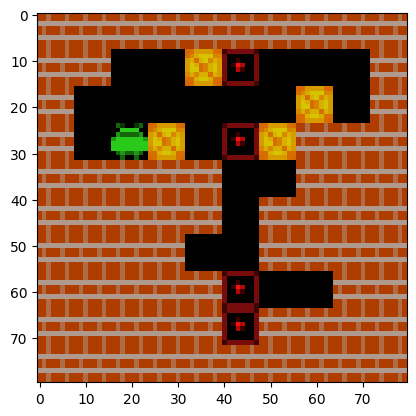

tensor([4], device='cuda:0') p:  [[4.4063100e-07 9.7820504e-08 5.4226614e-09 4.5146371e-09 9.9999940e-01]]


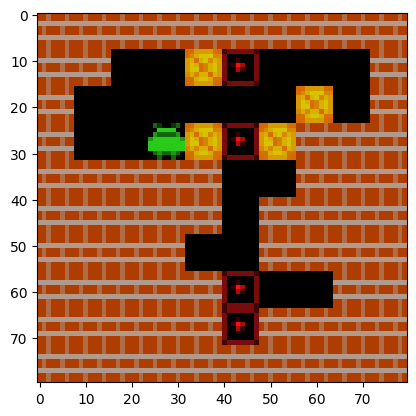

tensor([4], device='cuda:0') p:  [[1.4226136e-06 1.5331375e-06 6.7979080e-08 6.3519209e-08 9.9999690e-01]]


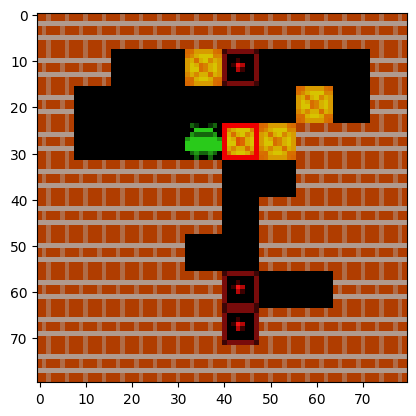

tensor([4], device='cuda:0') p:  [[4.0712030e-06 1.6698012e-05 6.4946755e-07 2.1914694e-07 9.9997842e-01]]


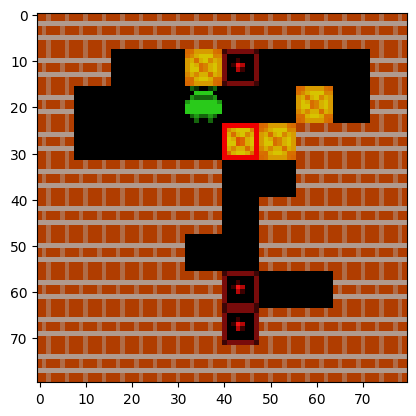

tensor([1], device='cuda:0') p:  [[1.2288369e-05 9.9947637e-01 3.5941480e-06 5.0573109e-04 1.9843828e-06]]


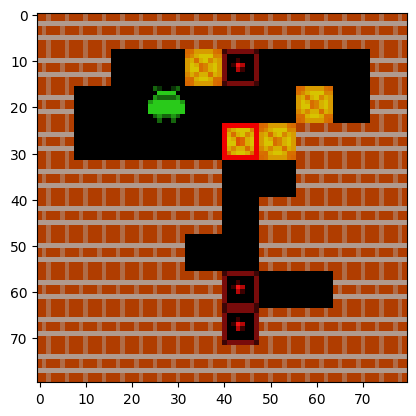

tensor([3], device='cuda:0') p:  [[6.11079449e-04 1.66028462e-06 1.51505255e-05 7.49206662e-01
  2.50165343e-01]]


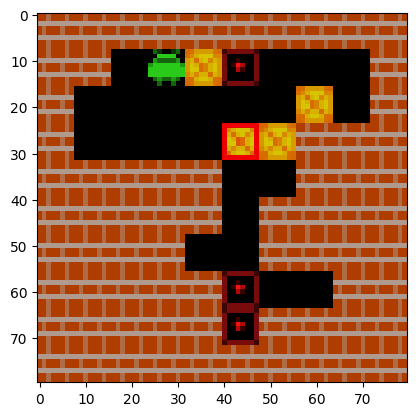

tensor([1], device='cuda:0') p:  [[0.00103484 0.98908347 0.0017972  0.0049444  0.00314016]]


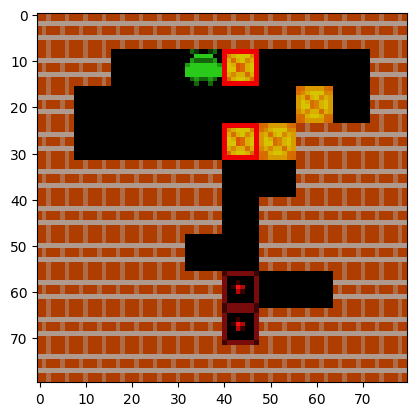

tensor([4], device='cuda:0') p:  [[4.6329471e-05 8.6435521e-06 6.9348622e-05 2.7996139e-05 9.9984765e-01]]


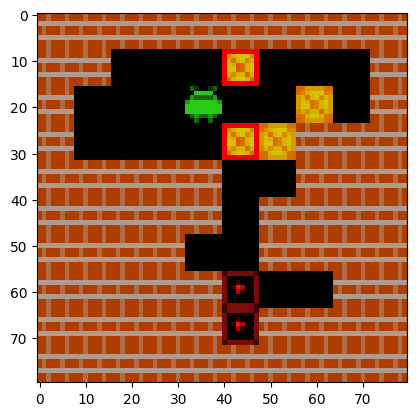

tensor([2], device='cuda:0') p:  [[4.1789361e-05 1.4098589e-05 9.9992537e-01 1.8271468e-05 3.7876802e-07]]


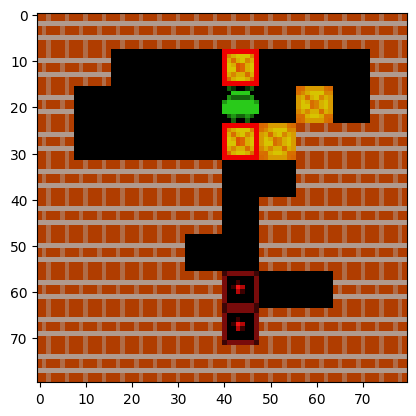

tensor([4], device='cuda:0') p:  [[7.8287987e-05 6.2192353e-06 2.8901396e-04 3.0434668e-07 9.9962616e-01]]


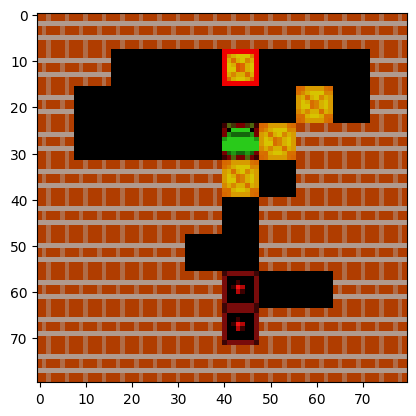

tensor([2], device='cuda:0') p:  [[1.1319387e-05 3.3994533e-07 9.9978703e-01 9.1564004e-08 2.0114864e-04]]


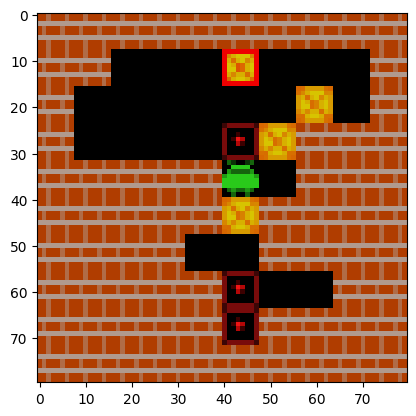

tensor([2], device='cuda:0') p:  [[3.2696957e-04 1.5963204e-02 9.8370886e-01 8.2881382e-07 4.5177380e-08]]


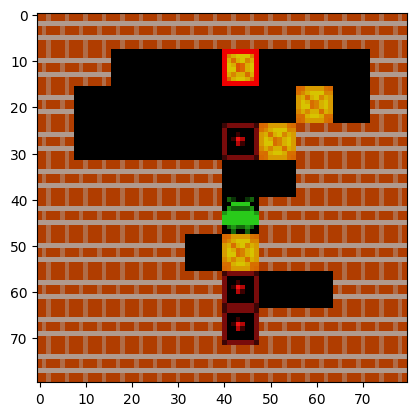

tensor([2], device='cuda:0') p:  [[1.3990730e-05 7.1512741e-06 9.9996936e-01 1.5883076e-08 9.5075147e-06]]


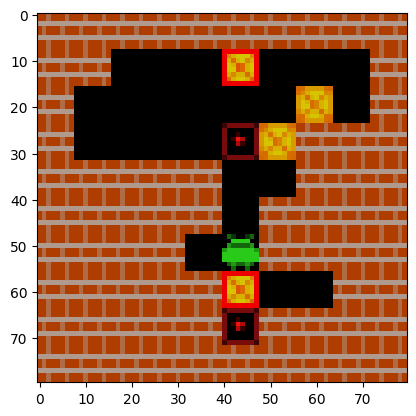

tensor([2], device='cuda:0') p:  [[5.4735875e-07 4.2687327e-07 9.9999893e-01 1.3990968e-09 4.5739135e-08]]


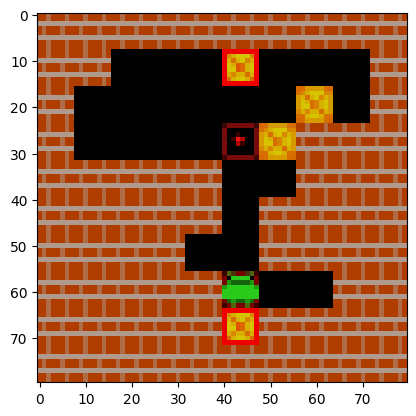

tensor([2], device='cuda:0') p:  [[3.3704608e-05 8.9312285e-05 9.9987543e-01 9.1603243e-07 6.0590173e-07]]


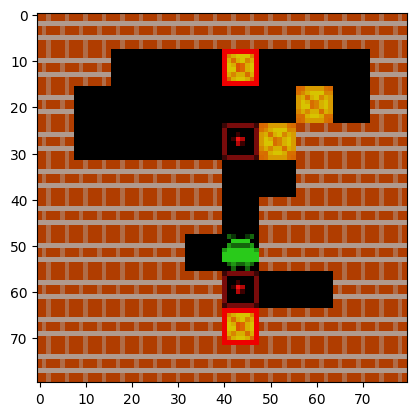

tensor([1], device='cuda:0') p:  [[2.3730882e-03 9.6322966e-01 8.5050490e-04 3.5098987e-04 3.3195738e-02]]


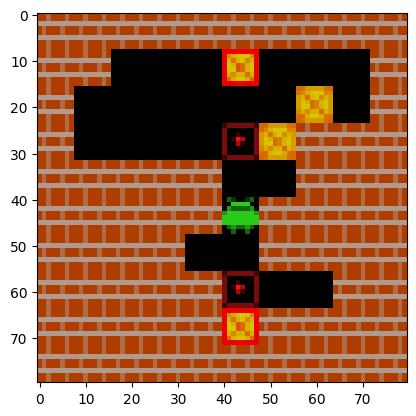

tensor([1], device='cuda:0') p:  [[2.3706393e-04 9.9802566e-01 1.7764092e-04 1.2561833e-03 3.0358092e-04]]


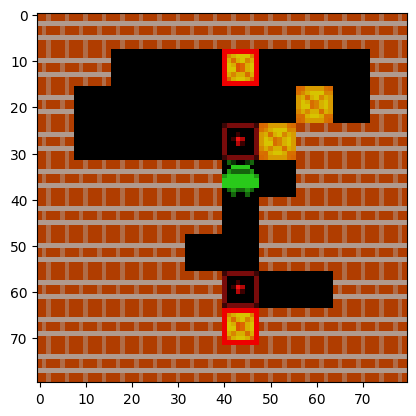

tensor([1], device='cuda:0') p:  [[2.8180320e-05 9.9950337e-01 2.6290883e-05 3.4698257e-06 4.3870803e-04]]


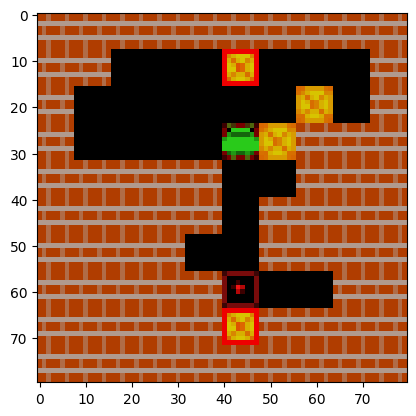

tensor([1], device='cuda:0') p:  [[3.1926720e-05 9.9202931e-01 5.3773470e-06 3.1854534e-06 7.9301968e-03]]


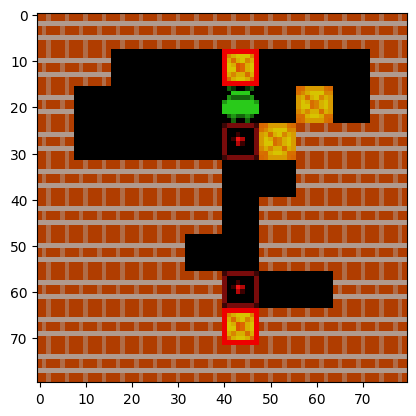

tensor([1], device='cuda:0') p:  [[5.5527307e-06 9.9998224e-01 2.6002028e-06 9.0555077e-06 6.0321969e-07]]


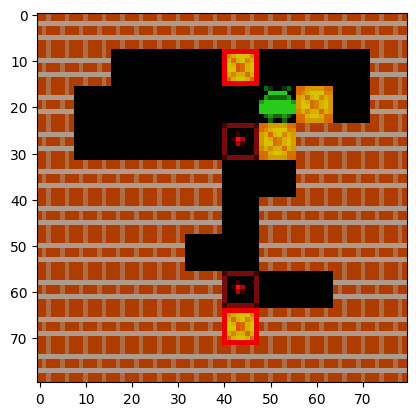

tensor([4], device='cuda:0') p:  [[6.6151238e-06 3.5220278e-06 2.5633394e-06 5.0003644e-07 9.9998677e-01]]


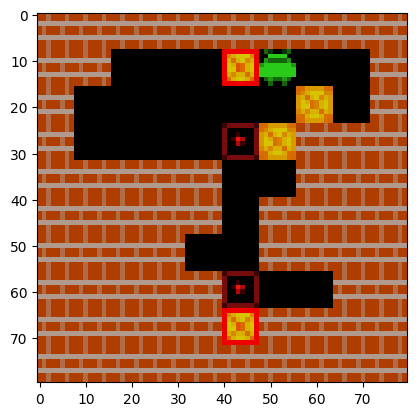

tensor([1], device='cuda:0') p:  [[1.1922567e-05 9.9978894e-01 1.3469919e-06 1.9481740e-04 2.8886868e-06]]


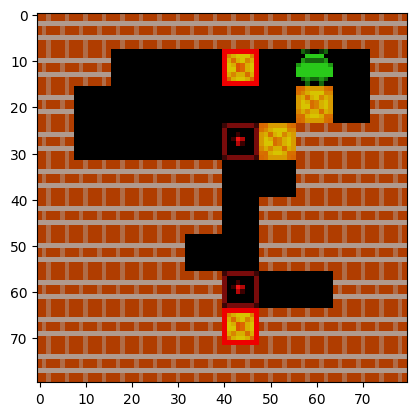

tensor([4], device='cuda:0') p:  [[1.3613582e-03 1.1289882e-03 5.7247624e-02 8.0106322e-05 9.4018197e-01]]


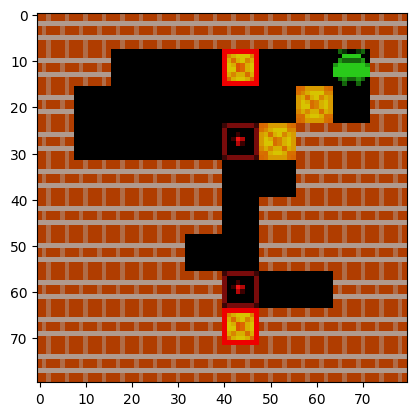

tensor([4], device='cuda:0') p:  [[2.2584942e-05 6.6239067e-05 1.9782401e-06 4.1846273e-04 9.9949062e-01]]


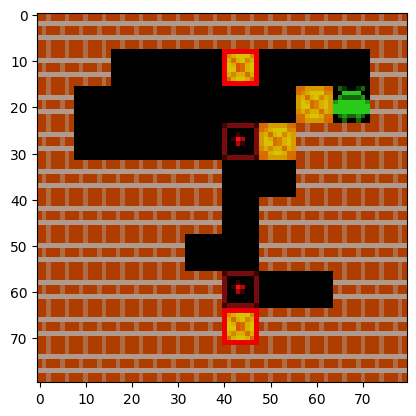

tensor([2], device='cuda:0') p:  [[7.2036404e-05 2.0365418e-05 9.9967074e-01 6.0646678e-05 1.7622404e-04]]


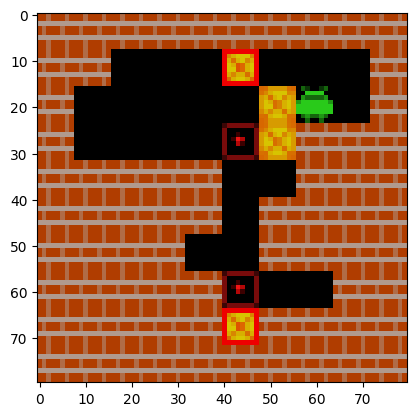

tensor([3], device='cuda:0') p:  [[5.6442754e-05 8.9420109e-06 4.8428607e-05 9.9979132e-01 9.4855968e-05]]


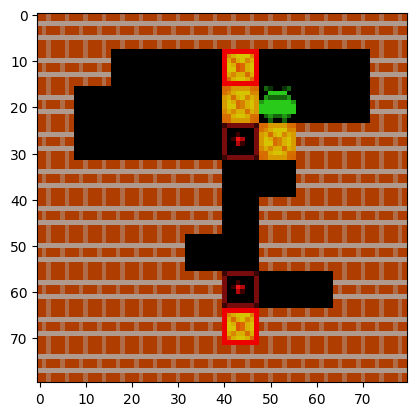

tensor([3], device='cuda:0') p:  [[6.9385806e-08 1.1345359e-09 4.2078874e-10 9.9999988e-01 1.2809201e-09]]


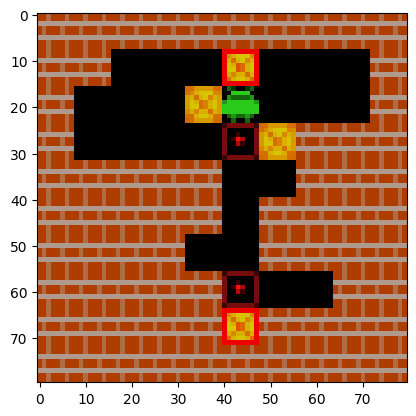

tensor([3], device='cuda:0') p:  [[1.4843538e-07 1.0266984e-07 2.5211422e-09 9.9999976e-01 7.2840128e-10]]


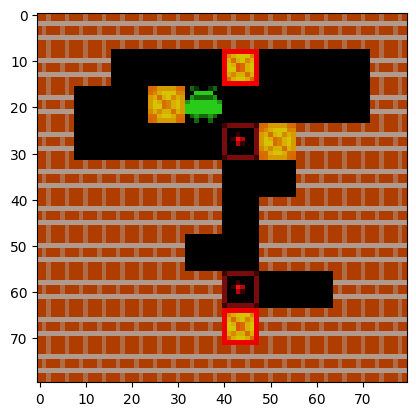

tensor([3], device='cuda:0') p:  [[7.9827558e-04 3.6434914e-05 3.6410221e-01 6.3380092e-01 1.2621848e-03]]


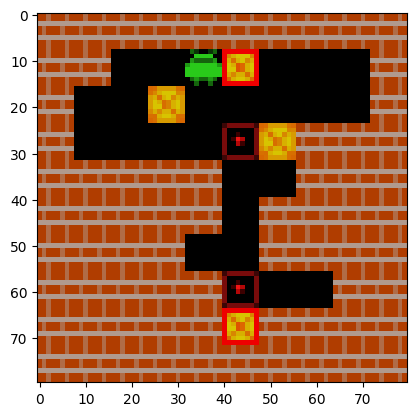

tensor([1], device='cuda:0') p:  [[1.6848267e-04 9.9428779e-01 3.2325357e-03 7.5813288e-05 2.2353348e-03]]


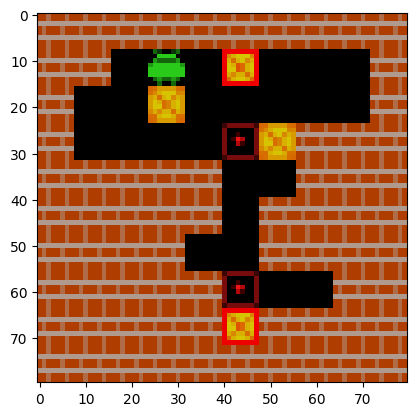

tensor([3], device='cuda:0') p:  [[2.3790495e-03 1.3925534e-04 8.8499654e-03 9.6829504e-01 2.0336799e-02]]


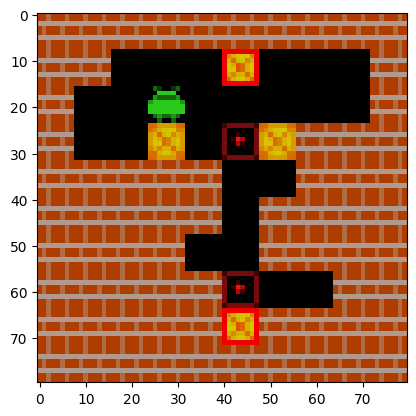

tensor([2], device='cuda:0') p:  [[8.0355181e-04 5.6113733e-04 9.8710930e-01 1.0157396e-03 1.0510239e-02]]


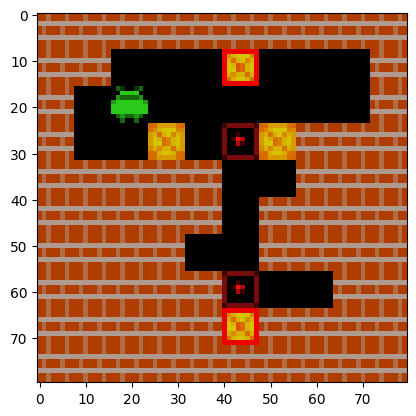

tensor([3], device='cuda:0') p:  [[1.4293826e-03 1.2510114e-02 1.1438328e-04 8.6682934e-01 1.1911681e-01]]


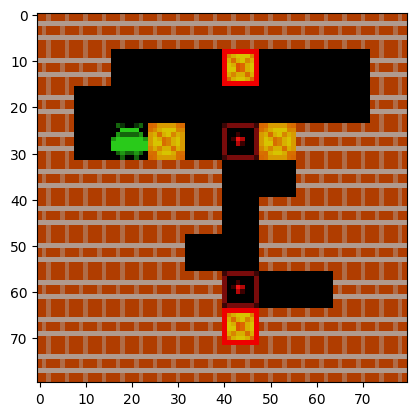

tensor([2], device='cuda:0') p:  [[1.3065703e-06 5.7250006e-08 9.9999654e-01 9.1109989e-08 2.0808288e-06]]


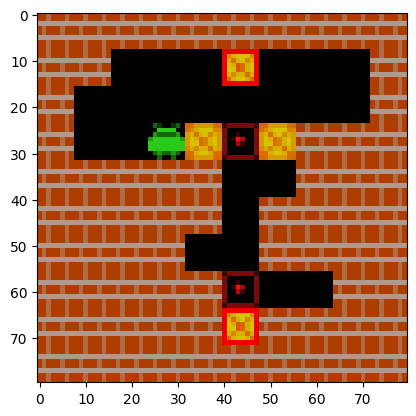

tensor([4], device='cuda:0') p:  [[1.8858939e-06 7.4933986e-08 2.5873238e-08 3.8955402e-08 9.9999797e-01]]


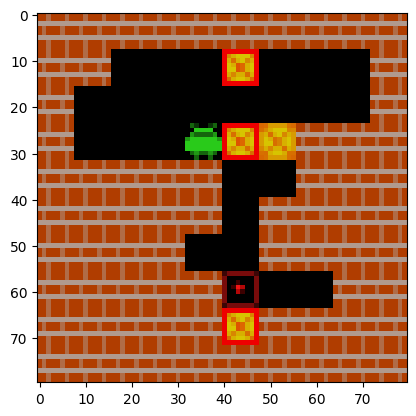

tensor([4], device='cuda:0') p:  [[2.0608093e-06 2.8898353e-07 1.3401209e-06 6.7555860e-08 9.9999630e-01]]


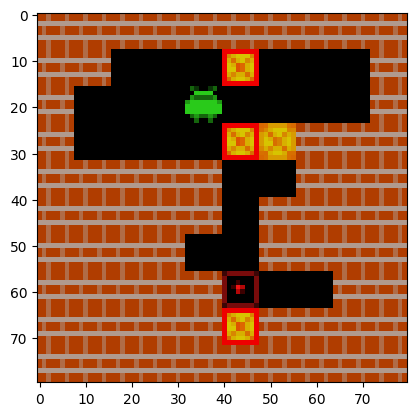

tensor([1], device='cuda:0') p:  [[6.8018315e-05 9.9907827e-01 9.4027928e-06 8.4389973e-04 3.5463810e-07]]


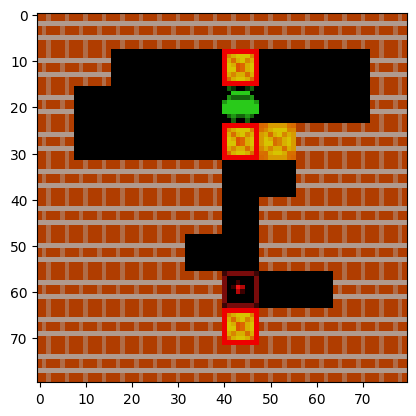

tensor([4], device='cuda:0') p:  [[8.5859665e-06 2.3171201e-06 4.0272407e-06 3.9345139e-07 9.9998462e-01]]


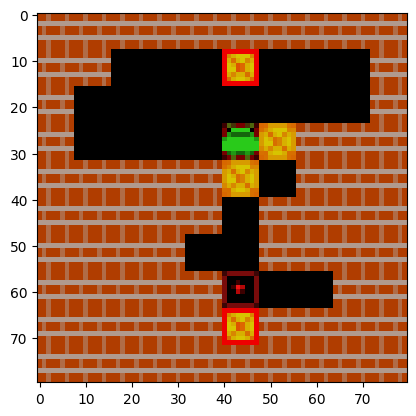

tensor([2], device='cuda:0') p:  [[5.3276258e-06 1.5487186e-07 9.9999237e-01 1.0107103e-06 1.0723635e-06]]


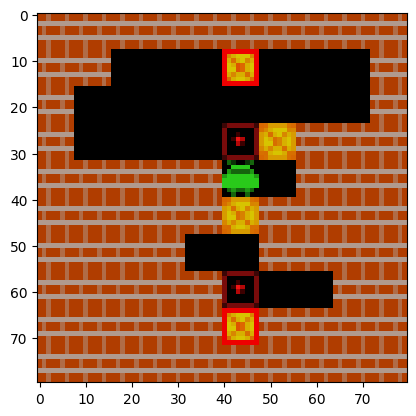

tensor([2], device='cuda:0') p:  [[2.5218043e-05 2.8851207e-05 9.9994552e-01 2.9758780e-07 2.4276294e-09]]


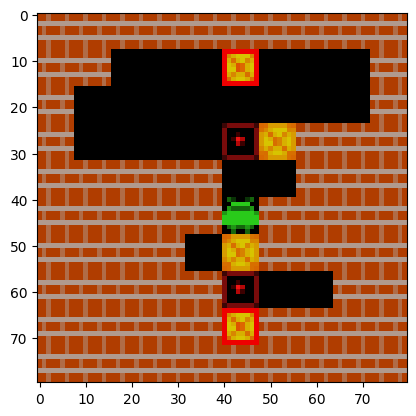

tensor([2], device='cuda:0') p:  [[1.94078002e-05 2.14008469e-05 9.99837756e-01 7.30278371e-09
  1.21407895e-04]]


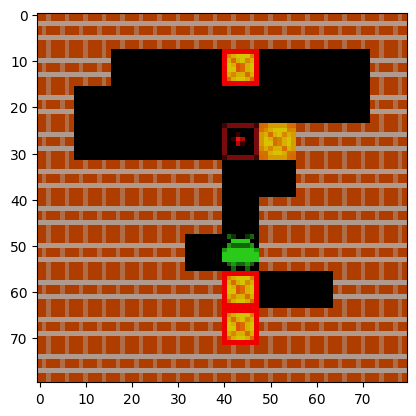

tensor([2], device='cuda:0') p:  [[7.3998549e-06 2.9113871e-04 9.9970108e-01 8.5397129e-09 2.9171608e-07]]


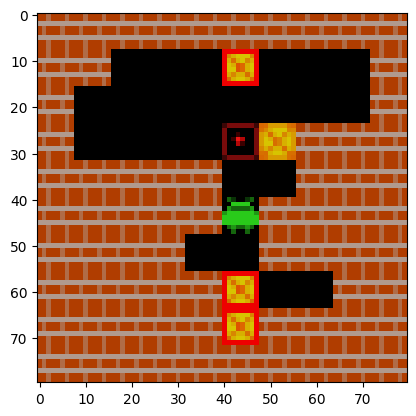

tensor([1], device='cuda:0') p:  [[2.2003718e-05 9.9991822e-01 2.8360948e-06 4.9789571e-05 7.0819888e-06]]


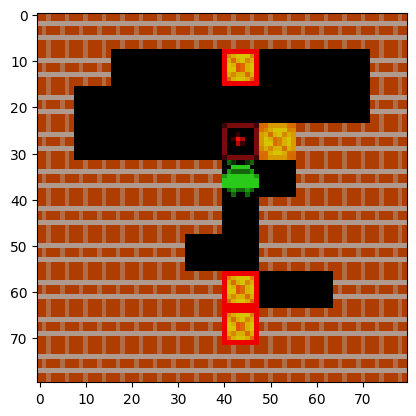

tensor([1], device='cuda:0') p:  [[3.8679796e-06 9.9999130e-01 1.4210827e-06 1.6154459e-08 3.4294164e-06]]


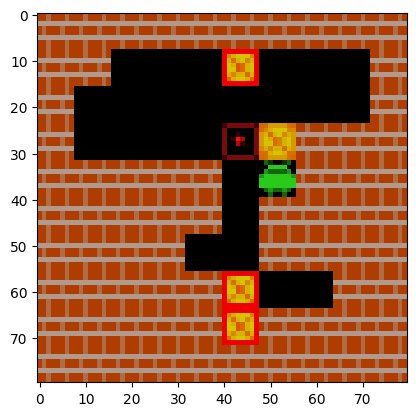

tensor([4], device='cuda:0') p:  [[1.1988627e-05 1.0617352e-04 3.2972407e-06 8.2302964e-09 9.9987841e-01]]


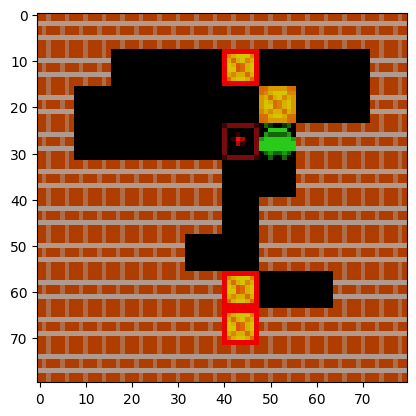

tensor([1], device='cuda:0') p:  [[2.2518279e-03 5.5879158e-01 4.1423005e-04 4.3840504e-01 1.3734796e-04]]


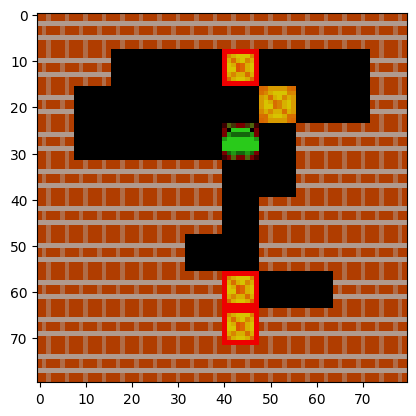

tensor([3], device='cuda:0') p:  [[1.7690032e-05 7.0290557e-10 3.1300777e-05 9.9992704e-01 2.3968651e-05]]


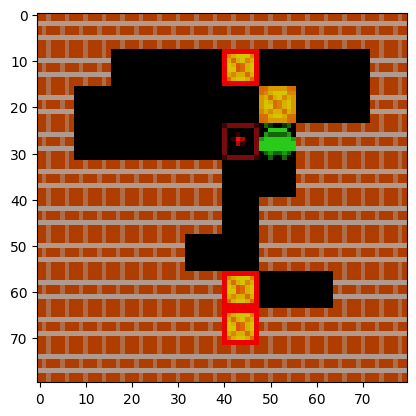

tensor([4], device='cuda:0') p:  [[0.00618719 0.17973608 0.01416486 0.00157174 0.79834014]]


In [91]:
env = atari_wrappers.SokobanWrapper(gym.make("Sokoban-v0"), noop=not flags.env_disable_noop)
env = environment.Environment(env)
obs = env.initial()
core_state = net.initial_state(batch_size=1)
core_state = tuple(v.to(device) for v in core_state)
plt.imshow(torch.swapaxes(torch.swapaxes(obs["frame"][0,0],0,2),0,1), interpolation='nearest')
plt.show()

net.train(False)

core_state = net.initial_state(batch_size=1)  
core_state = tuple(v.to(device) for v in core_state)
for i in range(120):        
    net_input = {k: obs[k].to(device) for k in obs.keys()}
    net_out_, core_state = net(net_input, core_state, debug=True)            
    if i > 0:
        net_out = {k: torch.concat([net_out[k], net_out_[k][[-1]]]) for k in net_out_test_.keys()}
    else:
        net_out = net_out_
    obs = env.step(net_out_["action"][-1])
    plt.imshow(torch.swapaxes(torch.swapaxes(obs["frame"][0,0],0,2),0,1), interpolation='nearest')
    plt.show()
    print(net_out_["action"][-1], "p: ", torch.softmax(net_out_["policy_logits"][:, 0, :], dim=-1).cpu().detach().numpy())

In [ ]:
#out = net_out["input_pos"][ :, -32:, 0, 0]
out = net_out["attn_1"][:, 7, 0]
#out = net_out["attn_mask"][:, 1, 0]
#out = net_out["policy_logits"][:, 0, :]
#out =  F.one_hot(net_out["action"], 5)[:, 0, :]
#out = out-torch.max(out, dim=-1, keepdim=True)[0]
out = out.detach().numpy()
plt.imshow(out, interpolation='nearest')
plt.show()

<Figure size 640x480 with 0 Axes>

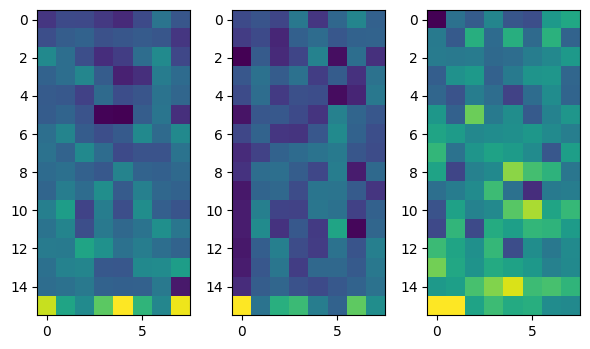

In [92]:
plt.figure()
ln = flags.tran_layer_n

f, axarr = plt.subplots(1, 3, figsize=(6,6)) 
for k in range(ln):
    out = net.core.layers[k].pos_b.detach().cpu().numpy()
    axarr[k].imshow(out, interpolation='nearest')
f.tight_layout()    

<Figure size 640x480 with 0 Axes>

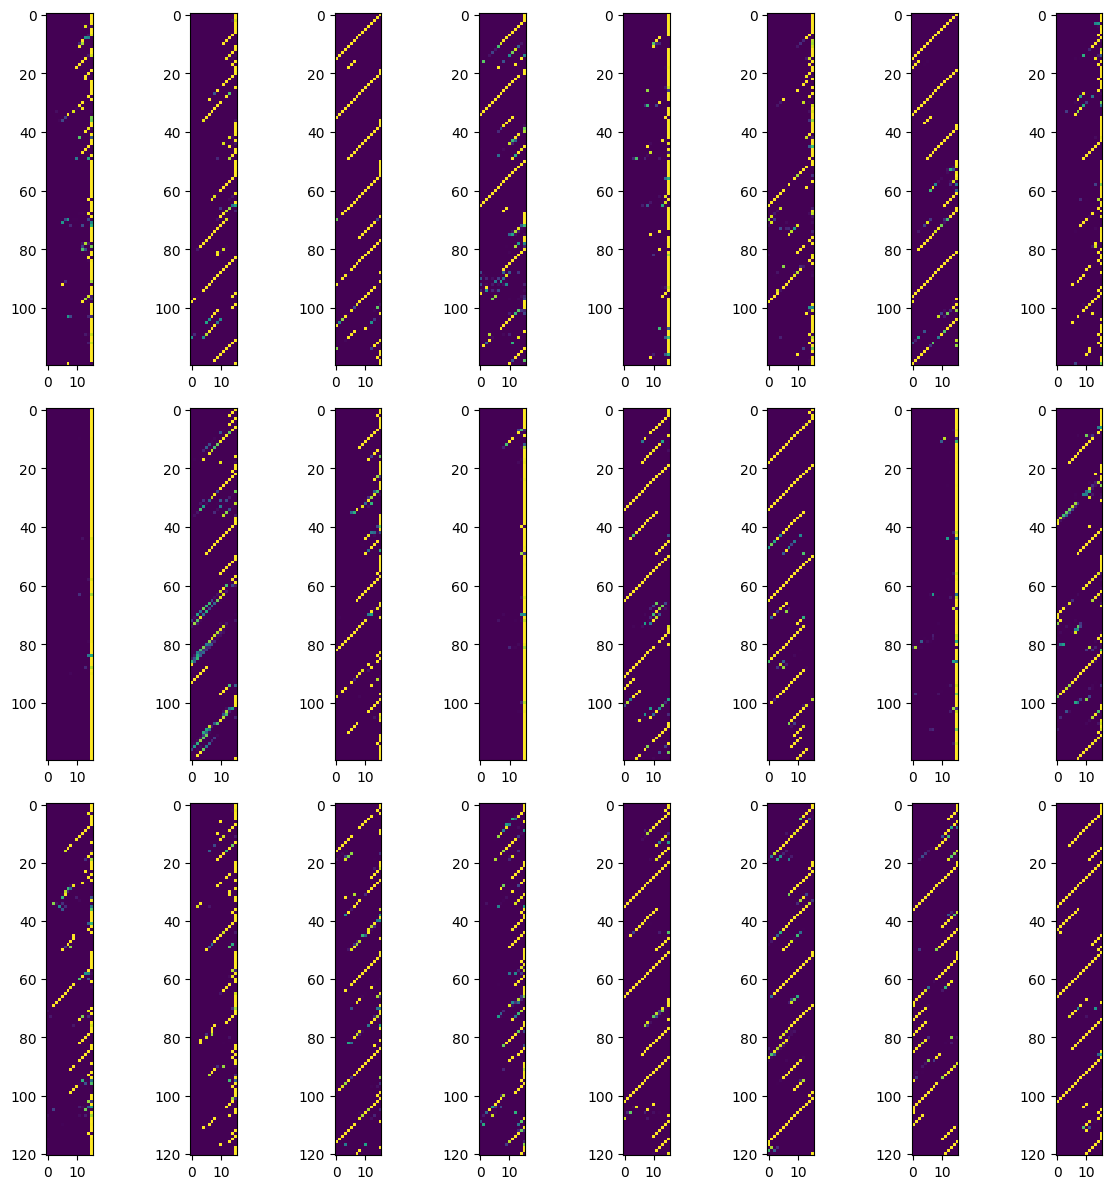

In [93]:
plt.figure()
ln = flags.tran_layer_n

f, axarr = plt.subplots(ln,8, figsize=(12,12)) 
for k in range(ln):
    for i in range(8):
        out = net_out["attn_%d"%k][:, i, 0]
        #out = out-torch.max(out, dim=-1, keepdim=True)[0]
        #out = net_out["attn_mask"][:, 1, 0]
        #out = net_out["policy_logits"][:, 0, :]
        #out =  F.one_hot(net_out["action"], 5)[:, 0, :]
        out = out.detach().cpu().numpy()
        axarr[k, i].imshow(out, interpolation='nearest')
f.tight_layout()    

In [ ]:
for k, p in net.named_parameters():
    print(k, p.numel())

In [ ]:
np.set_printoptions(suppress=True)
#print(torch.softmax(net_out["policy_logits"][:, 0, :], dim=-1).detach().numpy())

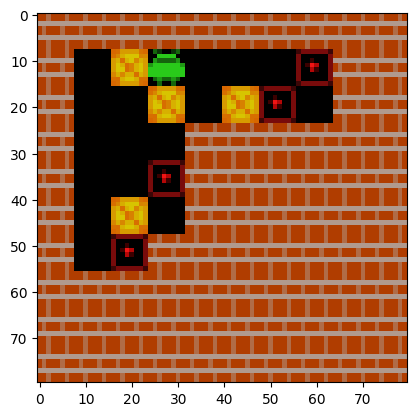

Step: 0
action:  tensor([2], device='cuda:0')


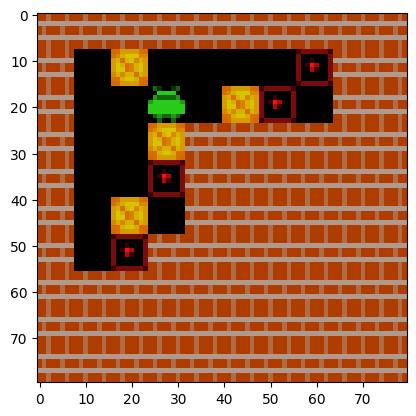

Step: 1
action:  tensor([3], device='cuda:0')


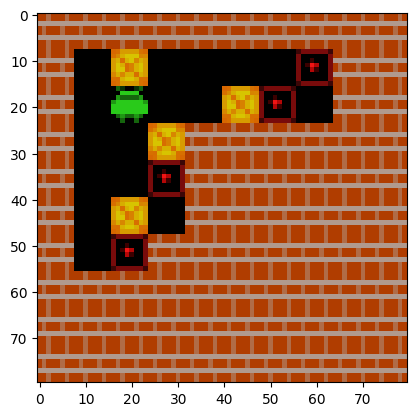

Step: 2
action:  tensor([3], device='cuda:0')


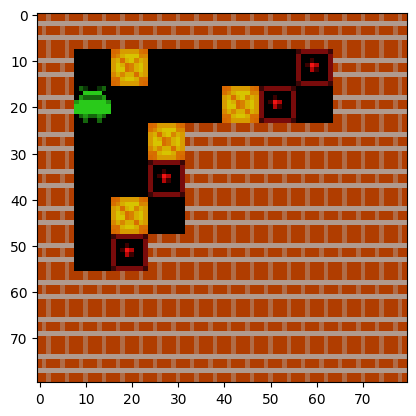

Step: 3
action:  tensor([1], device='cuda:0')


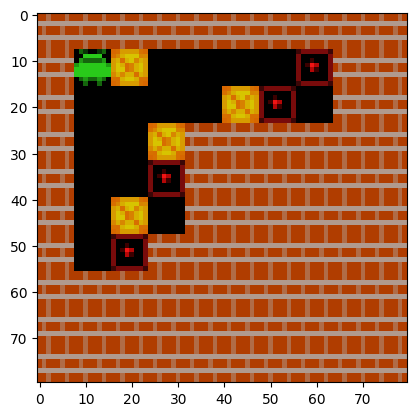

Step: 4
action:  tensor([4], device='cuda:0')


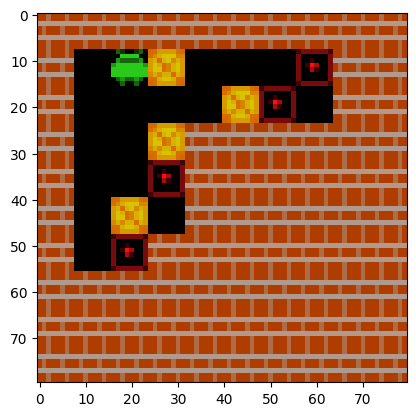

Step: 5
action:  tensor([4], device='cuda:0')


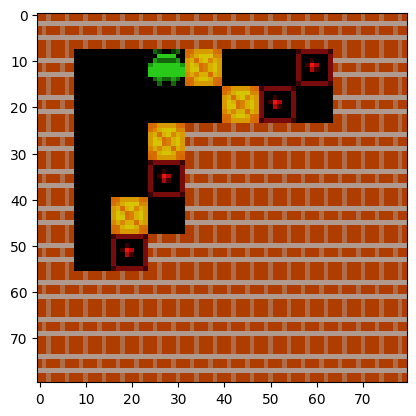

Step: 6
action:  tensor([4], device='cuda:0')


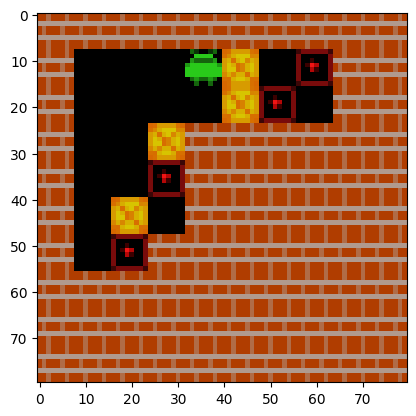

Step: 7
action:  tensor([4], device='cuda:0')


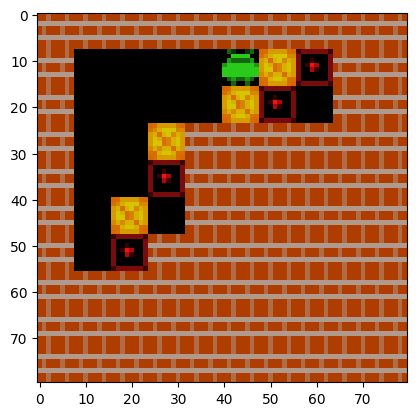

Step: 8
action:  tensor([4], device='cuda:0')


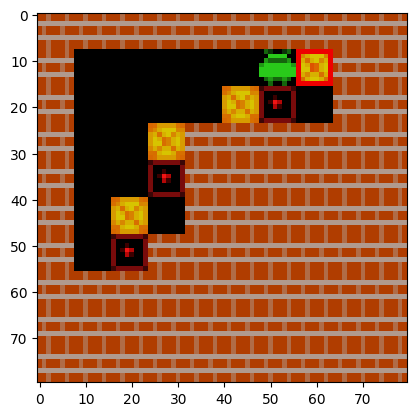

Step: 9
action:  tensor([3], device='cuda:0')


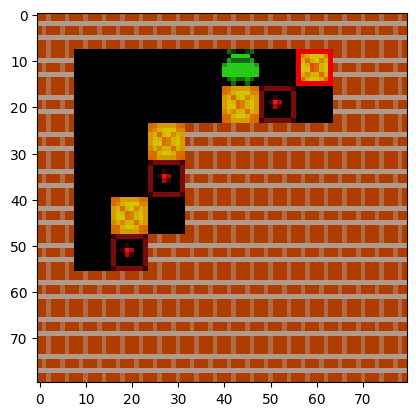

Step: 10
action:  tensor([3], device='cuda:0')


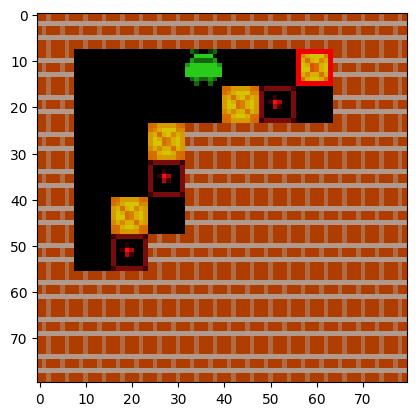

Step: 11
action:  tensor([2], device='cuda:0')


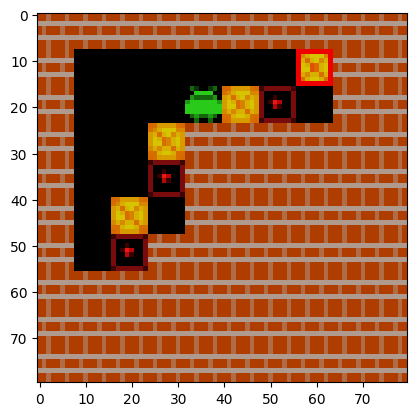

Step: 12
action:  tensor([4], device='cuda:0')


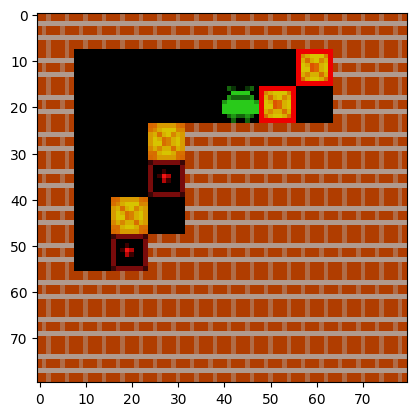

Step: 13
action:  tensor([3], device='cuda:0')


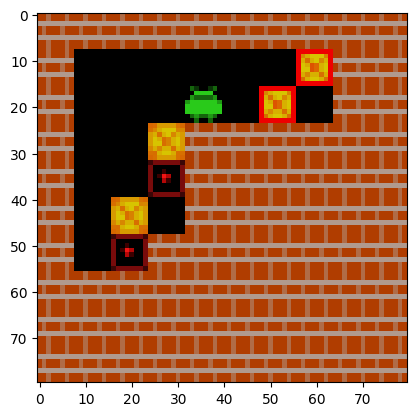

Step: 14
action:  tensor([3], device='cuda:0')


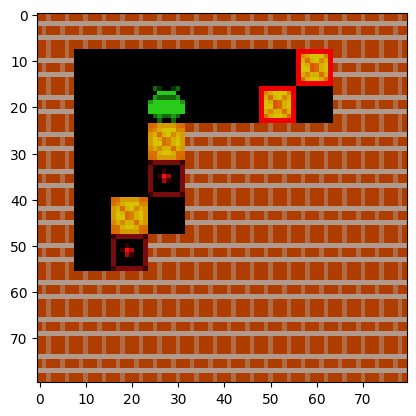

Step: 15
action:  tensor([2], device='cuda:0')


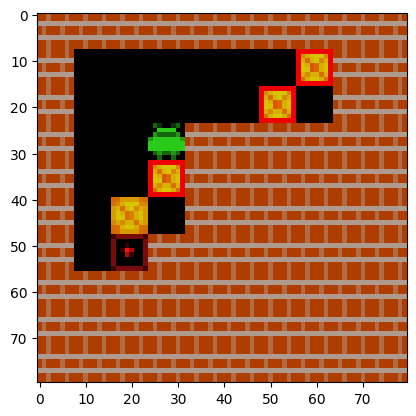

Step: 16
action:  tensor([3], device='cuda:0')


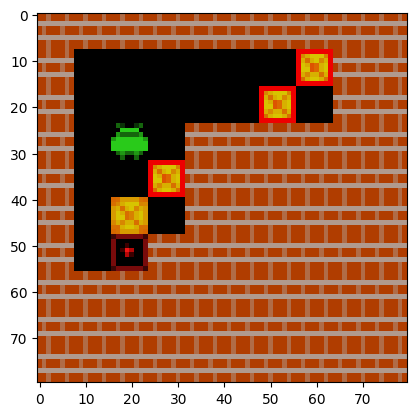

Step: 17
action:  tensor([2], device='cuda:0')


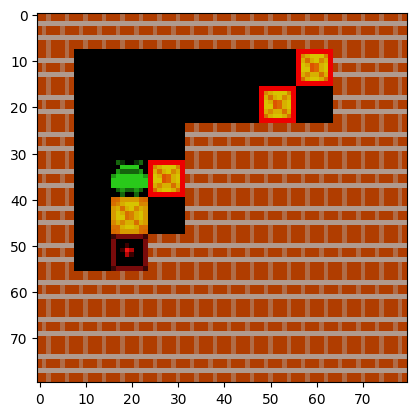

Step: 18
action:  tensor([2], device='cuda:0')


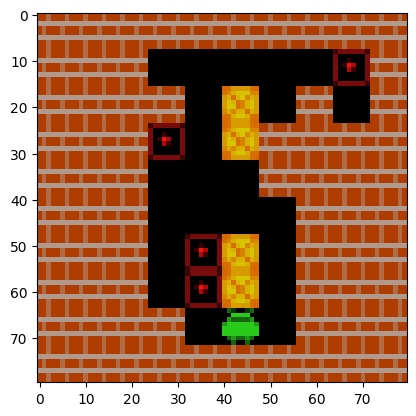

Step: 19
action:  tensor([4], device='cuda:0')


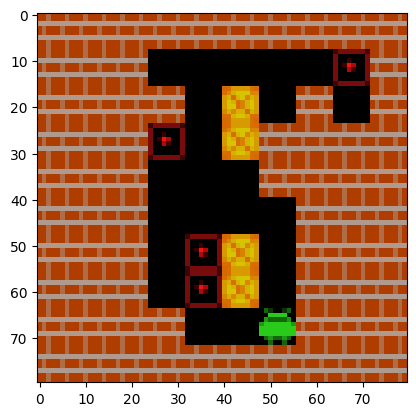

Step: 20
action:  tensor([1], device='cuda:0')


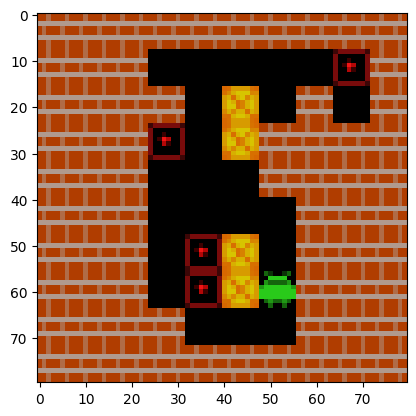

Step: 21
action:  tensor([3], device='cuda:0')


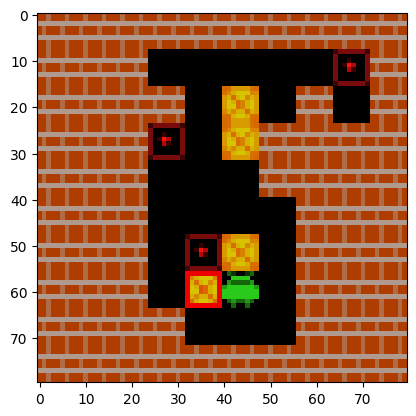

Step: 22
action:  tensor([4], device='cuda:0')


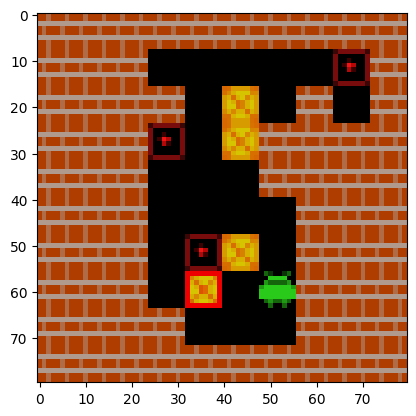

Step: 23
action:  tensor([1], device='cuda:0')


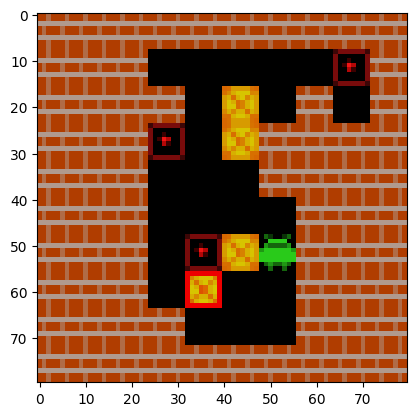

Step: 24
action:  tensor([3], device='cuda:0')


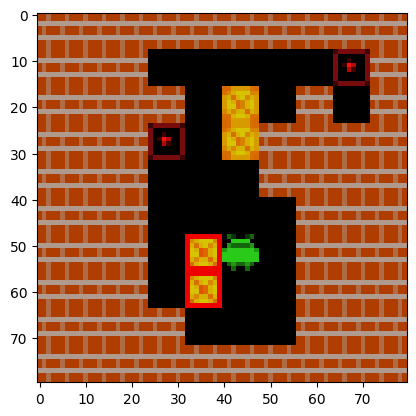

Step: 25
action:  tensor([1], device='cuda:0')


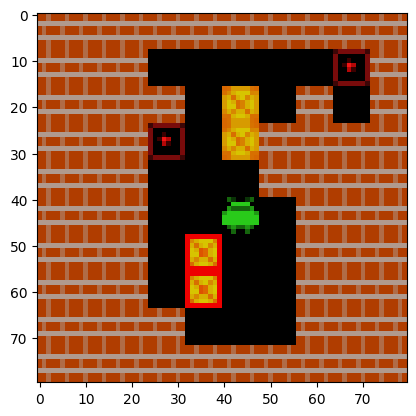

Step: 26
action:  tensor([1], device='cuda:0')


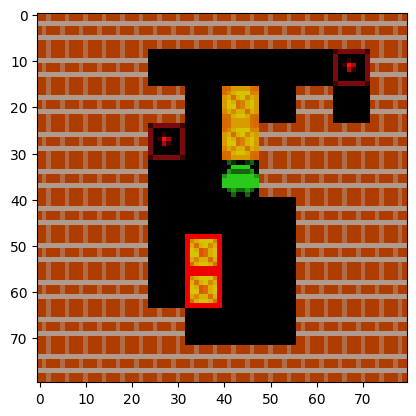

Step: 27
action:  tensor([3], device='cuda:0')


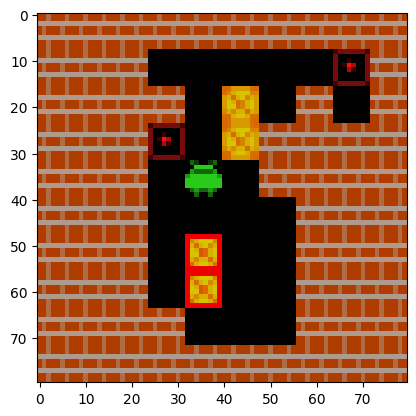

Step: 28
action:  tensor([1], device='cuda:0')


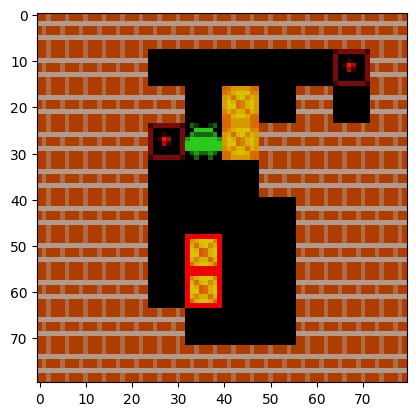

Step: 29
action:  tensor([1], device='cuda:0')


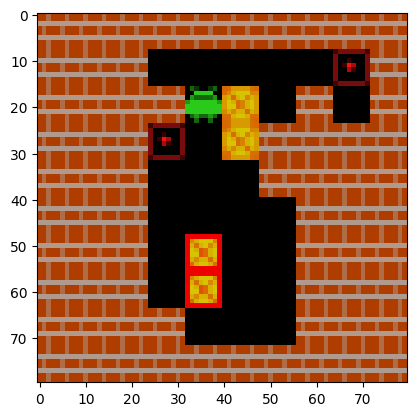

Step: 30
action:  tensor([1], device='cuda:0')


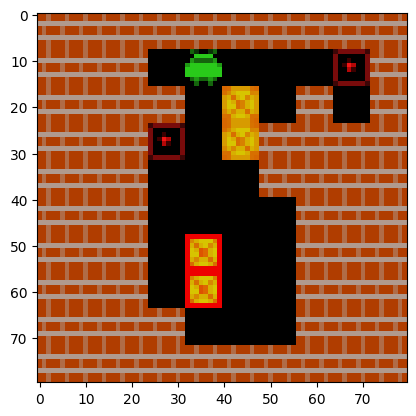

Step: 31
action:  tensor([4], device='cuda:0')


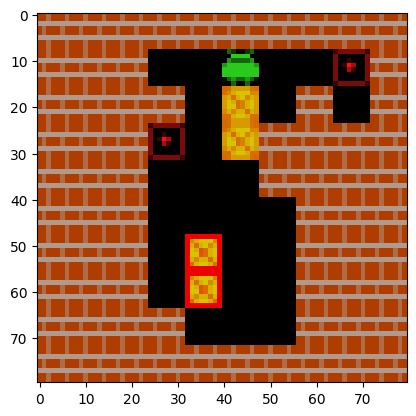

Step: 32
action:  tensor([4], device='cuda:0')


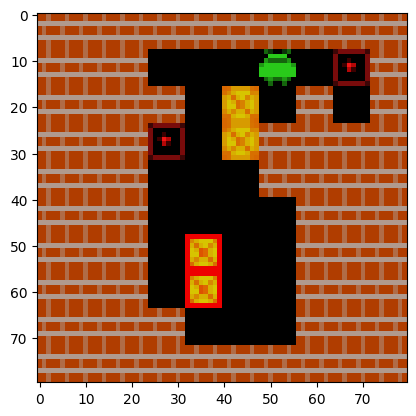

Step: 33
action:  tensor([2], device='cuda:0')


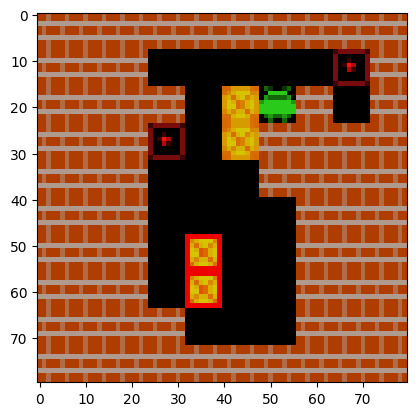

Step: 34
action:  tensor([3], device='cuda:0')


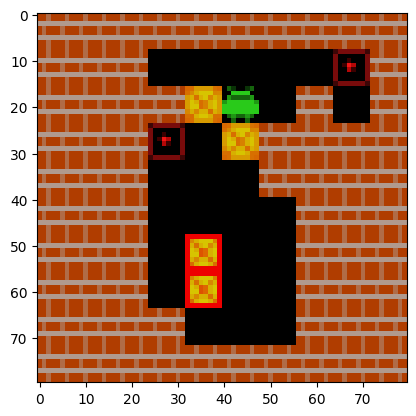

Step: 35
action:  tensor([1], device='cuda:0')


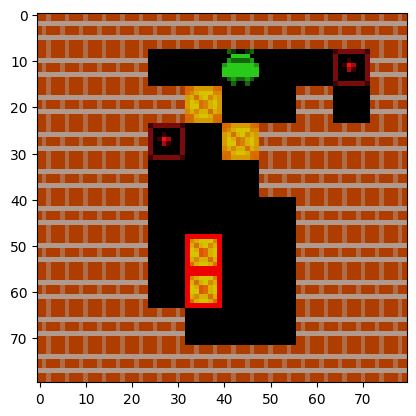

Step: 36
action:  tensor([3], device='cuda:0')


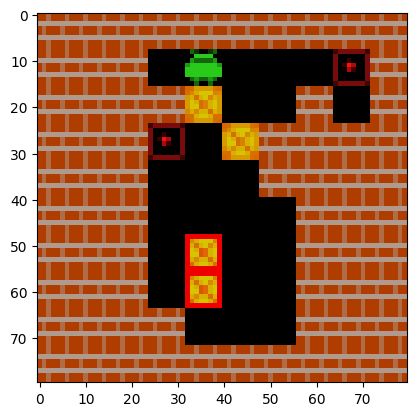

Step: 37
action:  tensor([2], device='cuda:0')


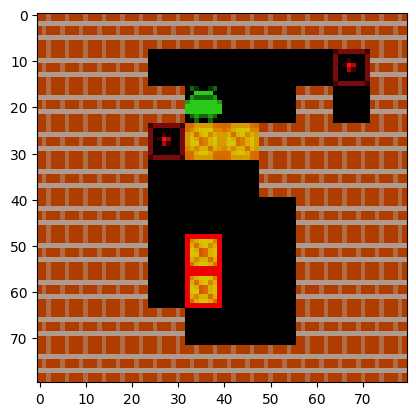

Step: 38
action:  tensor([1], device='cuda:0')


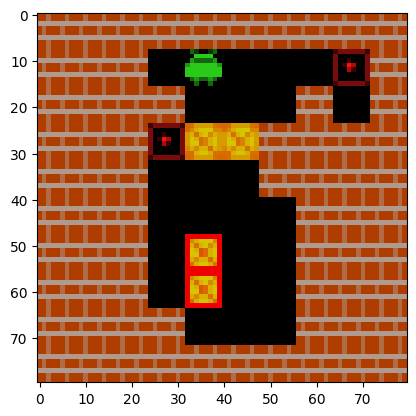

Step: 39
action:  tensor([2], device='cuda:0')


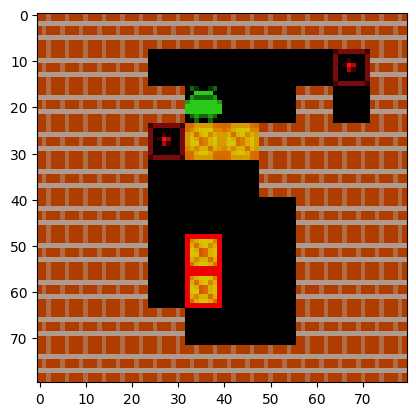

Step: 40
action:  tensor([2], device='cuda:0')


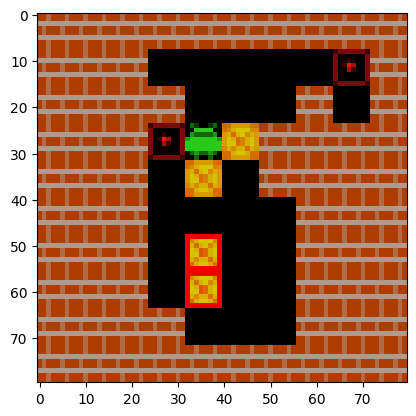

Step: 41
action:  tensor([3], device='cuda:0')


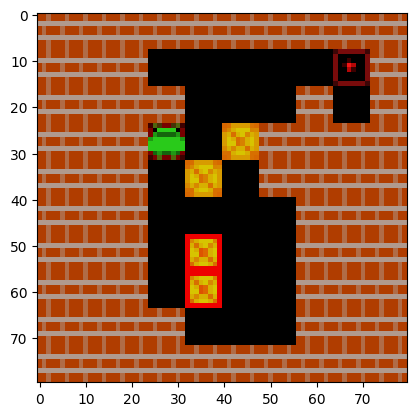

Step: 42
action:  tensor([2], device='cuda:0')


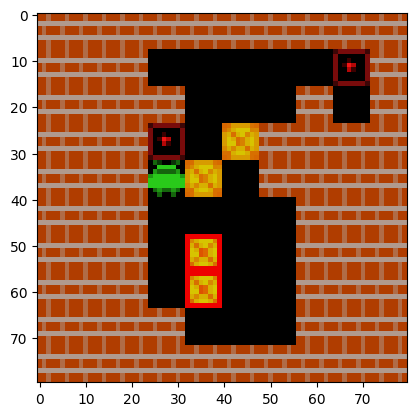

Step: 43
action:  tensor([2], device='cuda:0')


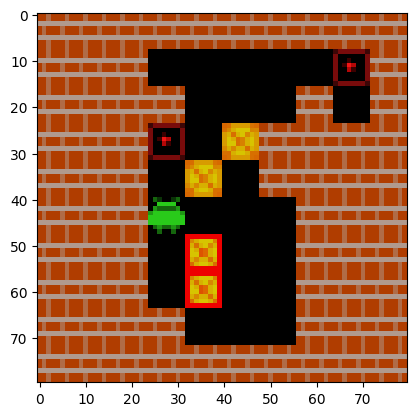

Step: 44
action:  tensor([4], device='cuda:0')


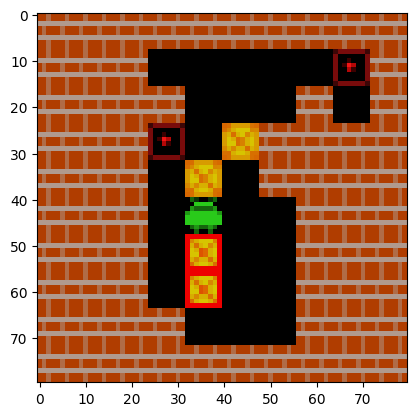

Step: 45
action:  tensor([1], device='cuda:0')


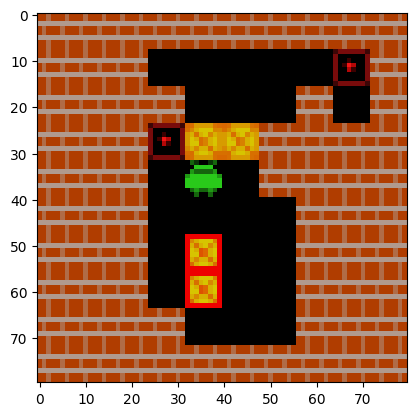

Step: 46
action:  tensor([4], device='cuda:0')


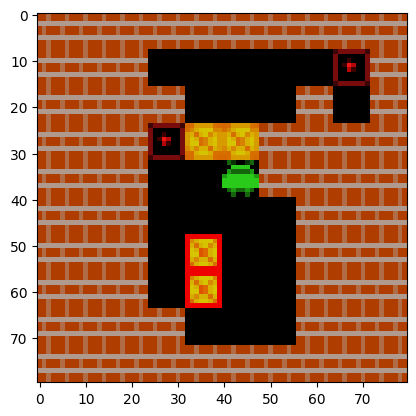

Step: 47
action:  tensor([1], device='cuda:0')


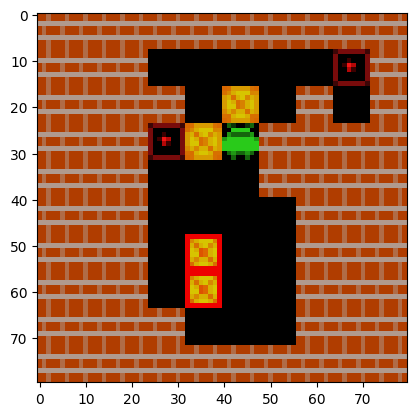

Step: 48
action:  tensor([3], device='cuda:0')


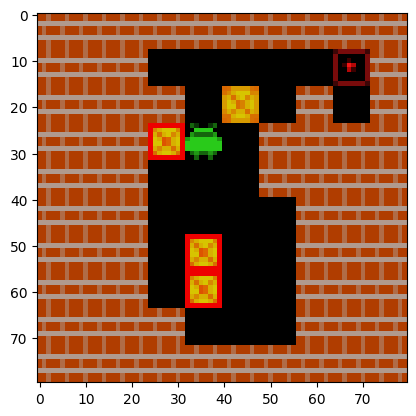

Step: 49
action:  tensor([4], device='cuda:0')


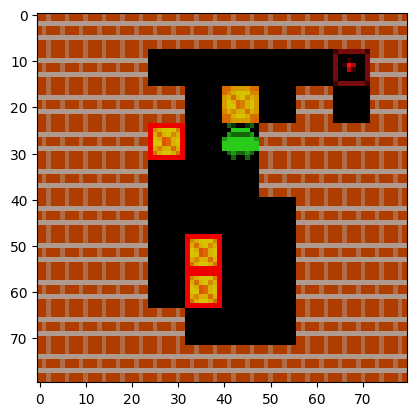

Step: 50
action:  tensor([1], device='cuda:0')


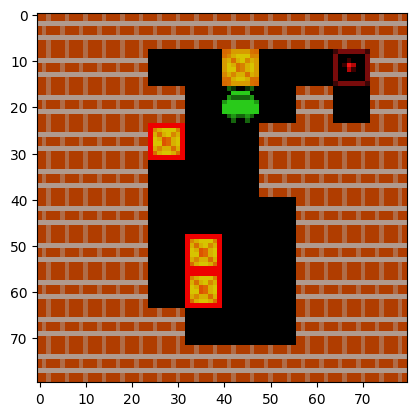

Step: 51
action:  tensor([3], device='cuda:0')


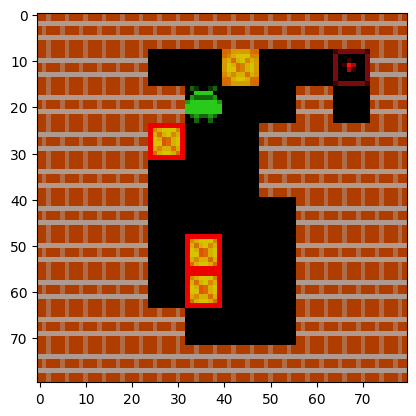

Step: 52
action:  tensor([1], device='cuda:0')


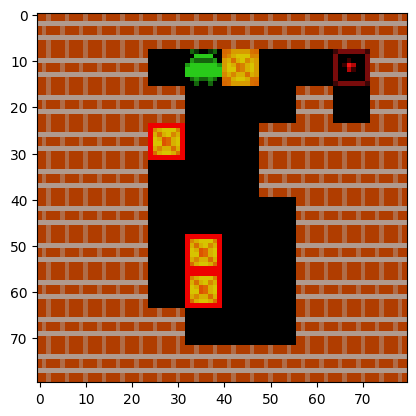

Step: 53
action:  tensor([4], device='cuda:0')


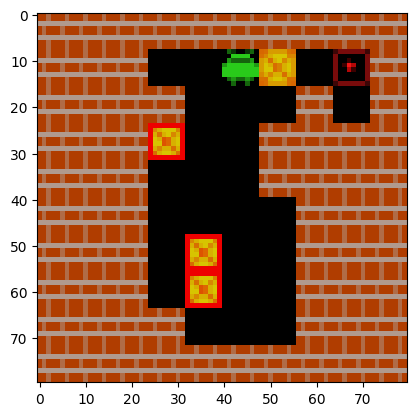

Step: 54
action:  tensor([4], device='cuda:0')


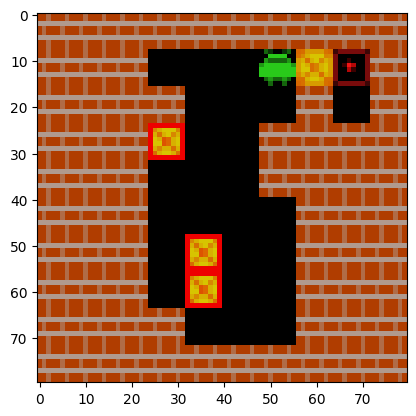

Step: 55
action:  tensor([4], device='cuda:0')


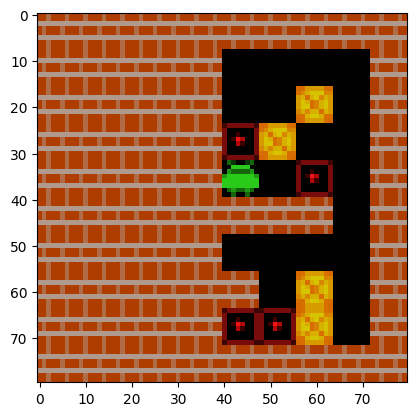

Step: 56
action:  tensor([4], device='cuda:0')


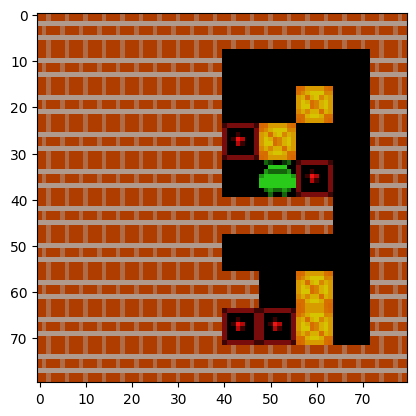

Step: 57
action:  tensor([4], device='cuda:0')


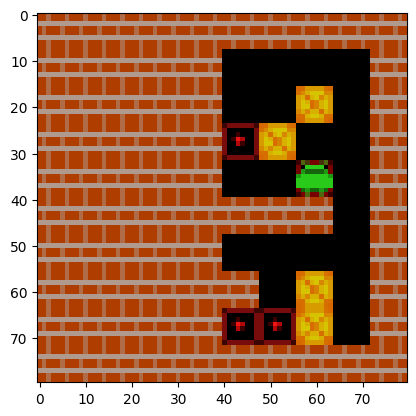

Step: 58
action:  tensor([1], device='cuda:0')


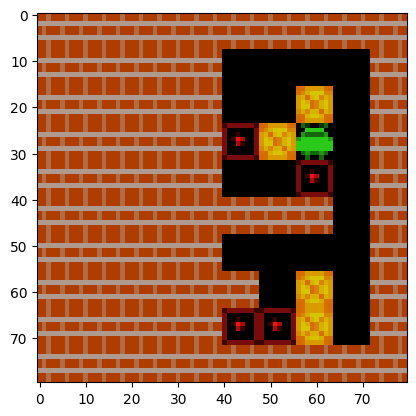

Step: 59
action:  tensor([3], device='cuda:0')


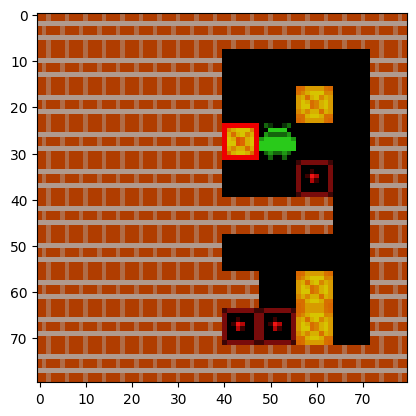

Step: 60
action:  tensor([1], device='cuda:0')


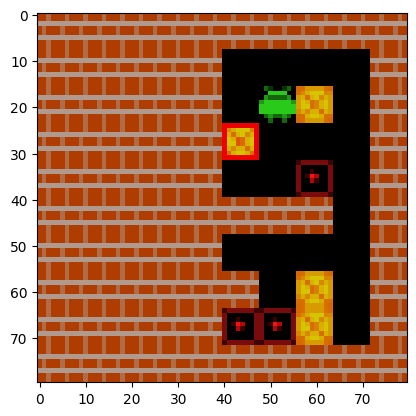

Step: 61
action:  tensor([1], device='cuda:0')


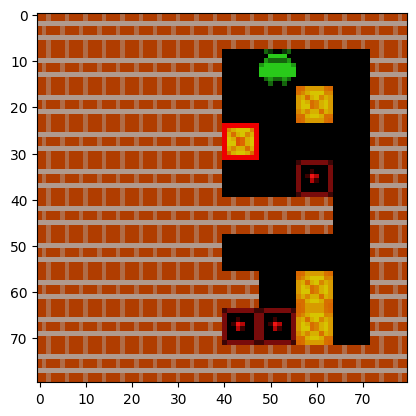

Step: 62
action:  tensor([4], device='cuda:0')


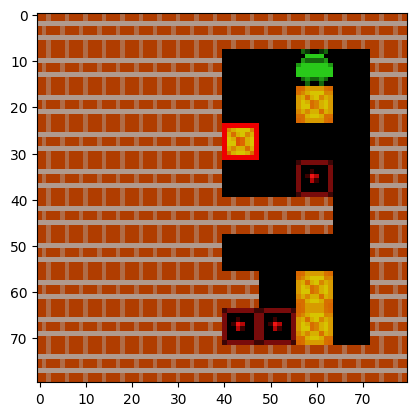

Step: 63
action:  tensor([2], device='cuda:0')


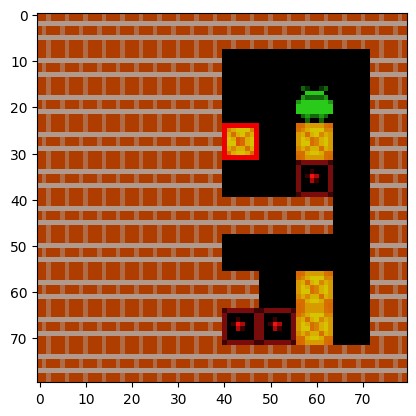

Step: 64
action:  tensor([2], device='cuda:0')


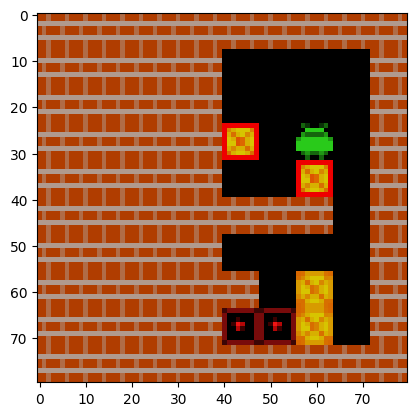

Step: 65
action:  tensor([4], device='cuda:0')


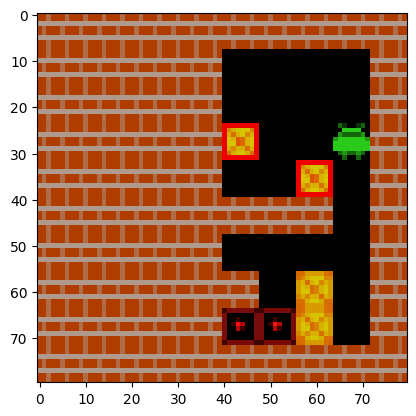

Step: 66
action:  tensor([2], device='cuda:0')


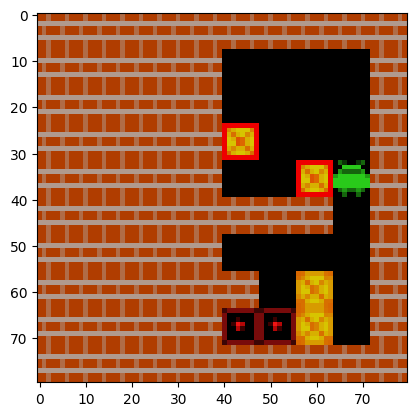

Step: 67
action:  tensor([2], device='cuda:0')


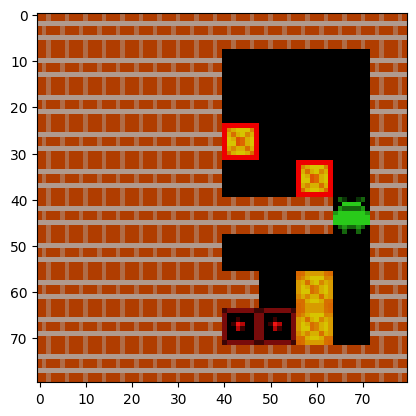

Step: 68
action:  tensor([2], device='cuda:0')


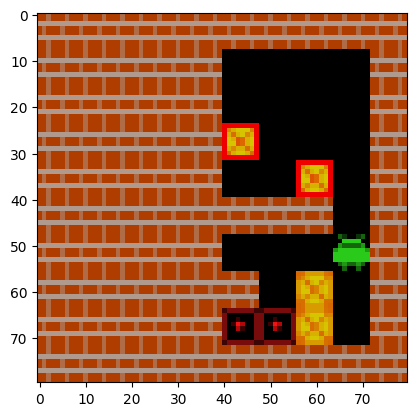

Step: 69
action:  tensor([2], device='cuda:0')


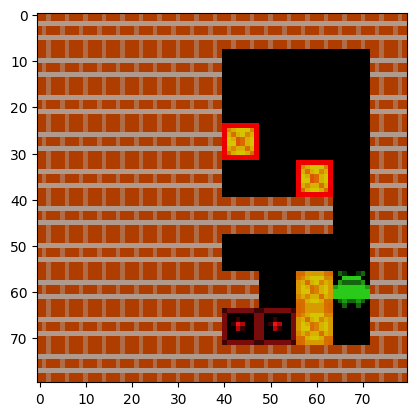

Step: 70
action:  tensor([2], device='cuda:0')


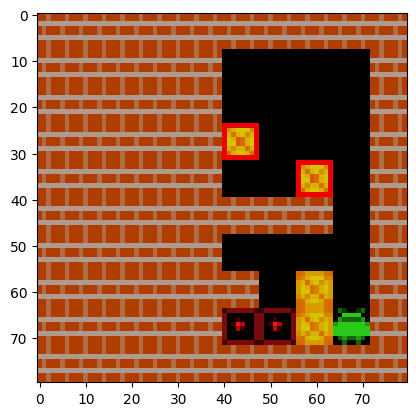

Step: 71
action:  tensor([3], device='cuda:0')


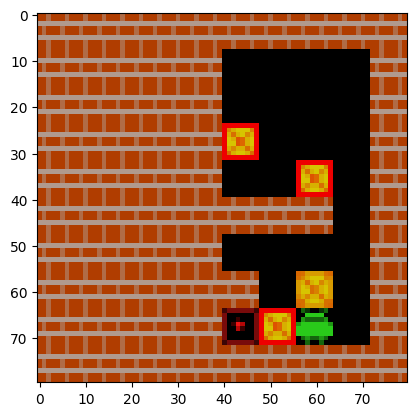

Step: 72
action:  tensor([3], device='cuda:0')


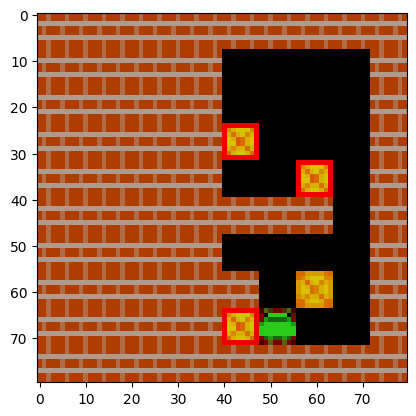

Step: 73
action:  tensor([4], device='cuda:0')


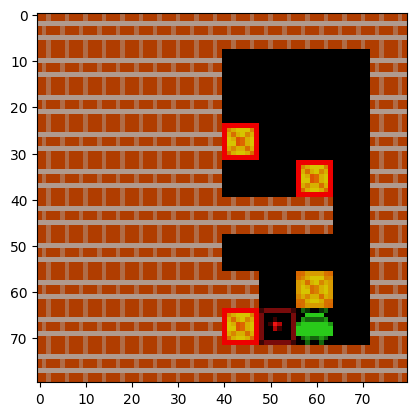

Step: 74
action:  tensor([4], device='cuda:0')


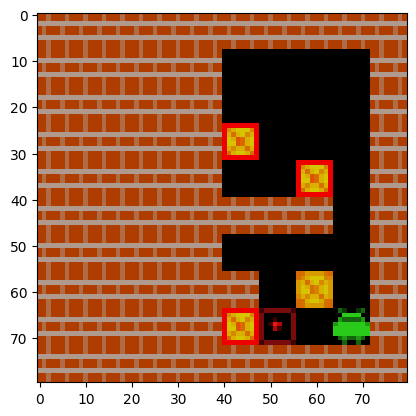

Step: 75
action:  tensor([1], device='cuda:0')


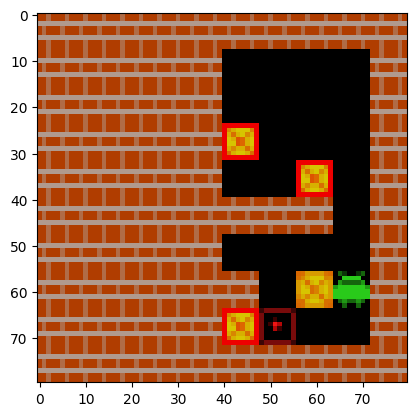

Step: 76
action:  tensor([3], device='cuda:0')


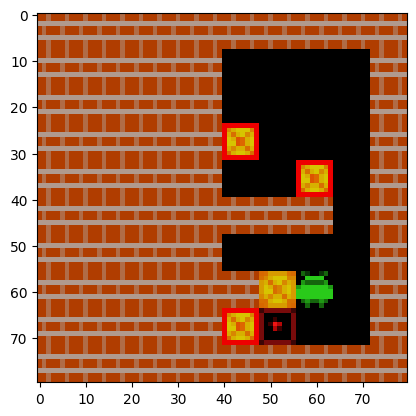

Step: 77
action:  tensor([1], device='cuda:0')


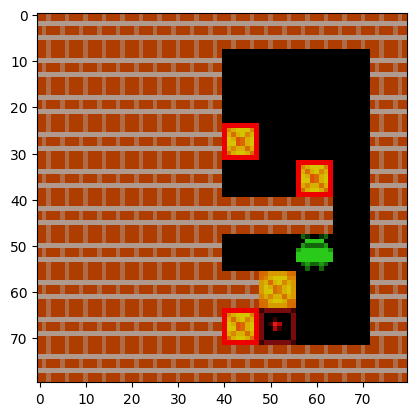

Step: 78
action:  tensor([3], device='cuda:0')


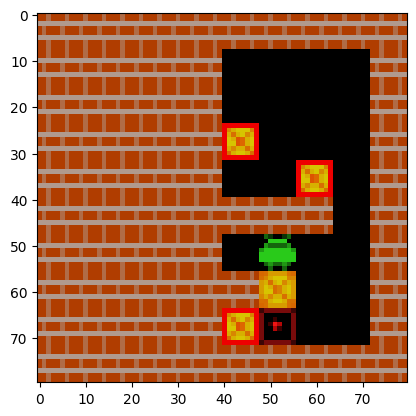

Step: 79
action:  tensor([2], device='cuda:0')


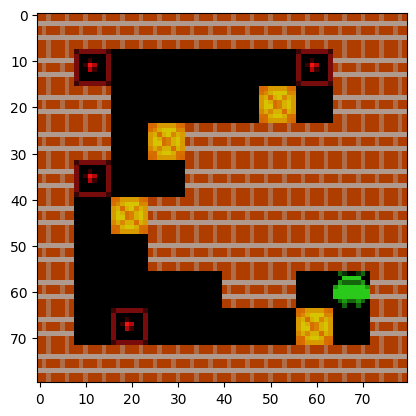

Step: 80
action:  tensor([2], device='cuda:0')


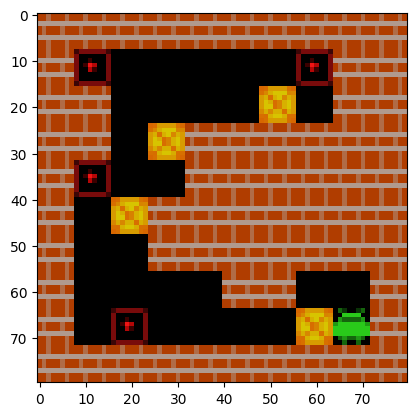

Step: 81
action:  tensor([3], device='cuda:0')


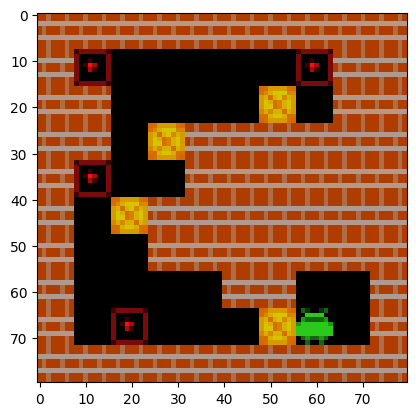

Step: 82
action:  tensor([3], device='cuda:0')


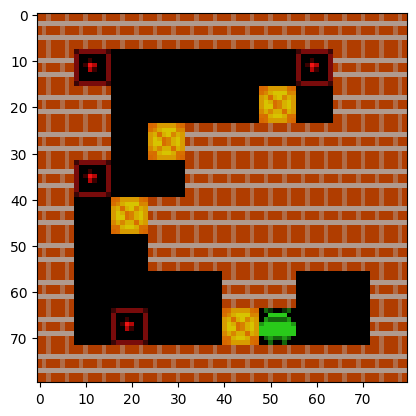

Step: 83
action:  tensor([3], device='cuda:0')


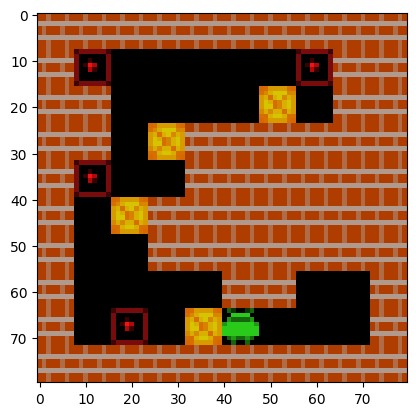

Step: 84
action:  tensor([3], device='cuda:0')


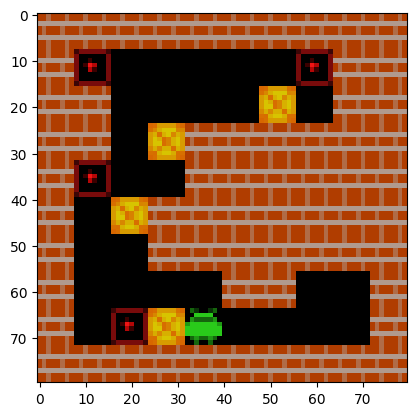

Step: 85
action:  tensor([3], device='cuda:0')


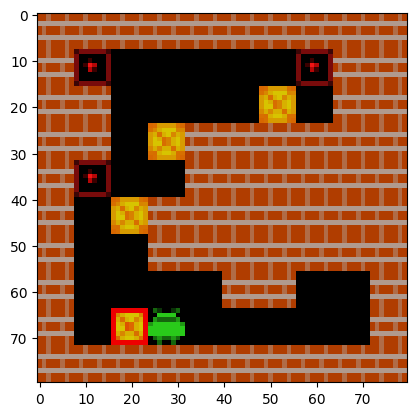

Step: 86
action:  tensor([1], device='cuda:0')


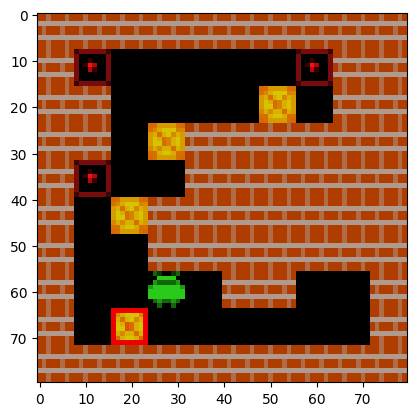

Step: 87
action:  tensor([3], device='cuda:0')


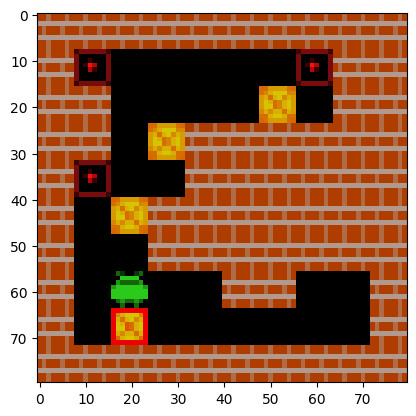

Step: 88
action:  tensor([1], device='cuda:0')


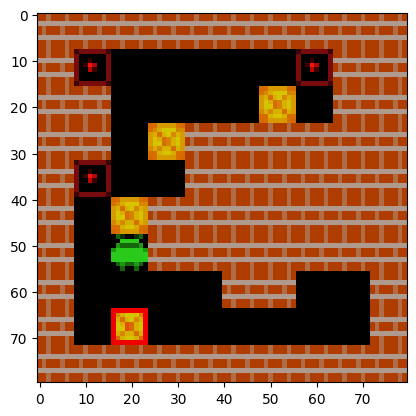

Step: 89
action:  tensor([1], device='cuda:0')


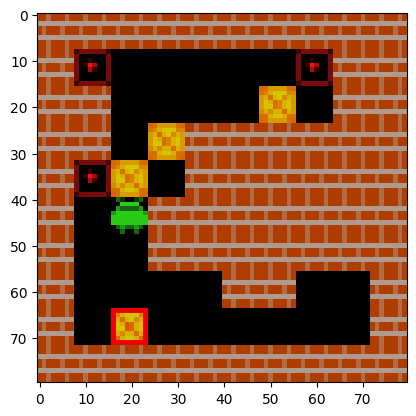

Step: 90
action:  tensor([1], device='cuda:0')


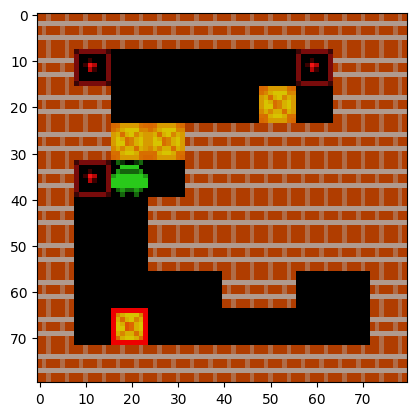

Step: 91
action:  tensor([4], device='cuda:0')


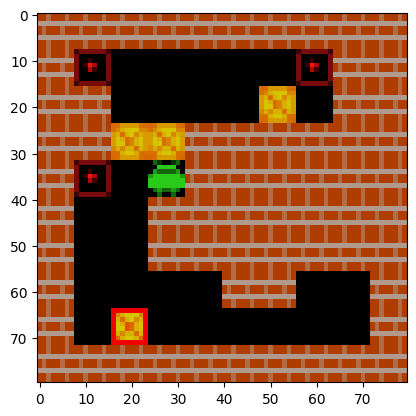

Step: 92
action:  tensor([1], device='cuda:0')


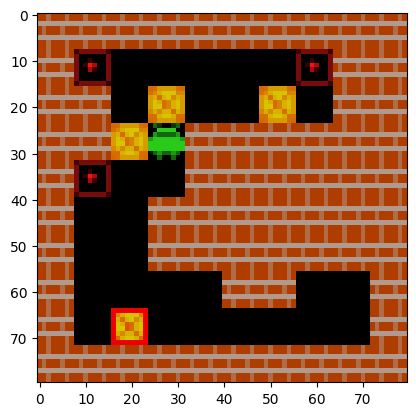

Step: 93
action:  tensor([1], device='cuda:0')


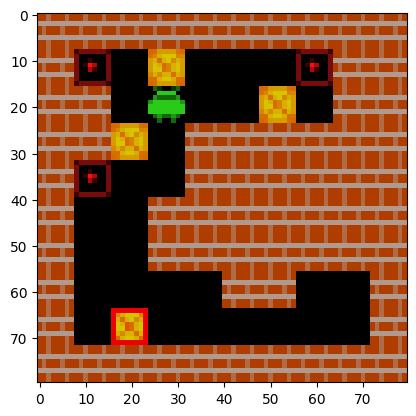

Step: 94
action:  tensor([3], device='cuda:0')


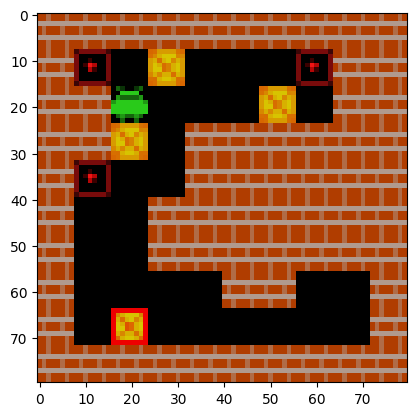

Step: 95
action:  tensor([2], device='cuda:0')


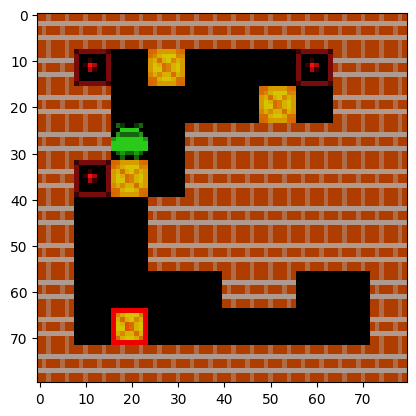

Step: 96
action:  tensor([4], device='cuda:0')


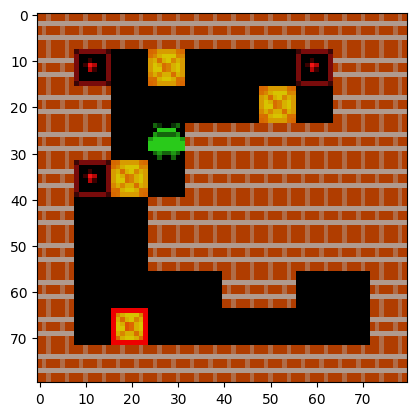

Step: 97
action:  tensor([2], device='cuda:0')


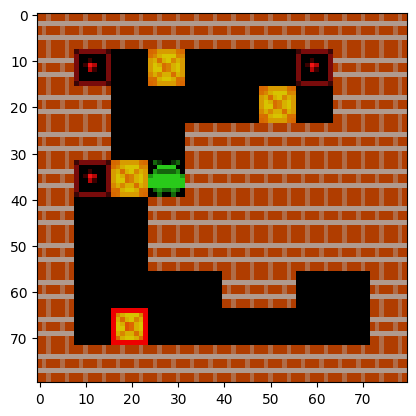

Step: 98
action:  tensor([3], device='cuda:0')


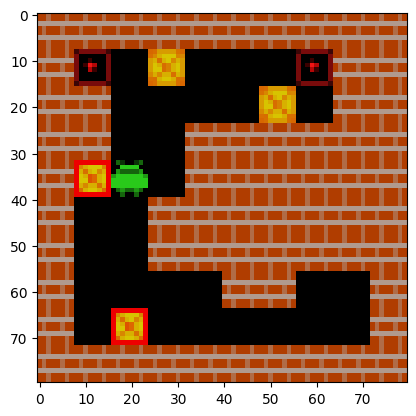

Step: 99
action:  tensor([1], device='cuda:0')


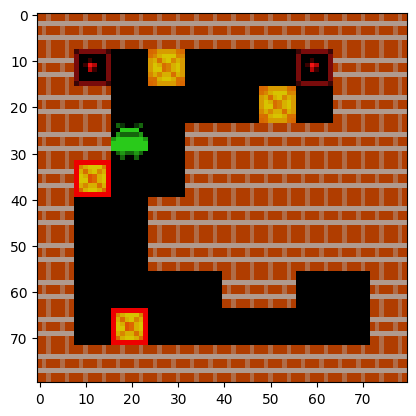

Step: 100
action:  tensor([1], device='cuda:0')


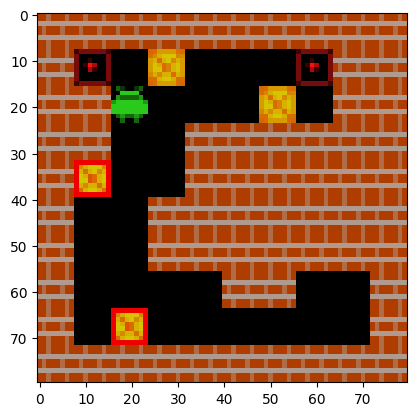

Step: 101
action:  tensor([4], device='cuda:0')


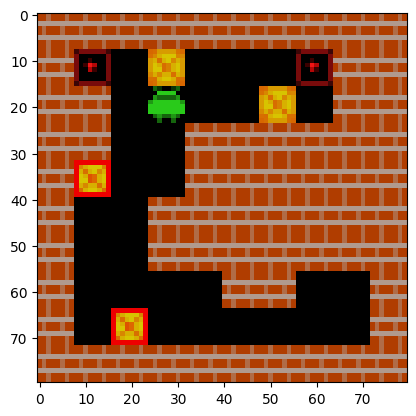

Step: 102
action:  tensor([4], device='cuda:0')


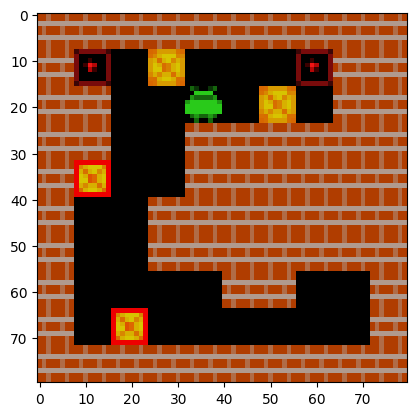

Step: 103
action:  tensor([1], device='cuda:0')


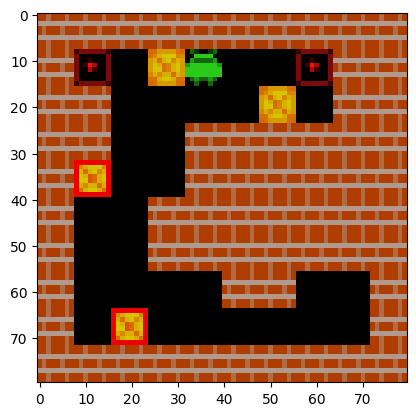

Step: 104
action:  tensor([3], device='cuda:0')


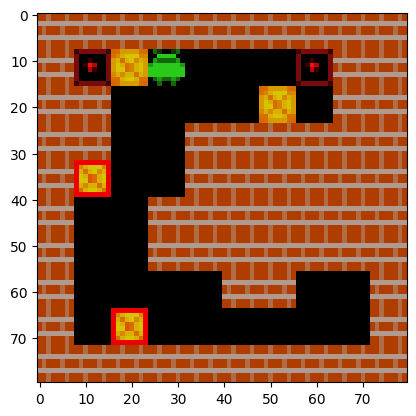

Step: 105
action:  tensor([3], device='cuda:0')


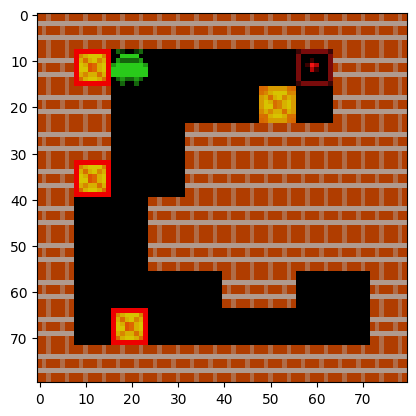

Step: 106
action:  tensor([4], device='cuda:0')


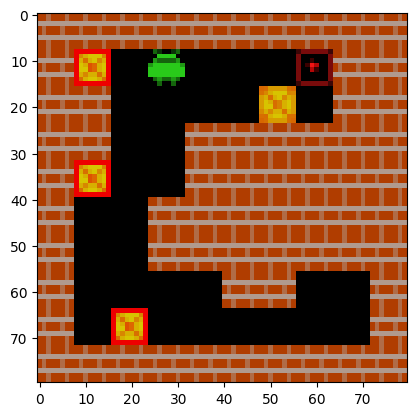

Step: 107
action:  tensor([4], device='cuda:0')


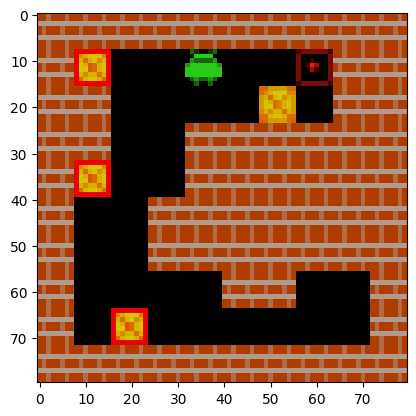

Step: 108
action:  tensor([4], device='cuda:0')


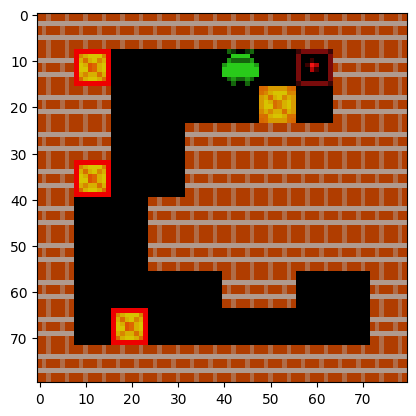

Step: 109
action:  tensor([4], device='cuda:0')


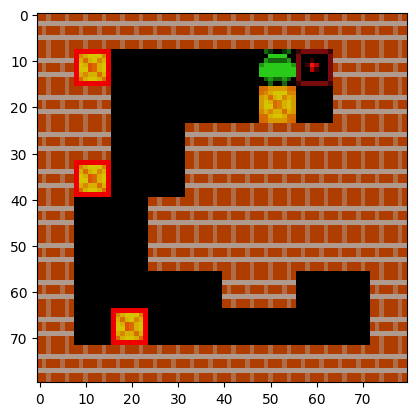

Step: 110
action:  tensor([4], device='cuda:0')


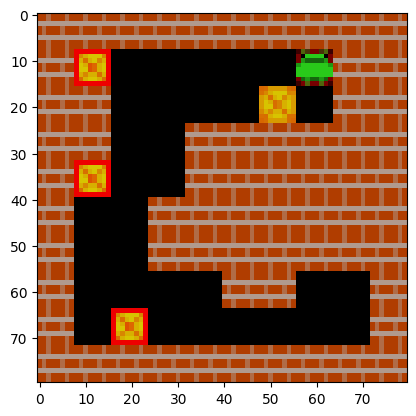

Step: 111
action:  tensor([2], device='cuda:0')


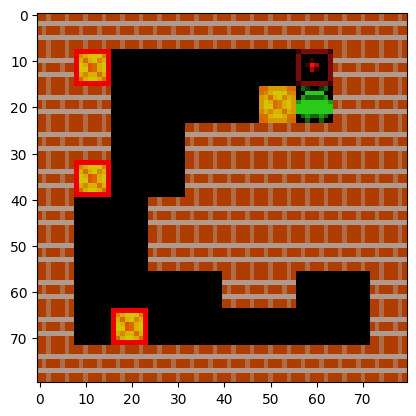

Step: 112
action:  tensor([3], device='cuda:0')


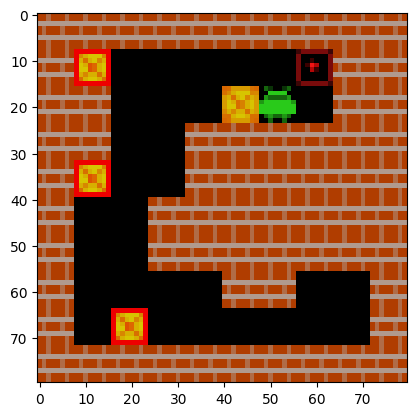

Step: 113
action:  tensor([3], device='cuda:0')


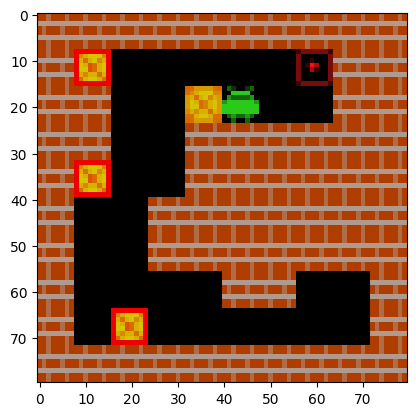

Step: 114
action:  tensor([3], device='cuda:0')


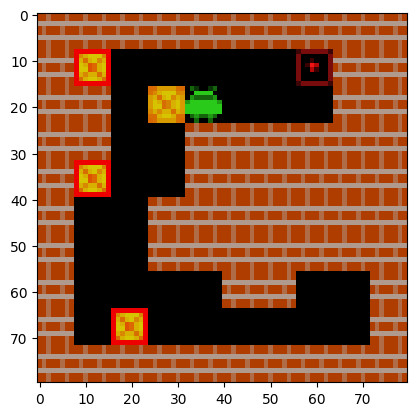

Step: 115
action:  tensor([1], device='cuda:0')


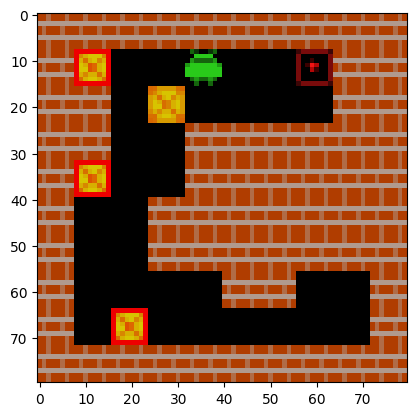

Step: 116
action:  tensor([3], device='cuda:0')


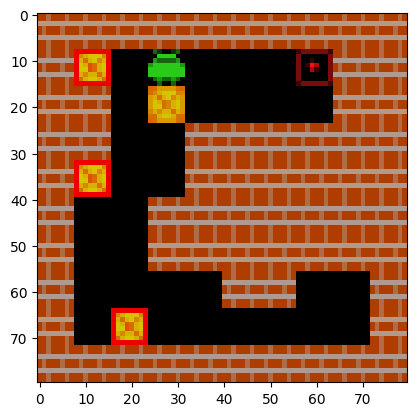

Step: 117
action:  tensor([3], device='cuda:0')


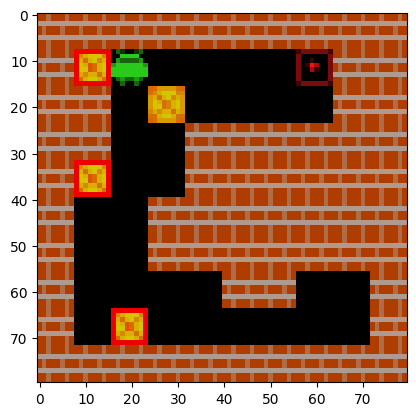

Step: 118
action:  tensor([2], device='cuda:0')


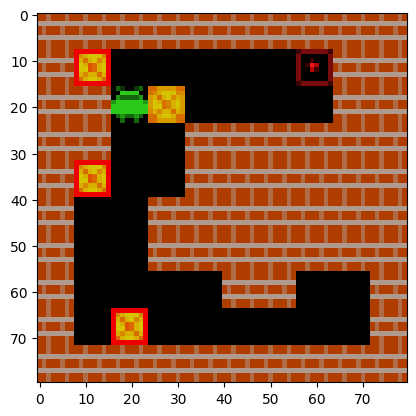

KeyboardInterrupt: 

In [88]:
# Batch version of testing model

env = atari_wrappers.SokobanWrapper(gym.make("Sokoban-v0"), noop=not flags.env_disable_noop)
env = environment.Environment(env)
obs = env.initial()
core_state = net.initial_state(batch_size=1)
core_state = tuple(v.to(device) for v in core_state)

plt.imshow(torch.swapaxes(torch.swapaxes(obs["frame"][0,0],0,2),0,1), interpolation='nearest')
plt.show()

net.train(False)

for i in range(120):
    core_state = net.initial_state(batch_size=1)
    core_state = tuple(v.to(device) for v in core_state)
    obs = {k:v.clone().to(device) for k, v in obs.items()}
    net_out_, core_state = net(obs, core_state, debug=True)        
    obs_copy = obs
    core_state_copy = core_state
        
    print("Step: %d" % i)        
    obs_ = env.step(net_out_["action"][-1])
    obs_["last_action"] = obs_["last_action"].unsqueeze(0)
    
    obs = {k: torch.concat([obs[k], obs_[k].to(device)]) for k in obs.keys()}
    print("action: ", net_out_["action"][-1])
    if i > 0:
        net_out = {k: torch.concat([net_out[k], net_out_[k][[-1]]]) for k in net_out.keys()}
    else:
        net_out = net_out_           
        
    plt.imshow(torch.swapaxes(torch.swapaxes(obs_["frame"][0,0],0,2),0,1), interpolation='nearest')
    plt.show()

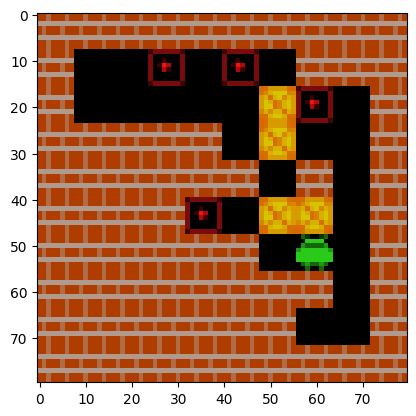

Step: 0
action:  tensor([3], device='cuda:0')
Step: 1
action:  tensor([4], device='cuda:0')
Step: 2
action:  tensor([4], device='cuda:0')
Step: 3
action:  tensor([1], device='cuda:0')
Step: 4
action:  tensor([1], device='cuda:0')
Step: 5
action:  tensor([1], device='cuda:0')
Step: 6
action:  tensor([3], device='cuda:0')
Step: 7
action:  tensor([1], device='cuda:0')
Step: 8
action:  tensor([3], device='cuda:0')
Step: 9
action:  tensor([1], device='cuda:0')
Checking:  tensor(6.0972e-12, device='cuda:0', grad_fn=<SumBackward0>)


In [89]:
# Check if batch input is same as sequential input

env = atari_wrappers.SokobanWrapper(gym.make("Sokoban-v0"), noop=not flags.env_disable_noop)
env = environment.Environment(env)
obs = env.initial()
core_state = net.initial_state(batch_size=1)

plt.imshow(torch.swapaxes(torch.swapaxes(obs["frame"][0,0],0,2),0,1), interpolation='nearest')
plt.show()

net.train(False)

for i in range(10):
    core_state = net.initial_state(batch_size=1)
    core_state = tuple(v.to(device) for v in core_state)
    obs = {k:v.clone().to(device) for k, v in obs.items()}
    net_out_, core_state = net(obs, core_state, debug=True)        
    obs_copy = obs
    core_state_copy = core_state
        
    print("Step: %d" % i)        
    obs_ = env.step(net_out_["action"][-1])
    obs_["last_action"] = obs_["last_action"].unsqueeze(0)
    
    if i == 5: obs_["done"][:] = True    
    obs = {k: torch.concat([obs[k], obs_[k].to(device)]) for k in obs.keys()}
    print("action: ", net_out_["action"][-1])
    if i > 0:
        net_out = {k: torch.concat([net_out[k], net_out_[k][[-1]]]) for k in net_out.keys()}
    else:
        net_out = net_out_                
        
core_state = net.initial_state(batch_size=1)  
core_state = tuple(v.to(device) for v in core_state)
for i in range(10):        
    net_input = {k: obs[k][[i]].to(device) for k in obs.keys()}
    net_out_test_, core_state = net(net_input, core_state, debug=True)    
    if i > 0:
        net_out_test = {k: torch.concat([net_out_test[k], net_out_test_[k][[-1]]]) for k in net_out_test_.keys()}
    else:
        net_out_test = net_out_test_
        
print("Checking: ", torch.sum(torch.square(net_out['policy_logits'] - net_out_test['policy_logits'])),)
                 

In [ ]:
# testing whether the transformer (1, 1) with tran_mem_n = 1 matches with a simple conv. test net

def add_hw(x, h, w):
    return x.unsqueeze(-1).unsqueeze(-1).broadcast_to(x.shape + (h,w))

def avg_last_ch(x):    
    last_mean = torch.mean(x[:, [-1]], dim=(-1, -2))
    last_mean = add_hw(last_mean, x.shape[2], x.shape[3])
    return torch.cat([x[:, :-1], last_mean], dim=1)    

class AtariNet(nn.Module):
    def __init__(self, observation_shape, num_actions, flags):

        super(AtariNet, self).__init__()
        self.observation_shape = observation_shape
        self.num_actions = num_actions  
        self.tran_t = flags.tran_t
        
        self.conv_out = 32
        self.conv_out_hw = 8
        self.d_model = 32
        self.model = flags.use_model
        self.pos_n = 32
        
        self.conv1 = nn.Conv2d(in_channels=self.observation_shape[0], out_channels=32, kernel_size=8, stride=4)        
        self.conv2 = nn.Conv2d(32, 32, kernel_size=4, stride=2)
        self.frame_conv = torch.nn.Sequential(self.conv1, nn.ReLU(), self.conv2, nn.ReLU())
        self.env_input_size = self.conv_out + num_actions + 1  
        
        self.pos = ConvPositionalEncoding(self.pos_n, max_len=5000, concat=True)        
        self.tran_v = nn.Conv2d(self.env_input_size+self.pos_n+32, 32, kernel_size=3, stride=1, padding='same')
        self.tran_out = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding='same')
        
        self.tran_linear_1 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding='same')
        self.tran_linear_2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding='same')
        self.tran_linear = torch.nn.Sequential(self.tran_linear_1, nn.ReLU(), self.tran_linear_2)
        
        self.norm1 = nn.modules.normalization.LayerNorm((32, 8, 8), eps=1e-5)
        self.norm2 = nn.modules.normalization.LayerNorm((32, 8, 8), eps=1e-5)
        self.norm3 = nn.modules.normalization.LayerNorm((32, 8, 8), eps=1e-5)        
        
        #rnn_out_size = self.conv_out_hw * self.conv_out_hw * (self.d_model + self.env_input_size)
        rnn_out_size = self.conv_out_hw * self.conv_out_hw * self.d_model
        self.fc = nn.Linear(rnn_out_size, 256)
        #rnn_out_size = 64 * 3 * 3        
        
        self.policy = nn.Linear(256, self.num_actions)        
        self.baseline = nn.Linear(256, 1)
        self.reward_clipping = flags.reward_clipping        
        print("model size: ", sum(p.numel() for p in self.parameters()))

    def initial_state(self, batch_size):
        state = (torch.zeros(1, batch_size, 32, 8, 8),)
        return state

    def forward(self, inputs, core_state=(), debug=False):
        x = inputs["frame"]  # [T, B, C, H, W].
        T, B, *_ = x.shape
        x = torch.flatten(x, 0, 1)  # Merge time and batch.
        x = x.float() / 255.0        
        
        x = self.frame_conv(x)        
        one_hot_last_action = F.one_hot(
            inputs["last_action"].view(T * B), self.num_actions
        ).float()
        clipped_reward = torch.clamp(inputs["reward"], -self.reward_clipping, self.reward_clipping).view(T * B, 1)
        
        one_hot_last_action = add_hw(one_hot_last_action, self.conv_out_hw, self.conv_out_hw)
        clipped_reward = add_hw(clipped_reward, self.conv_out_hw, self.conv_out_hw)                
        env_input = torch.concat([x, one_hot_last_action, clipped_reward], axis=1)   
        
        core_input = env_input.view(T, B, -1, self.conv_out_hw, self.conv_out_hw)
        core_output_list = []
        notdone = ~(inputs["done"].bool())            
        last_out = core_state[0][0]   
        
        for n, (input, nd, ep_step, last_act) in enumerate(zip(core_input.unbind(),  
             notdone.unbind(), inputs["episode_step"], inputs["last_action"])):             
            last_out = last_out * nd.view(-1, 1, 1, 1).float()          
            input = self.pos(input, ep_step.long() % 500)                      
            input = torch.concat([input, last_out], dim=-3)
            tran_in = input
            v = self.tran_v(input)
            attn_v = v
            v = self.tran_out(v)
            v1 = v
            v = self.norm1(v + input[:, :32])
            v2 = v
            v = self.norm2(v + self.tran_linear(v))
            v3 = v
            #print(n, "v3", v3)
            last_out = v
            out = self.norm3(v)
            
            core_output_list.append(out.unsqueeze(0))
            
        
        #core_output = torch.concat([core_output, core_input], dim=-3)
        
        core_output = torch.flatten(torch.concat(core_output_list, dim=0), 0, 1)
        core_output = F.relu(self.fc(torch.flatten(core_output, start_dim=1)))   
        
        policy_logits = self.policy(core_output)
        baseline = self.baseline(core_output)
        
        action = torch.multinomial(F.softmax(policy_logits, dim=1), num_samples=1)
        
        reg_loss = (1e-3 * torch.sum(policy_logits**2, dim=-1) / 2 + 
                    1e-5 * torch.sum(core_output**2, dim=-1) / 2)
        reg_loss = reg_loss.view(T, B)

        policy_logits = policy_logits.view(T, B, self.num_actions)
        baseline = baseline.view(T, B)
        action = action.view(T, B)        
        model_loss = torch.zeros(T, B).to(x.device)
        core_state = (last_out.unsqueeze(0),)

        ret_dict = dict(policy_logits=policy_logits, baseline=baseline, 
                 action=action, reg_loss=reg_loss, model_loss=model_loss)
        
        if debug:
            debug_dict = dict(env_input=env_input, 
                 tran_in=tran_in.unsqueeze(0),
                 last_out=last_out.unsqueeze(0),
                 attn_v=attn_v.unsqueeze(0),
                 v1=v1.unsqueeze(0),
                 v2=v2.unsqueeze(0),
                 v3=v3.unsqueeze(0),
                 core_output=out, last_layer=core_output.view(T, B, -1))
            ret_dict.update(debug_dict)                              
        
        return (ret_dict, core_state)     
    
net_p = AtariNet(observation_shape=(3,80,80), num_actions=5, flags=flags)

net_param = net.state_dict()
net_p_param = net_p.state_dict()

match_list = [('conv1.weight', 'conv1.weight'),
              ('conv1.bias', 'conv1.bias'),
              ('conv2.weight', 'conv2.weight'),
              ('conv2.bias', 'conv2.bias'),
              ('frame_conv.0.weight', 'frame_conv.0.weight'),
              ('frame_conv.0.bias', 'frame_conv.0.bias'),
              ('frame_conv.2.bias', 'frame_conv.2.bias'),
              ('frame_conv.2.bias', 'frame_conv.2.bias'),
              ('core.layers.0.out.weight', 'tran_out.weight'),
              ('core.layers.0.out.bias', 'tran_out.bias'),
              ('core.layers.0.linear1.weight', 'tran_linear_1.weight'),
              ('core.layers.0.linear1.bias', 'tran_linear_1.bias'),
              ('core.layers.0.linear2.weight', 'tran_linear_2.weight'),
              ('core.layers.0.linear2.bias', 'tran_linear_2.bias'),
              ('core.layers.0.norm1.weight', 'norm1.weight'),
              ('core.layers.0.norm1.bias', 'norm1.bias'),
              ('core.layers.0.norm2.weight', 'norm2.weight'),
              ('core.layers.0.norm2.bias', 'norm2.bias'),
              ('core.norm.weight', 'norm3.weight'),
              ('core.norm.bias', 'norm3.bias'),
              ('fc.weight', 'fc.weight'),
              ('fc.bias', 'fc.bias'),
              ('policy.weight', 'policy.weight'),
              ('policy.bias', 'policy.bias'),
              ('baseline.weight', 'baseline.weight'),
              ('baseline.bias', 'baseline.bias')
]

for i, j in match_list:
    net_param[i] = net_p_param[j]
    
net_param['core.layers.0.proj.weight'][-32:] = net_p_param['tran_v.weight']
net_param['core.layers.0.proj.bias'][-32:] = net_p_param['tran_v.bias']

net.load_state_dict(net_param)    

env = atari_wrappers.wrap_pytorch(atari_wrappers.SokobanWrapper(gym.make("Sokoban-v0"), noop=True))
env = environment.Environment(env)
obs = env.initial()
core_state = net.initial_state(batch_size=1)
core_state_p = net_p.initial_state(batch_size=1)

plt.imshow(torch.swapaxes(torch.swapaxes(obs["frame"][0,0],0,2),0,1), interpolation='nearest')
plt.show()

for i in range(10):
    core_state = net.initial_state(batch_size=1)
    core_state_p = net_p.initial_state(batch_size=1)
    net_out_, core_state = net(obs, core_state, debug=True)
    net_p_out_, core_state_ = net_p(obs, core_state_p, debug=True)
    
    print("Step: %d" % i)
    for k in net_out_.keys():
        if k in net_p_out_.keys():
            print("%s check: "% k, torch.sum((net_out_[k] - net_p_out_[k])**2))
        
    obs_ = env.step(net_out_["action"][-1])
    obs_["last_action"] = obs_["last_action"].unsqueeze(0)
    
    if i == 5:
        obs_["done"][:] = True
    
    obs = {k: torch.concat([obs[k], obs_[k]]) for k in obs.keys()}
    print(net_out_["action"][-1])
    if i > 0:
        #for k in net_out.keys(): print(k, net_out[k].shape, net_out_[k].shape)
        net_out = {k: torch.concat([net_out[k], net_out_[k][[-1]]]) for k in net_out.keys()}
        net_p_out = {k: torch.concat([net_p_out[k], net_p_out_[k][[-1]]]) for k in net_p_out.keys()}
    else:
        net_out = net_out_
        net_p_out = net_p_out_
    
    #plt.imshow(torch.swapaxes(torch.swapaxes(obs_["frame"][0,0],0,2),0,1), interpolation='nearest')
    #plt.show()
    

In [2]:
import csv, os
run = 'base'

def read_csv(run):
    filename = os.path.join("final_logs", run, "logs.csv")
    steps, eps_ret, eps_n = [], [], []

    with open(filename, 'r') as file:
        csvreader = csv.reader(file)
        header = next(csvreader)
        for row in csvreader:            
            if len(row) > 0 and int(row[-1]) > 100:
                steps.append(int(row[2]))
                eps_ret.append(float(row[-2]))
                #eps_n.append(row[-1])
    return steps, eps_ret

def simplify(steps, eps_ret, gap=100000):
    ind = 0
    new_steps, new_eps_ret = [], []
    for n, (i, j) in enumerate(zip(steps, eps_ret)):
        if i > ind:
            new_steps.append(i)
            new_eps_ret.append(j)
            ind += gap
    return new_steps, new_eps_ret

runs = os.listdir('final_logs')
steps, eps_rets = {}, {}
for run in runs:
    if "." in run: continue
    step, eps_ret = simplify(*read_csv(run))
    steps[run] = step
    eps_rets[run] = eps_ret

<Figure size 640x480 with 0 Axes>

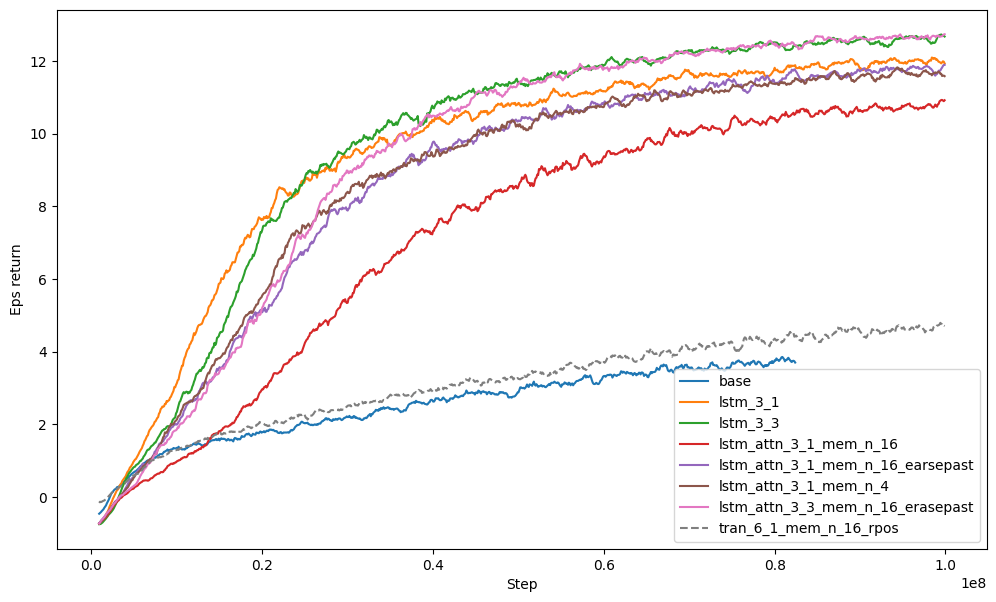

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def mv(a, n=100) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n    

plt.figure()
f, ax = plt.subplots(1, 1, figsize=(12,7))

linestyles=["solid", "dashed", "dotted","dashdot"]
for n, run in enumerate(eps_rets.keys()):
    if (not run == "tran_6_1_mem_n_16_rpos") and ('wrong' in run or 'tran' in run): continue
    #if run == 'tran_1_1_mem_n_1_conv_only' or 'wrong' in run or 'tran' in run: continue          
    ax.plot(steps[run][10-1:], mv(eps_rets[run], n=10), label=run, linestyle=linestyles[n//12])
plt.xlabel('Step')
plt.ylabel('Eps return')
plt.legend()
plt.show()
